In [11]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


# import os
# os.chdir("ensemble-watermark/")

#from modules.GPTQ_loader import load_quantized

import modules.shared as shared
from modules.model import load_model

import hashlib
import spacy
# Load the English language model
nlp = spacy.load("en_core_web_sm")
shared.nlp = nlp

#shared.model_name = "dolphin-2.6-mistral-7b-Mistral-7B-Instruct-v0.1"
#shared.model_name = "dolphin-2.9.4-llama3.1-8b"
shared.model_name = "Meta-Llama-3.1-8B-Instruct-GPTQ-INT4"
#shared.model_name = "google_gemma-2-9b"
#shared.model_name = "mistralai_Mistral-7B"
#shared.model_name = "meta-llama_Llama-3.2-3B"

shared.act_order = True
print(f"Loading {shared.model_name}...")
t0 = time.time()
#shared.model = load_quantized(shared.model_name)
#shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
#shared.tokenizer.truncation_side = 'left'

shared.groupsize = 128
shared.wbits = 4

shared.use_flash_attention_2 = False
shared.model, shared.tokenizer = load_model(shared.model_name, gptq = False, awq=False)

print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")


import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
#shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']
#think if we want to remove classes that dominate others
#shared.classes = ['Gustatory','Haptic','Interoceptive','Olfactory','Foot_leg','Hand_arm','Mouth','Torso']
#shared.classes = ['Haptic', 'Gustatory','Haptic','Interoceptive','Olfactory','Olfactory','Foot_leg','Hand_arm','Mouth','Mouth','Torso']




#words = df.iloc[:, 0]
#value = df.iloc[:, 34]

#selected_columns = df[['Word', 'Dominant.sensorimotor']]  # Specify the columns you want to convert to a dictionary
#shared.sensorimotor = selected_columns.set_index('Word')['Dominant.sensorimotor'].to_dict()
#{'Visual': 22774, 'Auditory': 2690, 'Head': 7740, 'Torso': 223, 'Interoceptive': 1766, 'Mouth': 1166, 'Haptic': 649, 'Hand_arm': 1434, 'Gustatory': 661, 'Foot_leg': 428, 'Olfactory': 176}

#classes_to_remove = ['Torso', 'Haptic', 'Gustatory', 'Foot_leg', 'Olfactory']
#shared.sensorimotor = {item: class_name for item, class_name in shared.sensorimotor.items() if class_name not in classes_to_remove}

#shared.classes = list(set(shared.sensorimotor.values()))

from modules.text_generation import generate_reply

def secure_hash_for_sentence(last_sentence, range_min, range_max):
    doc = nlp(last_sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    print(core_sentence_str)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_integers = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    
    mapped_sentence_number = (hashed_sentence_integers % (range_max - range_min + 1)) + range_min
    return mapped_sentence_number


def secure_hash_for_token(last_token, range_min, range_max):
    hashed_token_bytes = hashlib.sha256(str(last_token.item()).encode()).digest()
    hashed_token_integers = int.from_bytes(hashed_token_bytes[:4], byteorder='big')
    
    mapped_token_number = (hashed_token_integers % (range_max - range_min + 1)) + range_min
    return mapped_token_number

def secure_hash_to_numbers(last_sentence, last_token, range_list):
    
    result_numbers = []
    
    # Compute the secure hash for the last token if last_token is not None
    if last_token is not None:
        token_hash = secure_hash_for_token(last_token, range_list[0][0], range_list[0][1])
    else:
        token_hash = shared.secret_key[0]  # Reuse the shared key if last_token is missing
    
    result_numbers.append(token_hash)
    
    # Compute the secure hash for the last sentence if last_sentence is not None
    if last_sentence is not None:
        sentence_hash = secure_hash_for_sentence(last_sentence, range_list[1][0], range_list[1][1])
    else:
        sentence_hash = shared.secret_key[1]  # Reuse the shared key if last_sentence is missing
    
    result_numbers.append(sentence_hash)
    
    return result_numbers

def get_last_sentence(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    if sentences:
        return sentences[-1]
    else:
        return None  # Return None if there are no sentences



`torch_dtype` is deprecated! Use `dtype` instead!


Loading Meta-Llama-3.1-8B-Instruct-GPTQ-INT4...
Loading Meta-Llama-3.1-8B-Instruct-GPTQ-INT4...


/home/vsetpal/final_project/ensemble-watermark/venv/lib/python3.9/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/vsetpal/final_project/ensemble-watermark/venv/lib/python3.9/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/vsetpal/final_project/ensemble-watermark/venv/lib/python3.9/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension no

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at models/Meta-Llama-3.1-8B-Instruct-GPTQ-INT4 were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers

Loaded the model in 12.42 seconds.

Loaded the model in 12.42 seconds.


In [ ]:
# === Streaming-only dataset loading & generation cell ===
import os, random, psutil, gc, json, textwrap
from datasets import load_dataset
from itertools import islice
from transformers import AutoTokenizer
from modules.text_generation import generate_reply
import modules.shared as shared
import torch

# === Parameters ===
num_samples = 400                # number of random samples to extract
num_tokens_trimmed = 200        # how many tokens to trim from end
tokenizer_name = "gpt2"         # tokenizer for C4 segmentation
sample_buffer = 1000             # how many examples to temporarily buffer from stream
max_new_tokens = 200            # generation length


# === Load tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# === Load dataset in streaming mode ===
dataset = load_dataset("allenai/c4", "realnewslike", split="train", streaming=True)
samples = list(islice(dataset, sample_buffer))
chosen_examples = random.sample(samples, num_samples)
print(f"Streamed {len(samples)} temporary examples, sampling {num_samples}")

# === Utility: process each text into prompt + baseline completion ===
def process_text(text, num_tokens_trimmed):
    tokens = tokenizer.tokenize(text)
    if len(tokens) <= num_tokens_trimmed:
        return None, None
    prompt_tokens = tokens[:-num_tokens_trimmed]
    baseline_tokens = tokens[-num_tokens_trimmed:]
    prompt = tokenizer.convert_tokens_to_string(prompt_tokens)
    baseline_completion = tokenizer.convert_tokens_to_string(baseline_tokens)
    return prompt, baseline_completion

# === Process selected samples ===
c4_random_samples = []
for ex in chosen_examples:
    text = ex["text"]
    prompt, baseline_completion = process_text(text, num_tokens_trimmed)
    if prompt and baseline_completion:
        c4_random_samples.append({
            "prompt": prompt,
            "baseline_completion": baseline_completion
        })

print(f"Prepared {len(c4_random_samples)} samples for generation")

# === Start generation ===
results = []
progress = 0

print("\nStarting generation loop...\n")
for i, sample in enumerate(c4_random_samples):
    prompt = sample["prompt"]
    question = f"<|begin_of_text|> {prompt}"

    generate_params = {
        "max_new_tokens": max_new_tokens,
        "add_bos_token": False,
        "truncation_length": 4096,
        "custom_stopping_strings": ["### Human:", "Human:", "user:", "USER:", "Q:", "<|im_end|>", "<|im_start|>system"],
        "ban_eos_token": False,
        "skip_special_tokens": False,
        "do_sample": False,
        "early_stopping": False,
        "seed": 0,
    }

    # --- Baseline generation ---
    shared.delta_senso = 0.0
    shared.delta_acro = 20.0
    shared.secret_key = [0, 0]
    shared.new_sentence = False
    reply_base, _ = generate_reply(question, generate_params, eos_token="<|end_of_text|>")

    # --- Watermarked generation ---
    shared.delta_senso = 2.5
    shared.delta_acro = 0.0
    shared.secret_key = [0, 0]
    shared.new_sentence = False
    reply_watermark, _ = generate_reply(question, generate_params, eos_token="<|end_of_text|>")

    results.append({
        "prompt": prompt,
        "reply_base": reply_base,
        "reply_watermark": reply_watermark
    })

    progress += 1
    print(f"\n--- Sample {progress} completed ---")
    print(f"Prompt:\n{textwrap.shorten(prompt, width=200)}")
    print(f"\n[BASE]: {reply_base[:300]}...")
    print(f"[WM  ]: {reply_watermark[:300]}...\n")

    # Free memory
    gc.collect()
    torch.cuda.empty_cache()

# === Save results ===
os.makedirs("outputs", exist_ok=True)
output_path = "outputs/replication_results_streaming.jsonl"
with open(output_path, "a") as f:
    for r in results:
        f.write(json.dumps(r) + "\n")

print(f"Saved {len(results)} results to {output_path}")


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1654 > 1024). Running this sequence through the model will result in indexing errors


Streamed 1000 temporary examples, sampling 400
Prepared 314 samples for generation

Starting generation loop...



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 1 completed ---
Prompt:
A stunning development opportunity - large building with consent to convert to a dwelling. Attractive setting. 5/6 Bedrooms. Excellent views. Exciting design. Very accessible. Near to [...]

[BASE]:  on planning applications. You can then search for the reference number above.
The property is situated in a rural location and is surrounded by rolling countryside. Grounds of 1. July acres are included with the property. You can see the property from the A396. By turning off the A396 onto the B318...
[WM  ]:  on the search for planning applications. Then enter the reference number and click on search. The details of the approval can be viewed on the website.
The approval is for a dwelling house and ancillary garage. The full details of the approval can be viewed on the Mid Devon District Council website...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 2 completed ---
Prompt:
Two slaughtermen have been sacked after an undercover investigation exposed shocking cruelty to horses at an abattoir. The disturbing video shows them being beaten with metal poles and illegally [...]

[BASE]: 'Our company has a zero tolerance policy towards animal welfare and public health breaches.
'Our company has a zero tolerance policy towards animal welfare and public health breaches.
'Our company has a zero tolerance policy towards animal welfare and public health breaches.
'Our company has a zero ...
[WM  ]: The statement concluded: 'We are committed to the welfare of animals and public health and will continue to work with the FSA to maintain the highest standards.'
A Hillside spokesperson said: 'Our undercover investigation has exposed the shocking cruelty and neglect at Red Lion Abattoir.
The footage...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 3 completed ---
Prompt:
GRANT COUNTY, N.M. - "Everywhere I go, the kids call me the book lady," Dolly Parton said. She may be known for her country hits, but for years Dolly Parton has been giving out books to homes [...]

[BASE]:  our project."
The program sends a free book to every child in Grant County every month, from birth to age five. Just last year, they sent out over 10,000 books.
"It's not just about the books. It's about the love and the nurturing that comes with reading," Parton said.
Dolly Parton's Imagination Li...
[WM  ]:  the answer."
The program sends a free book to every child from birth to age five in the county, every month. The books are chosen by Dolly Parton herself, and they cover a wide range of topics, from animals to fairy tales.
"It's not just about getting a book. It's about getting a book that's going ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 4 completed ---
Prompt:
Richard Swift Obituary: Richard Swift’s Obituary by the TheTimesNews.com. Richard Swift, singer-songwriter,

[BASE]:  dies at 38 – The Guardian.
Richard Swift, singer-songwriter and producer, dies at 38 – The Independent.
Richard Swift, singer-songwriter and producer, dies at 38 – The Telegraph.
Richard Swift, singer-songwriter and producer, dies at 38 – Rolling Stone.
Richard Swift, singer-songwriter and producer...
[WM  ]:  musician and producer who was a key figure in the indie rock scene, has died at the age of 38. Swift, who was known for his distinctive voice and eclectic style, had been open about his struggles with addiction and mental health in the years leading up to his death. He was found dead in his home in...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 5 completed ---
Prompt:
It is possible more people who came in contact with a man who died from the Ebola virus in Dallas, Texas, could test positive for the virus in the coming days, the head of the Centers for [...]

[BASE]:  came back positive. More tests were conducted, and the results were confirmed on Saturday.
Frieden said the nurse was wearing full protective gear, including a gown, gloves, mask and eye protection, when she came into contact with Duncan’s bodily fluids. At the time, Duncan was in a private room, a...
[WM  ]:  came back positive. She was immediately isolated and is in stable condition, according to Frieden.
The nurse, who has not been identified, had been wearing protective gear and followed all the proper protocols, Frieden said. However, the virus still managed to breach her protective gear and infect ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 6 completed ---
Prompt:
OKLAHOMA CITY- A metro family is looking for answers after their 21-year-old daughter was found dead. Police are saying the death of Sandra Stevens appears to be a suicide, but those closest to [...]

[BASE]:  who were at the home that night.
Sandy’s family is now questioning the official cause of death.
They want to know if someone else might have been involved.
The Oklahoma City Police Department is still investigating the case.
Sandy’s family is asking anyone with information to come forward.
They wan...
[WM  ]:  and the victim who were in the house that night.
Sandy’s family is now questioning the official story.
They want to know what really happened inside that house and who else might have been involved.
Police have not confirmed any information about other potential suspects.
The family is now calling ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 7 completed ---
Prompt:
Wildlife rehabilitators said 88 more pigeons were found at an I-65 rest stop where police found 57 others dumped in December. WOLCOTT, Ind. (WLFI) — Wildlife rehibilators said 88 more pigeons [...]

[BASE]: 's number was on the tags and the pigeons were dumped in the same location has led Hoover to believe it's the same person.
Hoover said she's working with the Indiana State Police to find the person responsible for the dumping. Zoo officials and local animal control are also helping her care for the ...
[WM  ]: 's number was the same on both sets of pigeons caught Hoover's attention.
"It's a very disturbing situation," she said. "You know what's disturbing? It's not the pigeons. It's the people who are doing this."
Hoover said the pigeons are being taken care of at Hoots to Howls Wildlife Rehabilitation. S...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 8 completed ---
Prompt:
Riot police were quick to crack down on a march in Hledan market in Yangon, beating several protesters on March 10. A group of students and activists came onto the streets of Yangon at 2 pm in [...]

[BASE]:  the students to enter into Yangon, but they would not be allowed to march to the city center.
So students in Letpadan decided to march to the city center. Finally, the students in Letpadan were allowed to march to the city center, but they were not allowed to march to the city center in a group. So...
[WM  ]:  the students to enter into Yangon only if they agreed to cancel their protest in Yangon.
The students in Letpadan agreed to cancel their protest in Yangon in order to enter into Yangon on March 10. But the students in Letpadan were arrested by the authorities on March 10. So students and activists ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 9 completed ---
Prompt:
Under intense pressure to improve conditions in the jail complex on Rikers Island, the administration of Mayor Bill de Blasio has developed a plan to move 16- and 17-year-olds to a dedicated [...]

[BASE]:  process.
“While we are glad that the city is finally taking steps to move 16- and 17-year-olds out of Rikers, we are disappointed that it will take so long,” said Judith Gold, executive director of the Center for Community Alternatives. But she added, “We are hopeful that this will be a step in the...
[WM  ]:  and political hurdles.
“While we applaud the city’s commitment to creating a dedicated facility for youth, we are disappointed that it will not be operational in the near term and that it will not address the immediate needs of the youth currently being held at Rikers,” said Judith Hope of the New ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 10 completed ---
Prompt:
France is in a difficult position. It has not had a sufficient spur to reform, despite the platitudes by both Sarkozy and Hollande. The fall of the Berlin Wall was a great spur to Germany, [...]

[BASE]:  been as low as 25 bp. Even if the premium were to rise to 50 bp, it is unlikely to be a capital strike. Until then, the French will continue to enjoy the benefits of the German credit. It is a situation that is unlikely to change anytime soon. Until then, the French will continue to enjoy the benef...
[WM  ]:  declined by 20 bp. The bond market is not going to be the catalyst for reform. The French government has been able to satisfy the bond market with its promise of fiscal consolidation in the future. The bond market is not going to be the catalyst for reform. The French government has been able to sa...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 11 completed ---
Prompt:
Housing secretary James Brokenshire announced today (29 November) that under new legislation, combustible materials will not be permitted in the external walls of new buildings over 18m tall and [...]

[BASE]:  on high-rise buildings in the wake of the Grenfell Tower fire.
The AJ understands that the government is also considering a ban on combustible materials in the external walls of buildings under 18m tall, but this is still under consideration.
The government has also announced a new £30 million fund...
[WM  ]:  on high-rise buildings in the wake of the Grenfell Tower fire.
The AJ understands that the legislation will be included in a new bill to be introduced in the House of Commons on 4 December.
The government has also announced that it will be consulting on a new national plan to remove ACM cladding fr...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 12 completed ---
Prompt:
April 24 (Reuters) - Canadian stock index futures pointed to a higher open, supported by some stronger-than-expected North American corporate earnings and data from Germany that boosted hopes of [...]

[BASE]:  The bank said it will pay C$1. On April 24, 2013, the Canadian dollar was trading at 1. PricewaterhouseCoopers : The accounting firm said it will pay C$1. Canadian Tire Corp : The company said it will pay C$1. Canadian Tire Corp : The company said it will pay C$1. Canadian Tire Corp : The company s...
[WM  ]:  The bank said it will invest C$1.5 billion in a new Canadian data center in the province of Quebec.
* The Canadian dollar rose to a 3-1/2 month high against the U.S. dollar on Wednesday, boosted by data showing a sharp increase in Canadian housing sales.
* The Canadian dollar rose to 1.0145 against...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 13 completed ---
Prompt:
Competitors from the Peaked Masters, in white, defeated the the Navy Old and Gnarly Goats, in blue, at the Vail Lacrosse Shootout on Saturday, June 30 to earn the Zenmasters division trophy for [...]

[BASE]: ., 11 a.m., 11:30 a.m., 12 p.m., 12:30 p.m., 1 p.m., 1:30 p.m., 2 p.m., 2:30 p.m., 3 p.m., 3:30 p.m., 4 p.m. You can also catch the women’s elite division at the Ford Park fields at 9 a.m., 10 a.m., 11 a.m., 12 p.m., 1 p.m. On Tuesday, July 3, the men’s elite division will continue at Ford Park at 8...
[WM  ]: ., and 11 a.m. The Ford Park East field will host women’s elite division play with matches scheduled for 8:45 a.m., 10 a.m., 10:30 a.m., and 11 a.m.
The Ford Park East field will also host the men’s masters division play with matches scheduled for 8:45 a.m., 10 a.m., 10:30 a.m., and 11 a.m.
The Ford...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 14 completed ---
Prompt:
Kerth, 67, was selected from 164 applicants to be the organization’s new chief executive. He sits on the board of the Sacramento Municipal Utility District and is a scion of the Kerth family who [...]

[BASE]:  projects, which bring together volunteers from different faiths to build a home for a low-income family. Community outreach and education are also key components of the organization’s work.
Kerth said he’s been impressed by the organization’s commitment to community engagement and its efforts to bu...
[WM  ]:  and the role of faith in the community. Kerth said he is excited to be part of that effort and said he is looking forward to the challenge of leading the organization forward.
The Sacramento Habitat affiliate has been in existence since 1987 and has built 1,300 homes in the Sacramento area since th...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 15 completed ---
Prompt:
IF you are wondering why your cat sleeps 16 hours a day, stop. It is normal. Cats know how to sleep and can sleep anywhere they want to — any table, chair, top of a shelf, window ledge, in the [...]

[BASE]:  you? You might be wondering how I know that. No, I don’t have a spy camera in your bedroom. X-ray vision is not one of my special powers. I just know that it’s a common place for cats to sleep. Now, I know that you might be thinking, “But my cat sleeps on the couch, or on the windowsill, or on the ...
[WM  ]:  you? Or perhaps on the foot of your bed, where you can just reach out and pet him? Or maybe he prefers to curl up in a tight ball on the couch, or on the windowsill or even on the floor? Wherever your cat chooses to sleep, it is probably going to be the most comfortable and peaceful place in the ho...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 16 completed ---
Prompt:
Timothy: It is a well-known secret agenda that the authorities want to convert as many Orang Asli and natives in Sabah and Sarawak into Muslims. Many don't even know they have converted until [...]

[BASE]: ry and intolerance are the hallmarks of the Malay Muslim community in Malaysia. They are the most intolerant and bigoted people in the world.
They are the ones who are always whining about being victimised and oppressed, but they are the ones who are doing the oppressing and victimising others.
They...
[WM  ]: ry and discrimination against the Orang Asli is nothing new in our country. The Orang Asli are not even allowed to use their own language in the classroom.
I have seen Orang Asli children crying in the classroom because they are forced to speak Malay or English. Their own language is the language of...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 17 completed ---
Prompt:
The City collects garbage weekly from 600,000 households along 350 daily routes. The City has long organized garbage collection services on a ward-by-ward basis. The City assigns the laborers [...]

[BASE]:  a few bucks in the driver's truck. Quite a few of the garbage men were on the take and would make sure that your trash was picked up. However, if you didn't grease the wheels, your trash might not be picked up for a week or two. Quite a few of the garbage men were also on the take from the local al...
[WM  ]:  a friendly smile. The garbage men were the only ones who got to see the inside of your house, and they were the only ones who got to see the inside of your house without being invited. They were the only ones who got to see the inside of your house without being invited because they were the only o...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 18 completed ---
Prompt:
Professional golfer Fred Funk, right, gave a clinic Monday at The Woodlands Country Club, the site for the 10th Annual Insperity Championship. THE WOODLANDS - Professional golfer Fred Funk made [...]

[BASE]: , the field for the tournament was still being finalized, but Funk said he was excited to see the caliber of players that would be competing.
The Insperity Championship is one of the most prestigious events on the PGA Champions Tour, and it has become a staple in The Woodlands golf community.
Funk, ...
[WM  ]: , the field for the tournament was set, and Funk said the competition will be fierce this year.
The Insperity Championship is one of the most prestigious events on the PGA Champions Tour, and it consistently draws top talent from around the world.
Funk said the country club’s course is one of the be...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 19 completed ---
Prompt:
Wolters Kluwer’s compliant document solutions enable it to generate, print, fulfill and deliver compliant dynamic content. By using dynamic content, Wolters Kluwer can assist in reducing the [...]

[BASE]:  and comply with the new regulations.
Wolters Kluwer Financial Services has launched a new tool to help financial institutions comply with the new requirements of the Real Estate Settlement Procedures Act (RESPA) that take effect January 1, 2010. Our RESPA Tool Kit is designed to help financial inst...
[WM  ]:  and comply with the new regulations.
Wolters Kluwer Financial Services and the Mortgage Bankers Association (MBA) have formed an alliance to provide financial institutions with a comprehensive tool to help them comply with the new requirements for the Real Estate Settlement Procedures Act (RESPA).
...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 20 completed ---
Prompt:
Inciner8 has donated £140,000 worth of technology and machinery to enable the safe cremation of victims of the disease. A Southport business has entered the New Year in good spirits, after [...]

[BASE]:  training to local staff.
The company has also been working with the World Health Organisation (WHO) to provide safe incineration facilities for the disposal of medical waste in Ebola affected areas.
Managing Director of Inciner8, Ian King, said: “We are absolutely delighted to have received this aw...
[WM  ]:  training and support to local staff.
The company has also been working with the World Health Organisation (WHO) to provide safe incineration facilities for the disposal of medical waste in Ebola affected areas.
Managing Director of Inciner8, John Browne, said: “We are absolutely overjoyed to have r...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 21 completed ---
Prompt:
General Motors has made its first decision in its ongoing global media review: It has cut social media agency Big Fuel from its AOR roster. GM informed Big Fuel of the decision on Nov. 1, [...]

[BASE]:  to handle GM's social media business.
Big Fuel was one of the first agencies to specialize in social media, and it has worked with a number of major brands, including GM, Ford and Chrysler.
The agency's loss of GM's business is a significant blow, as the automaker is one of the largest advertisers ...
[WM  ]:  and hired a number of former GM employees.
Big Fuel was one of the first social media agencies to be hired by GM, back in 2007. The agency was tasked with building the automaker's social media presence and handling online advertising for several GM brands, including Chevrolet, Buick and GMC.
GM's d...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 22 completed ---
Prompt:
A federal judge in California says that uninsulated power conductors owned by a local utility company were the cause of several wildfires that state agencies battled across California since [...]

[BASE]:  high-wind events, the sparks can ignite fires."
The ruling is a significant development in the ongoing investigation into the causes of the devastating wildfires that have ravaged California in recent years. PG&E has faced numerous lawsuits and regulatory actions over its handling of the fires, whi...
[WM  ]:  the dry conditions that have prevailed in recent years, these sparks can ignite fires."
The ruling is a significant development in the ongoing investigation of the causes of several major wildfires that have ravaged California in recent years, including the Camp Fire that destroyed the town of Para...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 23 completed ---
Prompt:
The former teen star has become more known for her bizarre behavior. Is Amanda Bynes the new Britney Spears? Maybe. The 26-year-old former Nickelodeon star tweeted on Thursday that aside from [...]

[BASE]:  seems like Bynes is taking a step in the right direction. After a tumultuous year, she has been open about her struggles with an eating disorder and her desire to get help.
In a statement to People magazine, her rep said, “Amanda is doing well and is taking steps to get the help she needs. It’s a p...
[WM  ]:  seems the actress is now moving on from her run-in with the gossip rags. She now seems to be focusing on her mental health and body image.
Bynes ended her tweet with a plea to her fans to leave her alone.
“Leave me alone and let me live my life. I’m going to be okay. I’m going to be happy. I’m goin...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 24 completed ---
Prompt:
NEW YORK (1010 WINS) — Apparently even rats like fancy digs. According to

[BASE]:  a report from the New York Post, a group of rats have been spotted living in a luxury high-rise building in Manhattan.
The rodents were seen scurrying around the lobby of the 40-story building at 200 Central Park South, which is home to some of the city’s most expensive apartments.
The building’s m...
[WM  ]:  the New York Post, a high-end apartment building in the West Village is being overrun by rats.
The building, located at 55 West 13th Street, is a luxury rental building with prices ranging from $3,000 to $6,000 per month.
But despite the high prices, the building is apparently infested with rats.
R...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 25 completed ---
Prompt:
The first major of the year began on Thursday as the 83rd edition of the Masters kicked off at Augusta. Tiger Woods enjoyed an impressive first round, with John Rahm and Adam Scott among those [...]

[BASE]:  20 years.
Woosnam has been a regular at Augusta since his playing days but his game has long since gone the way of the dinosaurs.
'I'm not sure I'll be back next year,' he said, with a hint of resignation. Unfortunately, he's not the only one who's struggling.
Justin Thomas, the world No 3, is anot...
[WM  ]:  the last 18 years.
I must admit I do feel sorry for the old boy. He's a true gentleman and I have a lot of time for him. But, as he himself would say, 'it's time to hang up my spikes'.
The 2019 Masters champion is back in the mix, but Brooks Koepka's opening 75 was a far cry from the form that saw ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 26 completed ---
Prompt:
(AllHipHop News) Nipsey Hussle's influence on the South Los Angeles community he served will go down in U.S. history. That is because representative Karen Bass of California made a commitment to [...]

[BASE]:  on March 31, 2019. While he was only 33 years old at the time of his death, his legacy has endured and inspired countless people.
Nipsey Hussle was a devoted philanthropist who invested in his community through various initiatives, including the Marathon Crenshaw Plaza, a mixed-use development proj...
[WM  ]:  on March 31, 2019. He was 33 years old at the time of his death.
Rep. Bass, who represents the 37th Congressional District which includes South Los Angeles, has been a long-time friend and advocate for the late rapper. She has been instrumental in pushing for recognition of his contributions to the...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 27 completed ---
Prompt:
As usual, Professor Jack Ponton (

[BASE]: a renowned expert in the field) was invited to give the keynote address. Quite unexpectedly, he announced that he was retiring from academia and would be leaving the university at the end of the year. You are a member of the search committee for his replacement. How would you go out on a high note a...
[WM  ]: the renowned expert on the history of the British Army) was kind enough to share his knowledge with me and offer valuable insights. I must also thank my friend and fellow military historian, Dr. John Keegan, for his encouragement and support throughout this project.
In addition, I would like to expr...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 28 completed ---
Prompt:
Mississippi Burning: As Ferguson Erupts, Obama Honors Civil Rights Activists Slain by Klan in 1964 | Democracy Now! AMY GOODMAN: Let’s go to President Obama’s comments Monday at the Presidential [...]

[BASE]:  Neshoba County. The road is straight and flat. Zulu, the FBI’s code name for the investigation, was the largest in the agency’s history. Hundreds of agents were involved. James Chaney, Andrew Goodman and Michael Schwerner were last seen alive on June 21st, 1964. James Chaney was driving. X marked t...
[WM  ]:  Neshoba County. The road is straight and flat. The only thing that can be seen on the side of the road is a small sign that says, "Turn left for Philadelphia." The sign is not very big, but it’s very important. It’s the last sign before you enter Neshoba County. The sign is important because it’s t...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 29 completed ---
Prompt:
The final chapter in Roy Andersson's droll trilogy 'on being a human being' introduces three dozen more brilliantly absurd vignettes. In a Venice Film Festival lineup full of cynicism, suicide [...]

[BASE]: et, Nordisk Film & TV Fond, Film i Väst, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, Film i Väst, Nordisk Film & TV Fond, ...
[WM  ]: et and the Film Fund of Norway.
Cinematography: Lennart Dahlström.
Editing: Thor Jonsson.
Music: Jean-Michel Hugel.
Sound: Jean-Michel Hugel.
Production Design: Roy Andersson.
Costume Design: Roy Andersson.
Cast: Nils Westblom, Holger Andersson, Björn Granath, Jean-Christophe Anquier, Stig Ojervall,...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 30 completed ---
Prompt:
JOINT BASE LEWIS-McCHORD, Wash. -- Staff Sgt. Robert Bales made a mid-massacre confession, asked for help bleaching his blood-stained clothing and deliberately destroyed his laptop computer, [...]

[BASE]:  Police officers, who were visibly shaken. Kandahar's top police commander, Gen. Hafizullah Khaliqi, was also present, and he told the soldiers that the villagers were "very upset" and that the police were "very angry."
The hearing is expected to continue through the week, with several more witnesse...
[WM  ]:  Police officers, who were visibly upset. The interpreter told them that there had been a massacre in the villages.
After hearing the testimony, the judge, Lt. Col. David Shalford, told the court that he would consider whether the evidence presented so far was strong enough to warrant a court-martia...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 31 completed ---
Prompt:
Talking to the press people here at the Heliport on Saturday, the National BJP leader, while stating the Naga issue as complicated, said all the stakeholders would taken on board while trying to [...]

[BASE]: unachal Pradesh, the State Governments would be able to work in tandem with the Centre to find a solution to the Naga issue.
The National BJP leader also expressed the hope that the Naga issue would be resolved before the next Parliamentary Election, and the people of the State would be able to exer...
[WM  ]: unachal Pradesh, the State Governments would be able to work in tandem with the Centre to find a solution to the Naga issue.
The National BJP leader also expressed the hope that the Nagas would be able to find a solution to their issue before the next Parliamentary Election. He also expressed the ho...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 32 completed ---
Prompt:
HANOI, Vietnam – Vietnam&apos;s government has vowed to crack down on three dissident blogs, a move that appeared to backfire Thursday as record numbers of people visited the sites and the [...]

[BASE]: The blogger said that Danlambao has been receiving more than 1,000 emails a day from Vietnamese citizens who want to contribute to the site or report on stories.
The government has been trying to control the Internet, which has become a major source of information for Vietnamese citizens. Earlier th...
[WM  ]: The blogger said that while the government has been able to block access to the sites, it has not been able to stop the flow of information. "We are not a traditional media, we are not a newspaper. We are a network of independent journalists. We can be cut down, but the information will still be the...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 33 completed ---
Prompt:
The Las Vegas real estate market got a small reprieve in February; with sales volume at a four-year high for the month and a dip in foreclosure resales helping prices increase slightly from [...]

[BASE]:  last year. DataQuick said the median price for new homes was $143,000, down from $145,000 in January and down from $173,000 last year. March 2010 sales are expected to be higher than February’s, with the Las Vegas real estate market showing signs of improvement. One of the reasons for the improveme...
[WM  ]:  last year. The average price for all homes sold in February was $143,000, down 1.4% from $145,000 in January but up 1.4% from $140,800 last year. The average price for single-family homes was $153,000, down 1.3% from January but up 1.5% from last year. The average price for condos was $104,000, dow...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 34 completed ---
Prompt:
JOINT BASE ELMENDORF-RICHARDSON, Alaska -- U.S. Army Alaska and the Indian Army celebrated the end of Yudh Abhyas 2010 during a ceremony Nov. 14 at Buckner Physical Fitness Center, Joint Base [...]

[BASE]:  "This exercise was a great example of the U.S. Department of Defense's commitment to building relationships with our international partners. Clearly, the U.S. We value our relationship with India and we look forward to continuing to build on this relationship in the future."
The exercise was a succ...
[WM  ]:  "The significance of this exercise goes beyond the training itself. It's the relationships that we've built, the friendships that we've made, and the operational knowledge that we've gained."
The exercise was a success, said Lt. Col. S. K. Singh, commanding officer of the 62nd Infantry Brigade. "Th...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 35 completed ---
Prompt:
There is now less than one week to go before the gun goes off to start the Berhamsted Half Marathon and Five Mile Fun Run. At this point in the schedules, there’s not a lot that the runners can [...]

[BASE]:  they will be providing a free service to all runners, capturing their finish and providing a free download of their photo.
SSP will also be providing a free photo gallery on their website, which will be available to all runners and spectators.
The photos will be available to download free of charge...
[WM  ]:  the SSP team will be capturing all the action on camera, and the pictures will be available on the club’s website shortly after the event.
SSP will also be running a social media campaign to encourage runners to share their photos and experiences on the day.
> The Berkhamsted Half Marathon and Five...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 36 completed ---
Prompt:
In the age of Instagram, food is no longer designed to just be food. It’s a set piece, a lifestyle statement of fantastical hyperbole. So we drink unicorn lattes, eat rainbow bagels, and lick [...]

[BASE]:  a pie anyway. However, the brand’s approach is not just about authenticity; it’s also about the way it’s using social media to subvert expectations. It’s not just about being real; it’s about being the opposite of what everyone else is doing. Rather than trying to create a perfect, Instagrammable i...
[WM  ]:  the pizza anyway. But the real question is whether this approach can be replicated by other brands. Can a brand that’s as bland as a stale cracker, with a product that’s as unremarkable as a stale cracker, make a statement by embracing its own blandness? Can a brand that’s as bland as a stale crack...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 37 completed ---
Prompt:
After an Iranian official said that the Islamic Republic's athletes would play “every country” at the Olympics, it seemed the London Games would put a halt to Iranians boycotting events to avoid [...]

[BASE]:  Games. Reuters reported that he had been banned from competing by the Iranian government.
The Iranian government has been known to use sports as a tool of foreign policy. Xi Jinping, the Chinese president, has also used sports to make a point, famously boycotting the Olympics in 2008 to protest a h...
[WM  ]:  Games and was not included in Iran's Olympic team. The reason for his absence is unclear.
Iran has sent a total of 53 athletes to the London Games, while Israel has sent 40. The two countries are not in the same Olympic events in many cases, and when they are, it may be in sports like weightlifting...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 38 completed ---
Prompt:
Reply to post: Re: Legislation can save lives. Re: Legislation can save lives. @ Pen-y-gors:"Someone elsewhere in a lovely bit of whataboutery said that 10,000+ people are killed in car [...]

[BASE]:  on drunk driving. Cars and alcohol are not going to go away, but we can make the roads safer by enforcing the law and educating people about the dangers of drunk driving. It's a bit like the gun control debate in the US, where the pro-gun lobby says that the answer is to ban guns, but the anti-gun ...
[WM  ]:  on the drivers who misuse them. That way we can enjoy the benefits of both, while reducing the harm caused by their misuse. That is what we should be doing with guns and mental health."
I agree with you and think that's the way forward for the UK. However, I must say I'm still a bit puzzled by your...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 39 completed ---
Prompt:
The reality is that you will only have some of your content go viral or hit a home run. So you will need to persist with your content marketing strategy. Buzzfeed, Upworthy and the humble blogs [...]

[BASE]:  readers to be able to make money from their blogs and content marketing efforts. But to do this you will need to be professional, persistent and patient.
You will need to be willing to learn and adapt to the changing landscape of content marketing and blogging.
You will need to be willing to take c...
[WM  ]:  readers and followers to be able to share our content easily and quickly with their friends and family on social media. We want to be able to reach a wider audience and get more traffic and engagement on our blog.
So we must make sure that our content is optimized for sharing. We do this by followi...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 40 completed ---
Prompt:
Political surveys and their results consume a large part of the political discourse. Political officials at many different levels of government have come to rely on them as representing their [...]

[BASE]:  their voices are being heard in the political process. Various studies have shown that the public is not always accurately represented by surveys. One study found that the public's views on issues were not accurately represented by surveys. In fact, the study found that the public's views were ofte...
[WM  ]:  the political system is truly representative of their views. This is a concern because it can lead to a disconnection between citizens and their government. This study examines the relationship between survey responses and political participation. It also examines the relationship between survey re...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 41 completed ---
Prompt:
Editor's note: Stephen Lemons is a blogger and columnist with Phoenix New Times in Phoenix, Arizona. Phoenix, Arizona (CNN) -- Every movement needs heroes. The fight against discrimination in [...]

[BASE]:  activists were taken away.
The nine were arrested, but their message was heard. The bill's passage has been met with a firestorm of criticism from civil rights groups, the U.S. Attorney General, the U.S. Quaker Council, the U.S. Youth Council, the U.S. American Civil Liberties Union, the U.S. Knigh...
[WM  ]:  activists were taken away.
The fight is not over yet. The activists' statement said they will continue to resist the bill, and that their actions will be peaceful. Brewer has until July 20 to sign the bill into law, or to veto it. If she signs it, or does nothing, it goes to the state's voters in N...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 42 completed ---
Prompt:
Russell Scherrer is taking another shot at constructing a new auction business, and this time he is promising to provide Wales officials with specific details about his plans. Scherrer and his [...]

[BASE]:  Phase II, to be completed by Dec. The auction business will be housed in a 20,000-square-foot building. Exterior lighting and 100 parking spots will be allowed.
* Phase III, to be completed by Dec. June 15, 2004, will include a 20,000-square-foot storage building and a 10,000-square-foot office bui...
[WM  ]:  Phase II, to be completed by August 15, would consist of an auction building with a 10,000-square-foot sales floor. The building would be about 30 feet from the existing office building.
* Phase III, to be completed by year's end, would consist of an indoor storage facility for vehicles and other e...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 43 completed ---
Prompt:
This is a short but enthralling walk, possibly the nicest coastal walk in Ireland: it’s a walk to take at your ease, to stop, look around, sit and listen. Normally the promotional photo for a [...]

[BASE]:  to sit and listen.
We continued on to the Napoleonic Watchtower, a fine example of the military architecture of the time, and then to the signal tower, which is a bit of a mystery. Zeroing in on the signal tower, we found ourselves in a world of wild, ragged beauty, with the sea and sky in constant...
[WM  ]:  to sit and listen.
Now I know that the sound of the sea is a cliché, but I do not think that it is ever going to be a cliché for me. I have sat for hours on this walk in the sound of the sea, in all weathers, and I have sat for hours in other places, in all weathers, and still it remains for me the...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 44 completed ---
Prompt:
Latest in "Revolution in Rojava" Who are they, these revolutionary Rojava women? Meredith Tax just had to find out who they were - the revolutionary women of Rojava, bearing arms against ISIS, [...]

[BASE]:  The revolution is not a static thing, it is a process, and it is not always easy to keep up with. Witnessing the Rojava revolution, part 5.
The Rojava revolution is not just about the people of Rojava, it is about the people of the world. Our struggle is not just for our freedom, but for the freedo...
[WM  ]:  The story of how the revolution came into being, how it has been sustained, and the impact it has had on the people of the region is a story that is still unfolding. Part 5 of Witnessing the Rojava revolution.
In this part of her series, Meredith Tax explores the role of the women of Rojava in the ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 45 completed ---
Prompt:
Interest in film-making has exploded among young Kenyans, hundreds of whom responded to the call that went out from an international film team called “Stories Found” in mid-2018. The team was [...]

[BASE]:  been well-received by audiences in the US and Kenya. And they are both available on YouTube. For those who may not know, “Zumari” is a Swahili word for “the wild” or “the untamed”. “Shoto” is a Swahili word for “the short one” or “the small one”.
Zumari is a film short that tells the story of a you...
[WM  ]:  been nominated for the prestigious Student Academy Awards. “Zumari and Shoto are both set in the Kenyan countryside,” says Evie. “Zumari is about a young girl who goes to school for the first time. Shoto is about a young boy who is learning to make a bow and arrow in the bush.” “The two films are a...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 46 completed ---
Prompt:
There are now conflicting reports as to whether Nancy Lanza — the mother of Newtown shooter Adam Lanza and the woman believed to be his first victim — taught at Sandy Hook Elementary, where [...]

[BASE]:  her classroom. More recently, however, the school district has said that Nancy Lanza was not a teacher at the school, but rather a substitute teacher who had worked there in the past. Other reports have suggested that she may have been a parent volunteer or a substitute teacher who had not worked a...
[WM  ]:  the classroom where his mother was the teacher. But now, the school district is saying that was not the case. “The statement that Nancy Lanza was a teacher at Sandy Hook School is incorrect,” said a district spokesperson in a statement. “Nancy Lanza was not a teacher at Sandy Hook School. She was a...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 47 completed ---
Prompt:
While many restaurants in New York City have close relationships with farmers, and boast unimpeachable farm-to-table ethics, far fewer have actual gardens wherein they grow the produce that’s [...]

[BASE]: 000 square feet of soil, grow 20 varieties of tomatoes, 10 types of lettuce, 5 kinds of herbs, and 4 varieties of peppers. Produce is used in the restaurant’s seasonal dishes, such as the summer vegetable salad, which features a mix of heirloom tomatoes, zucchini, and eggplant.
The garden atop the W...
[WM  ]: 000 square feet of soil, grow 20 varieties of tomatoes, 10 types of lettuce, 5 kinds of herbs, and 4 different peppers. The garden is a work in progress, but the restaurant has already started serving dishes made with its produce, like the burrata with heirloom tomatoes and basil pictured.
The food ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 48 completed ---
Prompt:
In this three-part mini-series, Stefanie Koehler shares her experiences in bringing a sustainability focus into her work. Biomimicry, the practice of emulating models and strategies found in [...]

[BASE]:  a community setting.
The SolDrop system is inspired by the way that the lotus leaf repels water and the way that the pine needles collect moisture. SolDrop's modular design allows for easy maintenance and scalability, and the use of recycled materials reduces waste and supports local economies.
The...
[WM  ]:  the field.
The SolDrop system is an example of a biomimetic design that uses the strategy of high surface area, similar to the pine needles, to create a self-sustaining water treatment system. The idea is that the system can be easily replicated and maintained by local communities, providing a sust...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 49 completed ---
Prompt:
Three people including a child have been injured after an explosion and fire on a boat at Ely in Cambridgeshire. Firefighters say a gas cylinder blew up on board the river cruiser. The East of [...]

[BASE]:  river cruiser.
The East of England air ambulance was called to the river cruiser.
The East of England air ambulance was called to the river cruiser.
The East of England air ambulance was called to the river cruiser.
The East of England air ambulance was called to the river cruiser.
The East of Engl...
[WM  ]:  river and the fire was extinguished by the fire department.
A fire broke out on a boat at Ely in Cambridgeshire.
The fire was extinguished by the fire department.
A fire broke out on a boat at Ely in Cambridgeshire.
The fire was extinguished by the fire department.
A fire broke out on a boat at Ely...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 50 completed ---
Prompt:
In the real world, as opposed to the imaginary universe that neoconservatives and Wilsonians dream about, there are very few really good protagonists or really bad antagonists. A former Turkish [...]

[BASE]:  ally of the United States and that the Turks have been fighting the IS and other radical Sunni Islamist groups in Syria. The fact that the Turks have been cooperating with the Russians in the fight against the IS, and that the two countries have been working together to establish a buffer zone in S...
[WM  ]:  ally of the United States and the West, while Russia is the main adversary of the West. And what about the fact that the Turks and the Russians are no longer at odds with each other, and that Turkey and the West are not at odds with each other either?
In any case, the narrative writers in Washingto...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 51 completed ---
Prompt:
These two healthcare REITs are trading for dirt-cheap valuations despite high dividends and a solid history of growth. Investing in real estate investment trusts, or REITs, is one of the best [...]

[BASE]: , both HCP and Medical Properties Trust are trading at attractive valuations, with high dividend yields and solid growth prospects. Considering the long-term trends in demographics and healthcare spending, these two healthcare REITs are well-positioned to benefit from the growth of the healthcare re...
[WM  ]: , the healthcare REITs HCP and Medical Properties Trust have the potential to thrive in the coming years because of the growing demand for healthcare properties, increasing healthcare spending, and the fragmented nature of the market. Both REITs are trading at low valuations relative to their peers,...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 52 completed ---
Prompt:
Technological change has always posed a challenge for companies. But, as we saw once again in 2015, it has never occurred as rapidly, or on as large a scale, as today. As innovation sweeps [...]

[BASE]:  third-party developers could create a wide range of applications. Users can now use DJI’s drones to capture stunning aerial footage, inspect infrastructure, or even monitor crops.
The pace of technological change is accelerating, and the impact on business is profound. Profound, but not yet fully u...
[WM  ]:  the community could create new applications for them. This collaborative approach not only helped DJI to accelerate innovation but also to build a global ecosystem around its products.
The shift to digital platforms is also changing the way companies think about talent management. The rise of the g...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 53 completed ---
Prompt:
Gaza is an open air prison where one and a half million people are deprived of adequate water, electricity, opportunities to farm, and the right to move about their own land or the world freely. [...]

[BASE]: s, and crazed fanatics. Depictions of Israeli soldiers are of heroic, brave, and noble warriors. Rarely are the stories of Palestinian suffering, loss, and struggle told.
The U.S. Youth Against Settlements, a group of young people, has been working to raise awareness about the Israeli occupation. Zi...
[WM  ]: s and crazed fanatics. The media portrays the State of Israel as a victim of terrorism. The media does not accurately report the facts of the conflict. The media does not accurately report the facts of the conflict. The media does not accurately report the facts of the conflict. The media does not a...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 54 completed ---
Prompt:
Litecoin reached a new record today, extending its recent gains and increasing its year-to-date (YTD) returns to more than 4,000%. The digital currency, which is a fork of digital sibling [...]

[BASE]:  participants have offered different explanations for Litecoin's strong performance.
One of them is the fact that the digital currency has a smaller market capitalization than Bitcoin, which has led to a more modest price increase.
Another is the fact that Litecoin has a more efficient network, whic...
[WM  ]:  participants have offered differing views, however.
For example, some have argued that Litecoin is simply riding the momentum of the broader cryptocurrency market, which has seen a significant increase in interest and investment this year.
As the year draws to a close, it remains to be seen whether...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 55 completed ---
Prompt:
PORT ELIZABETH - ANC President Cyril Ramaphosa launched the ANC’s political school named after struggle stalwart, Oliver Reginald Tambo, at an event held at Gallagher Estate in Midrand on [...]

[BASE]:  and leadership development.
The school will also provide a platform for the development of a new generation of leaders who are equipped with the knowledge, skills and values to lead the ANC and the country.
The school will be based at the ANC’s headquarters in Johannesburg and will be operational f...
[WM  ]:  and political leadership.
He added that the school will also provide a platform for the development of leadership skills through research, policy analysis and debate on critical issues affecting the country.
The school will also provide a platform for the development of leadership skills through re...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 56 completed ---
Prompt:
If Venus were a melody, it would not be a lyrical flute line followed by violin and cello solos. Gustav Holst got it wrong when he composed his famous suite, The Planets. Venus is anything but [...]

[BASE]:  and Venus “the Bringer of Peace.” The suite is a musical representation of the seven planets known at the time.
The new movie, Copp said, is not a documentary. Copp said he wanted to create a visual representation of the planets that would be as accurate as possible, but also visually stunning.
Cop...
[WM  ]:  and Venus “the Bringer of Peace.” The music is still a reflection of the gods, but it's also a reflection of the planets themselves.
The new movie is not a distraction, but a powerful tool that enhances the music, said Copp, the filmmaker.
The movie was shot in high definition and is a combination ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 57 completed ---
Prompt:
Apr. 16 5:48 PM PT6:48 PM MT7:48 PM CT8:48 PM ET0:48 GMT8:48 5:48 PM MST6:48 PM CST7:48 PM EST4:48 UAE (+1)20:48 ET21:48 BRT - Sergei Bobrovsky stopped 30 of 33 shots in the Blue Jackets' 7-3 [...]

[BASE]: :42 PM MST6:42 PM CST7:42 PM ET4:42 UAE (+1)20:42 ET21:42 BRT - Sergei Bobrovsky stopped 24 of 28 shots in the Blue Jackets' 5-4 loss to the Penguins on Tuesday. It was his first start of the season. Vladimir Sobotka scored the winning goal with 1:03 remaining. Korpisalo made his first start of the ...
[WM  ]: :42 PM MST6:42 PM CST7:42 PM ET4:42 UAE (+1)20:42 ET21:42 BRT - Sergei Bobrovsky stopped 24 of 28 shots in the Blue Jackets' 5-4 loss to the Penguins on Tuesday. The defeat dropped him to 1-1-0 on the season with a 3.00 GAA and .857 save percentage.
Oct. 7 5:45 PM PT6:45 PM MT7:45 PM CT8:45 PM ET0:4...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 58 completed ---
Prompt:
One of the byproducts of being around a narcissist for any significant portion of time is that you end up feeling a deep sense of self-loathing. This can be true in any category of relationship, [...]

[BASE]:  like you are walking on eggshells. Most of the time you are not sure what you did wrong, but you are sure that you did something wrong. Just like the child of a narcissist, you are constantly trying to figure out what you did wrong, and you are constantly trying to please the narcissist. Most of th...
[WM  ]:  so inadequate. You take on the shame and the negative emotions they project onto you. You are not alone in this feeling. Many people who have been around narcissists for any length of time feel the same way. It is a very hard feeling to shake, and it can be very difficult to recover from.
The good ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 59 completed ---
Prompt:
But why will this bailout work when an earlier one failed and has Greece now surrendered control of its own economy? After more than 14 hours of negotiations in Brussels an agreement has been [...]

[BASE]:  Greece surrendered control of its own economy?
The answer lies in the fact that the Greek government has been forced to accept the terms of the bailout, which includes a commitment to implement the austerity measures, in order to receive the funds.
The Greek government has no choice but to accept t...
[WM  ]:  Greece surrendered control of its own economy?
The answer lies in a change in the economic landscape of the world.
The global economy has changed dramatically since the first bailout in 2010. The US has been going through a period of economic recovery, and the eurozone has been going through a peri...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 60 completed ---
Prompt:
Have you ever muttered the words &apos;my precious&apos; in a sinister tone? Mistaken an elderly gentleman with a giant white beard as Gandalf? Or bellowed &apos;you shall not pass!&apos; to [...]

[BASE]: , you could dress up as a hobbit. Xmas jumpers are a great place to start.
If you can get your hands on a pair of hobbit feet, you can complete the look. Keep in mind that hobbits are known for their love of food, so you might want to bring some snacks.
If you can get a group of friends together, yo...
[WM  ]: , why not dress up as a hobbit? You can be a member of the Fellowship, or create your own character. Just don&apos;t forget to bring a pipe and a pint of ale.
If you really want to get into the spirit of the day, why not hold a Lord of the Rings marathon? Invite your friends over, and have a viewing...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 61 completed ---
Prompt:
The Ventura County Star has won six California News Publisher Association awards, including for coverage of the Thomas Fire. Coverage of the Thomas Fire and an in-depth look at law enforcement [...]

[BASE]:  in-depth reporting on the fire's impact on the community, the response of local and state agencies and the long-term effects of the fire.
Other award-winning entries included:
* First place, breaking news story: "Thomas Fire: A wildfire unlike any other," a comprehensive look at the fire's impact o...
[WM  ]:  the story of how the fire was fought, the loss of homes and lives, and the aftermath of the disaster.
Other award-winning entries included:
First place for breaking news story: "Thomas Fire: A wildfire unlike any other," a comprehensive look at the fire's impact on the community.
Second place for b...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 62 completed ---
Prompt:
The Catskill Mountains of southeastern New York are several hours northwest of New York City, west of the Hudson River and roughly cover four counties. Considered the frontier in Colonial days, [...]

[BASE]:  include Belleayre Mountain in Highmount, Hunter Mountain in Hunter and Windham Mountain in Windham. For cross-country skiing, try the trails at the Bethel Woods Center for the Arts or the trails at the Catskill Mountain Foundation in Palenville. Other winter activities include snowshoeing, ice clim...
[WM  ]:  include Belleayre Mountain in Highmount, Hunter Mountain in Hunter and Windham Mountain in Windham. The resorts offer a range of trails for skiers and snowboarders of all skill levels, as well as cross-country skiing, snowshoeing and tubing. The resorts also offer skiing lessons for children and ad...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 63 completed ---
Prompt:
While granting bail, the court said it had dismissed the first plea as the matter was “at the stage of investigation” then but the circumstances had since changed. A Delhi court on Tuesday [...]

[BASE]:  Prevention of Money Laundering Act (PMLA) was registered against Khaitan in 2013.
Khaitan, a lawyer, was arrested in 2012 by the Income Tax department for allegedly helping a client to launder money. Now, he is being probed by the Enforcement Directorate (ED) for allegedly helping a client to laund...
[WM  ]:  Prevention of Money Laundering Act (PMLA) was registered against Khaitan in 2013.
Khaitan, a lawyer, was arrested in 2012 by the Income Tax department for allegedly helping a client to launder money. He was later released on bail.
The Enforcement Directorate (ED) had filed a complaint against Khait...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 64 completed ---
Prompt:
The Volstead Act was repealed on this date in 1933, returning control

[BASE]:  of the manufacture, sale, and transportation of intoxicating liquors to the states. You can find more information on the Volstead Act and its repeal in the following resources:
The Volstead Act was a federal law passed in 1919 that prohibited the manufacture, sale, and transportation of intoxicatin...
[WM  ]:  of the liquor industry to the states. The 21st Amendment, which repealed Prohibition, was ratified on December 5, 1933.
The Volstead Act was a federal law that was passed in 1919 to enforce the 18th Amendment, which prohibited the manufacture, sale, and transportation of intoxicating liquors. The l...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 65 completed ---
Prompt:
The storm we're bracing for is the type of January variety everyone prepares for: monitor school closings, check flashlights and stock up on bread, eggs and milk. It's hard to know exactly how [...]

[BASE]:  the meantime, the National Weather Service is urging people to stay informed and to sign up for emergency alerts from their local government.
"We urge everyone to stay safe and stay informed," Reynolds said. News Staff Reporter Dale Anderson contributed to this report. X
Story topics: Weather, Buff...
[WM  ]:  the meantime, the National Weather Service is cautioning the public to be prepared for the coming storm.
"Stay safe, and stay informed," the weather service said. "Be sure to check the latest forecast updates and warnings throughout the day."<|end_of_text|><|begin_of_text|>://www.buffalonews.com/we...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 66 completed ---
Prompt:
Canadian officials showed some optimism on Sunday they were beginning to get on top of the country's most destructive wildfire in recent memory, as favourable weather helped firefighters and [...]

[BASE]:  the wake of the news, with Brent crude futures up 1. Hefty losses in the oil sands region have been estimated at $1 billion to $2 billion.
The fire has also forced the evacuation of nearby oil sands sites, including those operated by Royal Dutch Shell, ConocoPhillips and Suncor Energy. It has also ...
[WM  ]:  the wake of the news, with Brent crude futures up 1.8 percent at $43.35 a barrel, and West Texas Intermediate (WTI) futures up 1.7 percent at $41.35 a barrel.
The fire has also forced the evacuation of nearby oil sands sites, including those operated by Royal Dutch Shell, ConocoPhillips and Suncor ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 67 completed ---
Prompt:
No longer limited to calling other Jaxtr users, the service is taking cue from Skype for its revenue strategy. Jaxtr, the dial-around service (see Jaxtr makes click-to-call really simple) that [...]

[BASE]:  10 cents a minute.
The service is called Jaxtr Anywhere, and it's available now in the U.S. A version for international users is expected to be launched in the coming weeks. Questions about the service, including pricing, can be answered on the Jaxtr website.
Jaxtr Anywhere is a significant step fo...
[WM  ]:  10 cents a minute.
This new service is a step towards making Jaxtr a more mainstream voice calling service, and it's interesting to see how the company is trying to carve out a niche in the market. The company is still going to focus on its core business of providing free calls to users who have pr...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 68 completed ---
Prompt:
Gloria Williams Sander is hoping that her home in Glendale’s North Cumberland Heights neighborhood soon will become a historical district. With her neighbor Susan Dasso and others, Williams [...]

[BASE]:  feel like you are in a classroom,” said longtime friend and fellow art historian, Susan Mancini.
Williams Sander’s love of art and history is evident in her home, which she has decorated with a mix of antique and modern pieces. For example, a 19th-century French painting hangs above a 20th-century ...
[WM  ]:  feel like you are not part of it,” said former neighbor and friend, Carol Bell.
Williams Sander and her husband, a retired architect, have been working with the city to determine the feasibility of making the neighborhood a historical district. They have been working with the city’s Historic Preser...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 69 completed ---
Prompt:
Amazon.com's purchase of Austin-based Whole Foods Market is showing up in the wine category. As this year ends, Amazon has shut down Wine.Woot and its own wine marketplace in favor of Whole [...]

[BASE]: ledge said Casemates will be a platform for wine producers to sell directly to consumers, with a twist. On the site, consumers can buy wine from a producer, but they also can buy a "case" of wine from a producer, which is a bundle of wine that includes a case of wine and a set of wine accessories, s...
[WM  ]: ledge and Studdert are promising a platform that will allow wine producers to sell directly to consumers, with a focus on wine clubs and subscription services. They also plan to create a social network for wine enthusiasts.
The Casemates platform will allow wine producers to sell directly to consume...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 70 completed ---
Prompt:
In this age defined by the presidency of Donald J. Trump, our nation is increasingly divided and our political atmosphere highly charged. The contentious environment contributes to other [...]

[BASE]:  issue. Quite frankly, I think it’s going to be a challenge for the school to address. You can’t just tell them to stop. Rather, you need to have a conversation with them about why this is hurtful to others.
The report is a must-read for educators, policymakers, and anyone interested in the state of...
[WM  ]:  conversation and a difficult conversation, but we need to have it. We need to have it because our kids are impacted by it.
What is the role of the school in this? The school is not going to solve the problem of the opioid crisis, but we can provide support to families. We can provide support to stu...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 71 completed ---
Prompt:
In November, Dubai won its bid to host the World Expo 2020. The city beat competition from Ekaterinburg in Russia, Izmir in Turkey and Sao Paolo in Brazil. Although the decision wasn't widely [...]

[BASE]: . And that's where the real challenge lies.
The UAE has a relatively small population, but it is a melting pot of cultures. But, as with any country, there are skills shortages. UAE-based IT firm, Dubai-based, Al-Futtaim Group, has been working with the Dubai government to develop a data analytics s...
[WM  ]: . The demand for data scientists, for instance, is already outstripping supply and the Middle East and North Africa (MENA) region is no exception.
Data analysis and science have become an essential part of business, and the region is no exception. The need for data scientists is growing, but the sup...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 72 completed ---
Prompt:
Some hospitals may look as if they are held together with sticking plaster, but the NHS is actually a hive of new technology. Our reporters assess some of the more innovative work going on [...]

[BASE]:  treat other forms of AMD, and even other eye conditions.
The eye cells are grown in a lab from stem cells taken from the patient’s own skin. From there, they are implanted into the eye, where they form a patch over the damaged area. Moorfields’ consultant, Dr. Graham Harding, said: “The idea is tha...
[WM  ]:  treat the dry form of AMD, which is more common and often more gradual in its onset.
The breakthrough came when researchers at the University of London’s Institute of Ophthalmology, led by Prof Pete Coffey, discovered that the eye has a natural repair mechanism. They found that the eye has a reserv...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 73 completed ---
Prompt:
Crowdfunding has exploded as a way of raising money for needy individuals and groups. The websites may offer donors little guidance in navigating the tax implications of their gifts. Legally, [...]

[BASE]:  but it's not a substitute for due diligence," Borochoff said.
Shenkman said that, in the absence of clear guidance from the IRS, donors should be cautious when giving to crowdfunding campaigns, and should consider consulting a tax professional before making a donation.
"Even if you're giving a smal...
[WM  ]:  but it's not a substitute for good old-fashioned due diligence," Borochoff said.
Before you donate to a crowdfunding campaign, ask yourself: Is the campaign run by a qualified organization? Is the campaign run by a friend or family member of the recipient? Is the recipient going to be able to withd...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 74 completed ---
Prompt:
According to Variety, one of the movies about the 1973 tennis match between Billie Jean King and Bobby Riggs is recasting one of its leads. No, not the serious one that HBO is doing with [...]

[BASE]: es, the biographical sports drama that is being directed by Jonathan Dayton and Valerie Faris. It’s recasting the role of Bobby Riggs, the 1930s tennis legend who challenged the women’s champion, Billie Jean King, to a match in 1973. Steve Carell was originally set to play Riggs, but he’s now out of...
[WM  ]: es, the comedy-drama that is the third film on the subject, with Emma Stone and Steve Carell set to star. According to the trade, the film is recasting the role of Bobby Riggs, the 1930s tennis star who challenged women in tennis and lost to Billie Jean King in 1973. The role was originally set to b...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 75 completed ---
Prompt:
CINCINNATI -- As FC Cincinnati fans chanted and cheered for taxpayers to help fund a Major League Soccer stadium, Hamilton County leaders laid out a bleak reality: The county has too many [...]

[BASE]:  will consider all the comments and make a decision on which projects to fund in the coming months. Voters will have the final say on any tax increase needed to pay for the projects. Just don't expect a new stadium to be the first priority. Get the latest news on Cincinnati.com. You can also get the...
[WM  ]:  will discuss the projects and the county's financial situation in more detail and will make a decision on which projects to fund in the coming months. They have already begun to discuss the possibility of a tax increase to pay for some of the projects, but said they will not consider any proposal t...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 76 completed ---
Prompt:
It's surprisingly easy to create and print replacement parts. In this hands on, David Gewirtz shows how he created a remote control cover replacement. The big picture: 3D printing enables [...]

[BASE]:  it, I would have. You can do this, too.
The big picture: 3D printing enables virtual spare parts inventories.
The point of this exercise is that 3D printing can be used to create replacement parts for objects you use. Virtual spare parts inventories are a reality. Don't believe me? Find a 3D printe...
[WM  ]:  the project, it would be easy to complete.
The big picture: 3D printing enables virtual spare parts inventories.
The point of this project is that it shows how 3D printing can create a virtual spare parts inventory. If you have an inexpensive 3D printer or access to one, you can create a spare part...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 77 completed ---
Prompt:
The Moto Z2 Play and Z2 Force give you maximum customization at a minimal price. WiredYou won't find mods as useful or well-designed on other phones. Motorola's gestures are handy. Fantastic [...]

[BASE]:  surprised by how much I enjoyed using the Z2 Play, which is $400. Perhaps the most surprising thing is how much I enjoyed using the Z2 Play, which is $400. While it’s not as fast as the Z2 Force, it’s still plenty fast for most users. Considering the price, I think it’s a great value.
The Moto Z2 F...
[WM  ]:  surprised by how much I enjoyed using the Z2 Play for the last few weeks. It’s a great value at $450, and I can see why it’s been the best-selling phone in the US for the last few months. The battery life is fantastic, and the camera is more than good enough for most users. The Z2 Force is a step u...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 78 completed ---
Prompt:
LOS ANGELES – A lawsuit filed Wednesday against ABC (search) and "American Idol" judge Simon Cowell (search) alleges they conspired to steal the brand and concept of "Million Dollar Idea," a [...]

[BASE]: , which has been on the air for four years, has been ripped off by the producers of &apos;American Idol,&apos; a show that has been on the air for only four years," Golden said in a statement.
The lawsuit claims that Cowell and ABC have been trying to create a similar show for years, and that they h...
[WM  ]: , which has been running for four years, has now been ripped off by the producers of &apos;American Idol,&apos; who are now trying to steal our concept and our name," Golden said in a statement.
The lawsuit claims that Cowell and his team were aware of "Million Dollar Idea" and its concept and that ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 79 completed ---
Prompt:
The victim has been identified as Antonio Marquez-Melgar, 37, of Plainfield. PLAINFIELD – A fatal pedestrian hit-and-run in the city is under investigation. The Union County Prosecutor's Office [...]

[BASE]:  a New Jersey registration was traveling northbound on Madison Avenue when it struck a pedestrian, who was walking in the same direction, authorities said.
The pedestrian, identified as Antonio Marquez-Melgar, 37, of Plainfield, was pronounced dead at the scene, authorities said.
The driver of the K...
[WM  ]:  a New Jersey registration was traveling northbound on Madison Avenue when it struck a pedestrian, who was walking in the same direction, authorities said.
The pedestrian, identified as Antonio Marquez-Melgar, 37, of Plainfield, was taken to a local hospital, where he was pronounced dead, authoritie...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 80 completed ---
Prompt:
MARION, N.Y. (WHEC) -- Neighbors tell News10NBC the woman who died in Monday's deadly fire in Marion, Wayne County was bedridden. State police have identified the victim as Beatrice Murray. She [...]

[BASE]:  any foul play."
The fire started around 10:30 a.m. However, it's not clear how long it had been burning before it was reported.
The cause of the fire is still under investigation. Fire investigators say they may have to wait until Wednesday to get a better look at the scene.
The fire destroyed the ...
[WM  ]:  anything suspicious."
The fire started around 10:30 a.m. Monday morning. Neighbors said they were alerted to the fire by a smoke detector.
"It was a loud, loud noise and the house was engulfed in flames," said neighbor, Karen Smith. "It was like a nightmare. I couldn't believe what I was seeing."
F...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 81 completed ---
Prompt:
In a world dominated by natural science, the church finds itself driven into a corner having to defend the existence of the spiritual. Fortunately I am a non-theist. That means I disbelieve in [...]

[BASE]:  a supernatural God. Many Christians believe that God is not supernatural but is the ultimate reality, the ground of being, the source of all that is. And this is not a concept that can be reduced to a simple intellectual exercise.
I think you are confusing the concept of God with the concept of the...
[WM  ]:  the supernatural. If God is not supernatural then Jesus cannot be God in the flesh. The church has always believed that God is supernatural and that this is a fundamental aspect of the Christian faith.
I think you are confusing two quite different concepts. The supernatural is not the same as the m...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 82 completed ---
Prompt:
Japanese stocks trudged higher in early Tuesday trading, led to gains by a pullback for the yen and fresh record closes on Wall Street for the Dow Jones Industrial Average and S&P 500 . About 15 [...]

[BASE]:  the major banks and securities firms were mixed, with Mitsubishi Trust & Banking Corp. M. Corp. V. O. Q. Z. J. S. V. X. X. J. Y. Y. F. E. I. R. H. F. J. M. S. Z. Z. A. B. Y. B. P. F. Z. Q. W. C. K. K. O. I. L. H. M. M. U. U. I. Y. U. N. X. X. Y. A. W. T. W. C. I. Y. H. H. N. V. P. Z. D. S. W. C. J....
[WM  ]:  the major banks and securities brokerages were mixed, with Sumitomo Mitsui Banking Corp. up 0.4%, and the Bank of Japan up 0.2%. The latter's loss was attributed to a decline in the value of the yen against the dollar. The yen, which has been sliding against the dollar for the past few weeks, hit a...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 83 completed ---
Prompt:
As a big travel weekend approaches, many drivers are planning when they should hit the road to best avoid seeing a sea of red brake lights. Here's what you should know. WASHINGTON — If you are [...]

[BASE]:  who works with the Virginia Department of Transportation, said that’s because people are taking advantage of the long weekend by leaving work early on Thursday.
“People are trying to beat the traffic, so they’re leaving work early on Thursday, and that’s causing congestion on the roads,” Hampton sa...
[WM  ]:  of the Virginia Department of Transportation, agreed. “We're seeing a lot of people leaving work early on Thursday, and that's causing congestion on the roads,” he said.
For the Memorial Day weekend, Hampton said the worst travel times will be from 4 p.m. to 7 p.m. on Thursday, and then again from ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 84 completed ---
Prompt:
Bidding for and hosting the 2017 Track Cycling World Championships has been outlined as a means to continue Turkmenistan’s growth as a sporting hub today at the Opening Ceremony of the Olympic [...]

[BASE]:  who has been in power since 2006, has been keen to use sport to promote the country and has invested heavily in infrastructure, including the Ashgabat Sports Complex, which was opened in 2013.
The complex, which includes the velodrome, has been used for several major events, including the 2013 Asia...
[WM  ]:  however, was receptive to the idea, with his spokesman later confirming the country's intention to bid for the event.
"We are interested in hosting the 2017 Track Cycling World Championships," said the spokesman.
"We believe that this event can be a great opportunity for our country to showcase its...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 85 completed ---
Prompt:
Upbeat on plans: Girija Pande of TCS says the company’s revenues from its Chinese operations will grow by around 45% in the next two years. Hyderabad: With business from the US and Europe [...]

[BASE]:  s president Som Mittal said the Indian IT industry is looking at the Asia Pacific region, particularly China, as a strategic base to enter the Japanese market. For the Indian IT industry, the Japanese market is a significant one, with at least $100 billion in annual revenues. However, the Japanese ...
[WM  ]:  s report on the Indian IT industry, released in September, said the country’s IT exports to the Asia Pacific region have grown from $1.4 billion in 2003 to $4.4 billion in 2007. The report also said the country’s IT exports to China have grown from $0.2 billion in 2003 to $0.8 billion in 2007. Nass...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 86 completed ---
Prompt:
The ninth annual Great Long Island Tomato Challenge has begun. Give your plants plenty of tender loving care all summer long, then bring your biggest, heaviest fruit to the event, where it

[BASE]:  will be weighed and judged. No entry fee is required. Visit the website for more information and to register your entry. Deadline to register is July 31st. Prizes will be awarded for the largest, heaviest, and most unusual tomatoes. Prizes include gift certificates to local nurseries and gardening ...
[WM  ]:  will be weighed in front of a panel of judges. The winner will receive a trophy and bragging rights for a year. The event will be held at the Long Island Farm Bureau in Riverhead on August 24. For more information and to register, visit the Long Island Farm Bureau website or call (631) 727-3200. (m...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 87 completed ---
Prompt:
A false alert of an impending missile attack highlights just how unprepared the country is for nuclear disaster. Why would my 22-year-old brother be calling so early on a Saturday morning? I’d [...]

[BASE]:  a state senator from Honolulu, said that the state has been working to improve its disaster preparedness, including the creation of a new emergency alert system that can send messages to residents via cell phones. Next month, the state will conduct a drill to test the new system. Kauai County, whic...
[WM  ]:  the editor of the Honolulu Civil Beat, a local news site, told me that the alert was the first step toward a more pressing question: What happens if a missile does hit Hawaii? “We have a very fragile infrastructure,” Blair said. “Our hospitals are not designed to handle a large-scale disaster. We h...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 88 completed ---
Prompt:
We have all been there before. We have all had a situation where we were in a jam for cash real quick and needed to use the nearest ATM, even if it was not the one from the bank that we use. [...]

[BASE]: , another bank, is also testing a $5 ATM fee in New York. JPMorgan Chase is also testing a $5 ATM fee in Illinois. Xerox, a company that operates ATMs, is also testing a $5 ATM fee in Texas.
The fees are being tested in a few states, but they are expected to be rolled out nationwide. Zelle, a servic...
[WM  ]:  and Bank of America are two other banks that are also testing the higher ATM fees. HSBC is testing a $5 fee for its ATM’s in New York, while Bank of America is testing a $5 fee for its ATM’s in California.
The banks are trying out the higher fees to see how customers react to them. They are also tr...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 89 completed ---
Prompt:
Bravo, France! And shame on you, David Cameron! France has offered asylum to the Iraqi Christians forced to flee from Mosul. The BBC reports this, and so does Al Jazeera. “We are in constant [...]

[BASE]: ! And shame on you, David Cameron!
The BBC reports that the French government has offered asylum to the Iraqi Christians forced to flee from Mosul. Kudos to the French government for taking action to protect these innocent people.
The BBC reports that the French government has offered asylum to the ...
[WM  ]: ! And shame on you, David Cameron!
Oh, and by the way, what about you, Barack Obama? What have you done for the Christians of Iraq? Have you offered them asylum? Have you done something to help them? I have not read anything about it in the news. I have not read anything about it from you. What abou...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 90 completed ---
Prompt:
The New Jersey governor said Ralph Northam has no choice but to resign following the controversial picture in his yearbook. Virginia Gov. Ralph Northam has no choice but to resign after his [...]

[BASE]: , a Democrat, has apologized for the photo, which was published in his 1984 Eastern Virginia Medical School yearbook. Questions have been raised about whether he is the person in blackface, but he has acknowledged that he is in the photo.
Murphy said that while he understands that Northam has apolog...
[WM  ]: , a Democrat, has apologized for the photo, but the controversy has sparked calls for his resignation from both parties.
Murphy said the situation is a "textbook case" of why politicians should be careful with their past.
"It’s a picture that’s so egregious, so hurtful, that it’s not even a question...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 91 completed ---
Prompt:
Stopping nearsightedness in kids and more. This week, Dr. Sydney Spiesel discusses a way to stop the progression of nearsightedness in kids, a better method of hormone replacement therapy for [...]

[BASE]:  genes that code for the brain’s synapses may be a common thread in the development of autism. Previous research has suggested that the synapses are the key to the brain’s ability to learn and remember. But the study’s findings are preliminary and require further research to confirm them.
Conclusion...
[WM  ]:  genes of the X chromosome may also be involved in some cases of autism. The researchers also suggest that the genetic basis of autism may be more complicated than previously thought, with many genes contributing to the disorder.
Conclusion: This is a major breakthrough and a significant step forwar...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 92 completed ---
Prompt:
Shania Twain expected to break the charts with new album NOW! Even after a 15-year hiatus, she’s still the one! Shania Twain is on pace to top the charts with her new album NOW. The 16-song LP [...]

[BASE]:  has been streamed over 1. Let’s get this party started! You can get your hands on NOW on iTunes, Amazon, and Google Play. Keep an eye on Shania’s website for more updates on her tour and upcoming performances. Just like her music, Shania Twain is a force to be reckoned with! MORE ON SHANIA TWAIN: S...
[WM  ]:  has been streamed over 1.5 million times on Spotify alone!
Shania Twain took to Twitter to share the news with her fans, saying, “Just when you thought you were good, we went and made it better! #ShaniaNOW is PLATINUM in Canada! Thank you, my lovely Canadians and to everyone else who has supported ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 93 completed ---
Prompt:
Freedom Specialty

[BASE]:  (1)  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10  |  11  |  12  |  13  |  14  |  15  |  16  |  17  |  18  |  19  |  20  |  21  |  22  |  23  |  24  |  25  |  26  |  27  |  28  |  29  |  30  |  31  |  32  |  33  | ...
[WM  ]:  and the National Institute of Food and Agriculture of the U.S. Department of Agriculture. The project is a collaboration between the University of California, Davis, the University of California, Berkeley, and the University of California, Los Angeles. The project is funded by the U.S. Department o...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 94 completed ---
Prompt:
Roger Federer of Switzerland and Bill Gates shake hands at the Match For Africa 4 exhibition match at KeyArena on April 29, 2017 in Seattle, Washington. When I was in my 20s and early 30s, my [...]

[BASE]:  first to reach the next level.
I love playing this game with my family because it’s a great way to spend time together and teach our kids about the importance of teamwork and strategy.
I love playing this game with my family because it’s a great way to spend time together and teach our kids about t...
[WM  ]:  first to reach the next level.
I love playing this game with my kids. It’s a great way to teach them the importance of teamwork, strategy, and perseverance. We always have a good time together.
I love playing this game with my kids. It’s a great way to teach them the importance of teamwork, strateg...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 95 completed ---
Prompt:
The Learning Network | What Have You Learned Playing Video Games? What Have You Learned Playing Video Games? What are your favorite video games? What do you think they have taught you? Do you [...]

[BASE]:  are taught the importance of making the right choice.
I have played video games for years. But I have never played a game that has helped me understand a serious global problem. Even though I have played games that have helped me understand the importance of making the right choice.
I think that vi...
[WM  ]:  and young adults are aware that they too have the ability to make a difference.
I have played video games for a long time. I have learned how to use my hands and fingers in a way that is really useful in real life. I have also learned how to use my brain and think in a way that is really useful in ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 96 completed ---
Prompt:
A version of this article appeared in the print edition of The Daily Star on July 12, 2018, on page 16. Assembled by Palestinian artist Said Baalbaki, the exhibition presents 50 of Abbo's [...]

[BASE]:  been collecting Abbo's work for over 20 years, and has written extensively on the artist's life and work.
Abbo's work is characterized by its use of everyday objects, often found in the streets of Beirut, which he would transform into sculptures that were both beautiful and thought-provoking. Criti...
[WM  ]:  been the driving force behind the preservation and study of Abbo's work since the late 1990s.
Abbo's work is characterized by its use of everyday objects, often found in the streets of Beirut, which he incorporated into his sculptures to represent the relationship between the individual and the env...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 97 completed ---
Prompt:
In 1987, Blessed John Paul II wrote his encyclical letter entitled "Mother of the Redeemer: On the Blessed Virgin Mary in the Life of the Pilgrim Church." It contains a wonderful summary of the [...]

[BASE]:  Nyssa, had already argued that the humanity of Jesus was not absorbed by the divine nature but was preserved in the Incarnation. Jesus was fully human and fully divine. Pope Leo the Great (440-461 AD) wrote a letter to the bishops of the Eastern provinces, which was later incorporated into the Tome...
[WM  ]:  Nyssa, had already said that God the Word, or the Son, took on human flesh, making use of the flesh of Mary, in a way that was proper to the Word, not just a human appearance. The Council of Chalcedon (451 AD) reaffirmed the truth that Jesus is one person, one being, or one substance of both the di...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 98 completed ---
Prompt:
On Jan. 15, nine of 12 members of the National Park System Advisory Board sent a letter to Interior Secretary Ryan Zinke announcing their resignation, effectively dissolving the board. It was an [...]

[BASE]:  We wanted to make sure that the public understood that we were not just a bunch of academics, but people who care deeply about the national park system.
HCN: What does the loss of the advisory board mean for the national park system?
TK: It’s a huge loss. Congress created the advisory board to prov...
[WM  ]:  And the irony is, we were the ones who got the Park Service to be more inclusive and to recognize the importance of climate change.
HCN: Do you have any idea what this means for the national park system?
TK: It’s a huge loss. The board was the only place where the Park Service could get independent...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 99 completed ---
Prompt:
Health authorities in New Zealand said that about 200 passengers on the Dawn Princess ship became infected with the norovirus. The ship was scheduled to leave for Australia on Monday. The last [...]

[BASE]:  outbreak on a cruise ship in New Zealand was in 2017, when the Diamond Princess was affected.
The norovirus is a highly contagious virus that causes stomach and intestinal symptoms, including diarrhea, vomiting, and stomach cramps. Kiwi authorities said that the outbreak on the Dawn Princess was li...
[WM  ]:  outbreak on a cruise ship in New Zealand was in 2017, when the Diamond Princess was affected.
The norovirus is a highly contagious virus that causes stomach and intestinal symptoms, including diarrhea, vomiting, and stomach cramps. It is spread through contaminated food, water, and surfaces, as wel...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 100 completed ---
Prompt:
We’ve known about Disjointed, Netflix’s upcoming stoner comedy starring Katy Bates and co-created by Chuck Lorre (Mom, The Big Bang Theory, Two and a Half Men), for nearly a

[BASE]:  year now. Despite the fact that it’s been in production for a while, we still don’t know much about the show’s plot or characters. Now, we have a better idea of what to expect from the series.
According to a report from Entertainment Weekly, Disjointed is a comedy that follows the lives of two ston...
[WM  ]:  year now. But we finally have an official release date: May 11th, 2023. The series follows the lives of two stoner roommates, Karen and Judy, as they navigate their 40s and try to find meaning and purpose in their lives. The show is set in the 1990s and features a soundtrack full of grunge and alte...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 101 completed ---
Prompt:
After your business is up and running, your focus naturally shifts to increasing efficiency. The small things you do to lower costs and increase output can be the difference between a failing [...]

[BASE]:  working employee on a tractor that is in need of repair. A business owner should be aware of the equipment and technology that is available to his employees and make sure that they are in good working order. Consider investing in new equipment or technology that will make your employees more effici...
[WM  ]:  working and most efficient worker on a bicycle. The same is true for any business. The right equipment and technology can make a huge difference in efficiency. This is especially true in the modern era, when technology and automation can greatly increase efficiency. For example, a business that use...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 102 completed ---
Prompt:
A primary school caretaker has been found guilty of attacking a group of teenagers. Karl Lucas, 27, of Manor Fields

[BASE]: , was convicted of assault by beating after a trial at Teesside Magistrates' Court.
The court heard that Lucas had been working as a caretaker at a primary school in Middlesbrough when he attacked the group of teenagers.
Lucas had been working at the school for several years and had been responsible...
[WM  ]: , admitted assaulting the group of five boys and girls at the school in Walthamstow, north-east London.
The incident happened on April 29, 2011, and the group were aged between 11 and 13 at the time.
The court heard how Lucas, who was in charge of maintenance at the school, had been drinking and was...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 103 completed ---
Prompt:
For politicians, compromise can be a surprisingly hard word. So it is today over the Brexit endgame. The talk is still of crashing out, no deals and blood red lines. But this is paradoxical. [...]

[BASE]:  pressure on the opposition to vote for May’s deal, but it will be a difficult decision. Xenophobic and anti-immigrant rhetoric from the Tory right will make it hard for pro-Europeans to vote for a deal that they see as too hard or too soft.
The opposition will have to weigh up the risks of voting f...
[WM  ]:  pressure on the opposition to vote for May’s deal, but it will be a difficult decision. The opposition will have to decide whether to back a deal that is the product of a government that is no longer trusted to implement it.
For the opposition, there is a third option that is rarely discussed. This...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 104 completed ---
Prompt:
Luther Vandross once said that anybody can make people scream, but you’ve got to be great to make people be quiet. For a long time, the only person who could make me scream and then make me be [...]

[BASE]:  in a relationship with him. That’s what a great comedian does. For a while, you forget that you’re in a room with a thousand other people. He’s got you, and you’re his. Like a great lover, he’s got you in a trance. People say, “Chris, you’re a great comedian.” I say, “No, I’m a great audience membe...
[WM  ]:  the only one in the room. And then the next day, you’re like, “I love this guy.” And the day after that, you’re like, “I love this guy more than the day before.” That’s what great comedians do. They make you laugh for an hour, and then they make you feel something for the next hour. And that’s why ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 105 completed ---
Prompt:
Actress Ellen Pompeo of “Grey’s Anatomy” has sold an income property in the Hollywood Hills for $2.075 million, or $80,000 more than the asking price. The split-level residence on a leafy [...]

[BASE]:  the 2,400-square-foot home features a living room with a fireplace, a dining area, a kitchen with a breakfast nook, three bedrooms and two bathrooms. Built in 1960, the property has a 1,000-square-foot master suite with a private entrance and a separate living area.
The property has a 1,000-square-...
[WM  ]:  the 2,400-square-foot home features a living room with a fireplace, a dining area with a built-in banquette, a kitchen with a butler’s pantry and a family room with a wet bar. There are four bedrooms and 3.5 bathrooms.
The property, which has a private patio and a two-car garage, is being sold furn...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 106 completed ---
Prompt:
Stumped on what to buy him for Christmas? Whether it’s your dad, your boyfriend, or your brother, we have over 40 amazing ideas! See them below. I told my husband not to read this post — [...]

[BASE]: m also getting him the new Xbox Series X, because he’s been eyeing it for months. I know he’s going to love it! Zulily has the best deals on gaming consoles, and I love that they have a price match guarantee. This way, I know I’m getting the best price possible. Lastly, I’m getting him the new Apple...
[WM  ]: m so glad I stumbled upon this post! I was running out of ideas for my boyfriend’s birthday, and this list gave me so many great ideas! I love the idea of a whiskey decanter set, and the customized picture frame is a great idea too! I also love the idea of a wine and cheese gift basket, it’s such a ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 107 completed ---
Prompt:
In this Sept. 1, 2014 photo released by the U.S. Geological Survey, fluid lava streams from the June 27 lava flow from the Kilauea volcano in Pahoa, Hawaii. The June 27 lava flow is named for [...]

[BASE]:  been in place since Sept. Q4, 2014, and has been updated several times since then. You can view the latest lava flow map and updates on the Hawaiian Volcano Observatory website.
The lava flow is a result of ongoing volcanic activity at Kilauea, which has been erupting continuously since 1983. You c...
[WM  ]:  been in place since Sept. 4, when the observatory said it could reach the subdivision in five to seven days if it continued to advance through cracks in the earth.
The lava flow has been moving slowly, about 100 to 200 yards per day, since it broke out of a Kilauea volcano vent on June 27. It has d...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 108 completed ---
Prompt:
In 2004, Google promised to transform philanthropy. That goal remains elusive. JUST before Google first sold its shares to the public in 2004, Larry Page, one of its founders, excited the [...]

[BASE]:  Google a tax deduction.
The company’s 1 percent giving goal, which was set in 2004, is based on the company’s net income, which has grown significantly since then. Yet, the company’s philanthropic efforts have not kept pace with its growth.
Google’s top executives rarely mention DotOrg, which is no...
[WM  ]:  the institutions a share of Google’s profits.
The company’s 1 percent giving goal, which was set in 2004 when Google went public, is now met, Google said. The goal was to give 1 percent of the company’s equity and 1 percent of its profits to philanthropy.
But the company still struggles with measur...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 109 completed ---
Prompt:
Rain on your wedding day is said to be good luck, but how much does the trick? Danya Skolkin and Josh Tillis didn’t pause to consider the ratio of precipitation to luck when skies turned ominous [...]

[BASE]:  — her blessing. The couple shared a kiss, and the glass was broken. For the first time in their lives, they were married. Very much married. Very much in love. On the day of their wedding, the rain had stopped. For a little while, at least, the sun came out. It was a beautiful day. And it was a bea...
[WM  ]: the Hebrew word for blessing.
Mr. Tillis said he knew he had found his berakah when he and Ms. Skolkin were at Aishel House, serving meals to people who had lost everything. “It was like the universe was saying, you know what? You were supposed to do this,” he said.
After they exchanged their vows, ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 110 completed ---
Prompt:
New York City is called "The City That Never Sleeps," and when visiting this exciting destination with the whole family, it may seem that neither do the kids. The Big Apple is a hotbed of [...]

[BASE]:  1 a.m. July through September, but the zoo stays open until 5 p.m.
The New York Public Library is a beautiful Beaux-Arts building that is open late on Sundays. Get a free map of the city at the information desk, and then explore the Rose Main Reading Room, which is a stunning example of the neoclas...
[WM  ]:  1 a.m. on weekdays and 11 p.m. on weekends, which is a good time to take a stroll and enjoy some peace and quiet.
The New York Public Library is a beautiful Beaux-Arts building that is open late on Sundays. The Rose Main Reading Room is a stunning space with a 78-foot ceiling and a grand staircase....



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 111 completed ---
Prompt:
I previously wrote an article stating that the Texas Primary Elections will likely be split with one in March and the other in May. This is what the Texas Republican Party and the AG argued for. [...]

[BASE]:  later primary election in Texas would mean that Texas would lose all of its Republican Presidential Primary Election Delegate Votes.
This is a huge concern for me because Texas is the 2nd most populous state in the country and has a huge number of Republican Primary voters. You can bet that the Rep...
[WM  ]:  later primary election in Texas would mean that Texas would lose its ability to have a major say in the Republican Presidential Primary Election.
I am still holding out hope that the Texas Republican Party and the Attorney General will convince the San Antonio Federal Court to allow Texas to have t...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 112 completed ---
Prompt:
I will say flat out that I didn’t think December would be a down month, and yet it is shaping up to be the worst December since 1931, possibly ever when the month is over. Needless to say, the

[BASE]:  market is not happy about this. Here’s a chart of the S&P 500, which is down 7. The Dow is down 6. The Nasdaq is down 8. Gold is up 1. Everything else is down.
I am not going to sugarcoat it. You can’t sugarcoat a 7% drop in the S&P 500. Can’t sugarcoat a 6% drop in the Dow. Know what? You can’t su...
[WM  ]:  question of what to expect in January is still a big one. I will say that I am still holding onto the idea that we are in a bear market, and that we are likely to see a lot of volatility in the coming weeks. I do think that the market is due for a bounce, but I do not think that it will be a sustai...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 113 completed ---
Prompt:
In previous seasons, K-State developed an effective scouting routine leading up to its NCAA Tournament opener. Video and other information on an opponent began flowing. But the Wildcats will [...]

[BASE]: t have to prepare for one opponent, but it also doesn’t have to worry about the fatigue and mental strain that comes with playing a game and then preparing for another opponent in a short amount of time.
The Wildcats will have to be ready for either Boise State or La Salle. Despite the challenges, t...
[WM  ]: t have to worry about the mental and physical toll of a first-round game. The Wildcats will have a chance to prepare for two teams before the tournament, a luxury that will allow them to make adjustments and fine-tune their game plan.
It’s a different approach, but it’s not like K-State is starting ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 114 completed ---
Prompt:
Country singer Janelle

[BASE]:  Monáe, who has been a vocal advocate for LGBTQ+ rights and has used her platform to raise awareness about the importance of inclusivity and acceptance. Viewers can expect a powerful and emotional performance that showcases Monáe's incredible vocal range and stage presence.
The 2023 Grammy Awards wi...
[WM  ]:  Monáe, who has been a vocal advocate for LGBTQ+ rights and inclusion in the entertainment industry. Monáe has been a long-time fan of the show and has even appeared in a few episodes as a guest star. The show's creator, Ryan Murphy, has also been a supporter of Monáe's work and has featured her mus...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 115 completed ---
Prompt:
Seven-Year-Old Florida Boy Swallows Grill! This 7-year-old boy became the latest victim of hip-hop culture – as he was rushed to the hospital after swallowing his grill! ‘Grills’ are a type of [...]

[BASE]:  mum, who wishes to remain anonymous, said: “I was in the kitchen when I heard him choking. Luckily, I was able to get him to the hospital quickly. Very quickly, he was rushed into surgery and the grill was removed. You can imagine how relieved I was when the doctors told me he was going to be okay....
[WM  ]:  mum told the Orlando Sentinel: “He was so excited to try it on. He said, ‘Look, Mommy, I’m a rapper!’ “But then he started to feel sick and was throwing up. “I took it out and he was still throwing up. I thought he had food poisoning at first, but then I saw the grill and I knew something was wrong...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 116 completed ---
Prompt:
VIENNA – A senior U.N. official announced progress Friday in long-stalled efforts to resume a probe of suspicions that Iran may have worked to develop nuclear arms, saying the investigation [...]

[BASE]: .
The IAEA has been investigating allegations of secret nuclear activities in Iran since 2003, when the agency first received intelligence suggesting that Tehran was working on a nuclear weapons program. Following a 2007 report by the IAEA that said Iran had conducted experiments that could be used ...
[WM  ]: .
The dispute has been going on for more than a year, and the agency has been trying to get access to the Parchin site and other locations since November 2011. The dispute has been going on for more than a year, and the agency has been trying to get access to the Parchin site and other locations sin...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 117 completed ---
Prompt:
How refreshing! Republicans in Pennsylvania are looking at the impacs of the Marcellus Shale play and trying to come up with honest solutions

[BASE]:  to the problems it presents. We need more of this kind of thinking in the energy industry.
The Marcellus Shale play is a natural gas play that is located in the northeastern United States. Like the Barnett Shale play in Texas, it is a shale play that is rich in natural gas. And like the Barnett Sha...
[WM  ]:  to the problems it is causing. They are looking at the environmental impacts, the economic impacts, and the public health impacts. They are trying to get the facts straight and come up with solutions that make sense. It is a refreshing change from the usual partisan politics.
The Republican control...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 118 completed ---
Prompt:
When Cait and I found out how easy it is to make ravioli–and with such completely impressive and delicious results!–we just had to share this fabulous harvest recipe with you. This dish is a [...]

[BASE]:  inch apart. Top each mound with a second pasta sheet and press edges together with a fork to seal. Assemble all ravioli and set aside.
5. Meanwhile, bring a large pot of salted water to a boil. Now, gently add the ravioli to the boiling water and cook 3-5 minutes, or until they float to the surface...
[WM  ]:  inch apart. Place another pasta sheet on top of filling mounds and press down with the rolling pin to remove air pockets. Cut the pasta into squares, then press the rolling pin over the squares to seal the pasta.
5. Bring a large pot of salted water to a boil. Gently add the ravioli to the boiling ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 119 completed ---
Prompt:
What are neutrophils and what do they do? Neutrophils are a type of white blood cell that helps heal damaged tissues and resolve infections. Neutrophil blood levels increase naturally in [...]

[BASE]: .
If you have a weakened immune system, avoid contact with people who have infections.
If you have a weakened immune system, avoid contact with people who have infections.
If you have a weakened immune system, avoid contact with people who have infections.
If you have a weakened immune system, avoid...
[WM  ]: .
If the doctor has not already done so, ask about the possibility of a bone marrow transplant.
Ask your doctor about your risk of developing neutropenia and how it can be prevented.
A bone marrow transplant is a surgical procedure that involves replacing your bone marrow with healthy bone marrow fr...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 120 completed ---
Prompt:
On 15 November Southwark NUT agreed a motion proposed by a member or sympathiser of the Weekly Worker grouplet. The motion (attached) passed with ten votes in favour, to my vote against, and a [...]

[BASE]:  in print. Given the Weekly Worker's recent attacks on AWL, we thought it was time to make it available online.
The Weekly Worker, newspaper of the "CPGB", has published an article attacking AWL for our opposition to the "anti-war" movement's support for the Iranian regime.
The Weekly Worker, newspa...
[WM  ]:  in the Weekly Worker. The Weekly Worker has published a reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply to their reply to our reply ...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



--- Sample 121 completed ---
Prompt:
Somewhere in a distant time I saw George Washington in blue Jell-O, his wobbly head free-standing outside its mould. Although I think it was art, it might have been a party favor. Matthew [...]

[BASE]: . And then there’s the jellyfish, which is a natural work of art. Do you know what I mean?
I think I do. The jellyfish is a natural work of art, but it’s not a work of art in the way that a painting or a sculpture is. Do you see the difference?
Yes. Koons’s balloon dog is a work of art, but it’s not...
[WM  ]: . It’s a sculpture that’s as much about the process of its creation as its final form. Barney’s work is often about the relationship between the artist and the material, and the way that relationship can be both beautiful and repellent. The barbell is heavy, but it’s also fragile and ephemeral. It’s...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [3]:
# === Watermark feature combination generation (streaming-safe version) ===
import random, json, textwrap, gc, torch
from datasets import load_dataset
from transformers import AutoTokenizer
from itertools import islice

from modules.text_generation import generate_reply
import modules.shared as shared

# Safety check: Ensure model + tokenizer are loaded
if shared.model is None or shared.tokenizer is None:
    raise RuntimeError("shared.model or shared.tokenizer not loaded. Run the model initialization cell first.")

# === Parameters ===
num_samples = 1
num_tokens_trimmed = 200
tokenizer_name = "gpt2"
sample_buffer = 300  # streaming preload size

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# === STREAMING C4 ===
print("Using streaming C4 realnewslike subset...")
dataset = load_dataset("allenai/c4", "realnewslike", split="train", streaming=True)
samples = list(islice(dataset, sample_buffer))
chosen_examples = random.sample(samples, num_samples)
print(f"Streamed {len(samples)} temporary examples, sampling {num_samples}")

# === Process into (prompt, baseline) ===
def process_text(text, num_tokens_trimmed):
    tokens = tokenizer.tokenize(text)
    if len(tokens) <= num_tokens_trimmed:
        return None, None
    prompt_tokens = tokens[:-num_tokens_trimmed]
    baseline_tokens = tokens[-num_tokens_trimmed:]
    return tokenizer.convert_tokens_to_string(prompt_tokens), tokenizer.convert_tokens_to_string(baseline_tokens)

c4_random_samples = []
for ex in chosen_examples:
    text = ex["text"]
    prompt, baseline_completion = process_text(text, num_tokens_trimmed)
    if prompt and baseline_completion:
        c4_random_samples.append({"prompt": prompt, "baseline": baseline_completion})

print(f"Prepared {len(c4_random_samples)} samples")

# === Define watermark configurations ===
feature_levels = {
    'medium': {'delta_senso': 2.5, 'delta_acro': 20.0, 'delta_redgreen': 2.0},
}

configurations = {
    'baseline': {'description': 'Baseline Completion (No LLM)', 'type': 'baseline'},
    'llm_baseline': {
        'description': 'LLM Baseline (No Watermark)',
        'type': 'llm', 'delta_senso': 0.0, 'delta_acro': 0.0, 'delta_redgreen': 0.0
    }
}

# Add combined watermark configs
for level_name, lv in feature_levels.items():
    configs = {
        f'llm_senso_{level_name}': dict(description=f'delta_senso ({level_name})', type='llm', delta_senso=lv['delta_senso'], delta_acro=0, delta_redgreen=0),
        f'llm_acro_{level_name}': dict(description=f'delta_acro ({level_name})', type='llm', delta_senso=0, delta_acro=lv['delta_acro'], delta_redgreen=0),
        f'llm_redgreen_{level_name}': dict(description=f'delta_redgreen ({level_name})', type='llm', delta_senso=0, delta_acro=0, delta_redgreen=lv['delta_redgreen']),
        f'llm_all_three_{level_name}': dict(description=f'all deltas ({level_name})', type='llm', delta_senso=lv['delta_senso'], delta_acro=lv['delta_acro'], delta_redgreen=lv['delta_redgreen'])
    }
    configurations.update(configs)

# === Generate replies ===
def generate_replies(sample, config, generate_params):
    if config['type'] == 'baseline':
        return sample['baseline']
    shared.delta_senso = config.get('delta_senso', 0.0)
    shared.delta_acro = config.get('delta_acro', 0.0)
    shared.delta_redgreen = config.get('delta_redgreen', 0.0)
    shared.secret_key = [0, 0]
    shared.new_sentence = False
    question = f"<|begin_of_text|> {sample['prompt']}"
    reply, _ = generate_reply(question, generate_params, eos_token="<|end_of_text|>")
    torch.cuda.empty_cache()
    gc.collect()
    return reply

generate_params = {
    'max_new_tokens': 200, 'add_bos_token': False, 'truncation_length': 4096,
    'custom_stopping_strings': ["### Human:", "Human:", "user:", "USER:", "Q:", "<|im_end|>", "<|im_start|>system"],
    'ban_eos_token': False, 'skip_special_tokens': True, 'do_sample': False,
    'temperature': 0.7, 'top_p': 0.95, 'repetition_penalty': 1.0,
    'encoder_repetition_penalty': 1, 'top_k': 40, 'num_beams': 1,
    'penalty_alpha': 0, 'length_penalty': 1, 'no_repeat_ngram_size': 0, 'seed': 0
}

# === Run generation ===
os.makedirs("outputs", exist_ok=True)
output_file = "outputs/generation_results_streaming.jsonl"
print(f"Starting generation for {len(c4_random_samples)} sample(s)...\n")

with open(output_file, "w", encoding="utf-8") as f:
    for i, sample in enumerate(c4_random_samples, start=1):
        print(f"\n=== Sample {i}/{len(c4_random_samples)} ===")
        sample_result = {"prompt": sample['prompt'], "baseline": sample['baseline']}
        for cfg_name, cfg in configurations.items():
            print(f"→ {cfg_name}: {cfg['description']}")
            try:
                reply = generate_replies(sample, cfg, generate_params)
            except Exception as e:
                print(f"Error: {e}")
                reply = None
            sample_result[cfg_name] = reply
        f.write(json.dumps(sample_result) + "\n")
        print(f"Completed sample {i}")

print(f"\nAll results saved to {output_file}")


Using streaming C4 realnewslike subset...


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Streamed 300 temporary examples, sampling 1
Prepared 1 samples
Starting generation for 1 sample(s)...


=== Sample 1/1 ===
→ baseline: Baseline Completion (No LLM)
→ llm_baseline: LLM Baseline (No Watermark)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


→ llm_senso_medium: delta_senso (medium)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


→ llm_acro_medium: delta_acro (medium)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


→ llm_redgreen_medium: delta_redgreen (medium)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


→ llm_all_three_medium: all deltas (medium)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Completed sample 1

All results saved to outputs/generation_results_streaming.jsonl


In [7]:
# === Detection & Statistical Analysis for Ensemble Watermark ===
import os, json, spacy, hashlib, math, pandas as pd
from scipy.stats import binom
import modules.shared as shared

# === Relative paths (no base dir needed) ===
CSV_PATH = "Lancaster_sensorimotor_norms_for_39707_words.csv"
GENERATED_JSONL_PATH = "outputs/generation_results_streaming.jsonl"
DETECTION_OUTPUT_PATH = "outputs/detection_results.json"

# === Load SpaCy model ===
nlp = spacy.load("en_core_web_sm")

# === Load sensorimotor norms ===
df = pd.read_csv(CSV_PATH, header=0)
shared.sensorimotor = {k.upper(): v for k, v in df.set_index("Word").T.to_dict("dict").items()}
shared.classes = [
    "Auditory", "Gustatory", "Haptic", "Interoceptive", "Olfactory",
    "Visual", "Foot_leg", "Hand_arm", "Head", "Mouth", "Torso"
]
shared.secret_key = [0, 0]

# === Compute baseline class probabilities from word counts ===
def compute_p_class(df, classes, boost_factor=1.5, min_p=0.15):
    """
    Compute approximate baseline probabilities for each sensorimotor class
    based on how many words are dominated by that class.
    """
    if "Dominant.sensorimotor" not in df.columns:
        raise KeyError("Expected 'Dominant.sensorimotor' column not found in dataset.")
    
    total_count = len(df)
    if total_count == 0:
        raise ValueError("Empty DataFrame — cannot compute probabilities.")

    p_dict = {}
    for cls in classes:
        class_count = (df["Dominant.sensorimotor"] == cls).sum()
        p = (class_count / total_count) * boost_factor
        p = max(p, min_p)  # apply lower bound
        p_dict[cls] = p

    # Normalize so probabilities sum to 1 (for interpretability)
    total_p = sum(p_dict.values())
    p_dict = {cls: p / total_p for cls, p in p_dict.items()}

    print("\nComputed p_class_dict from word counts:")
    for cls, val in p_dict.items():
        print(f"  {cls:15s} → {val:.4f}")
    
    return p_dict


# === Run the computation ===
p_class_dict = compute_p_class(df, shared.classes)

# === Helper utilities ===
def split_into_sentences(text):
    return [sent.text.strip() for sent in nlp(text).sents]

def get_words_in_sentence(sentence):
    return [tok.text for tok in nlp(sentence) if not tok.is_punct and not tok.is_space]

def secure_hash_for_word(word, rmin, rmax):
    h = hashlib.sha256(word.encode()).digest()
    val = int.from_bytes(h[:4], "big")
    return (val % (rmax - rmin + 1)) + rmin

def secure_hash_for_sentence(sent, rmin, rmax):
    doc = nlp(sent)
    core = " ".join([t.lemma_ for t in doc if not t.is_stop and not t.is_punct])
    h = hashlib.sha256(core.encode()).digest()
    val = int.from_bytes(h[:4], "big")
    return (val % (rmax - rmin + 1)) + rmin

# === Detection core ===
def calculate_probs(reply):
    shared.secret_key = [0, 0]
    sentences = split_into_sentences(reply)
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    correct_acrosticons = 0
    total_words = correct_words = sensorimotor_matches = 0
    sensorimotor_class = shared.secret_key[0]

    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue
        for wid, word in enumerate(words):
            total_words += 1
            if wid == 0 and idx > 1:
                expected = chr(ord("A") + (shared.secret_key[1] % 26))
                if word[0].upper() == expected:
                    correct_acrosticons += 1
            if 0 <= sensorimotor_class < len(shared.classes):
                selected_class = shared.classes[sensorimotor_class]
                w_upper = word.strip().upper()
                if w_upper in shared.sensorimotor:
                    if shared.sensorimotor[w_upper]["Dominant.sensorimotor"] == selected_class:
                        sensorimotor_matches_per_class[selected_class] += 1
                        sensorimotor_matches += 1
                    correct_words += 1
                    sensorimotor_total_per_class[selected_class] += 1
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            shared.secret_key[0] = sensorimotor_hash
        shared.secret_key[1] = secure_hash_for_sentence(sentence, 0, 25)

    n_sent = len(sentences)
    acrostic_prob = binom.sf(correct_acrosticons - 1, max(n_sent - 1, 0), 1 / 26) if n_sent > 1 else 1.0

    sensorimotor_prob = 1.0
    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0)
        if n > 0:
            sensorimotor_prob *= binom.sf(k - 1, n, p)
    final_score = acrostic_prob * sensorimotor_prob

    return dict(
        final_score=final_score,
        sensorimotor_prob=sensorimotor_prob,
        acrostic_prob=acrostic_prob,
        num_sentences=n_sent,
        correct_acrosticons=correct_acrosticons,
        total_words=total_words,
        correct_words=correct_words,
        sensorimotor_matches=sensorimotor_matches,
        sensorimotor_matches_per_class=sensorimotor_matches_per_class
    )

# === Load generation results ===
print(f"Loading generated outputs from {GENERATED_JSONL_PATH}")
results = []
with open(GENERATED_JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            results.append(json.loads(line))

print(f"Loaded {len(results)} generated samples")

# === Run detection ===
detection_results = []
for i, sample in enumerate(results, start=1):
    print(f"\nAnalyzing Sample {i}")
    entry = {"prompt": sample["prompt"], "detections": {}}
    for key, text in sample.items():
        if key in ["prompt", "baseline"]:
            continue
        try:
            metrics = calculate_probs(text)
            entry["detections"][key] = metrics
        except Exception as e:
            entry["detections"][key] = {"error": str(e)}
    detection_results.append(entry)

# === Save detection output ===
os.makedirs(os.path.dirname(DETECTION_OUTPUT_PATH), exist_ok=True)
with open(DETECTION_OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(detection_results, f, indent=4, ensure_ascii=False)
print(f"\nDetection results saved to {DETECTION_OUTPUT_PATH}")



Computed p_class_dict from word counts:
  Auditory        → 0.0599
  Gustatory       → 0.0599
  Haptic          → 0.0599
  Interoceptive   → 0.0599
  Olfactory       → 0.0599
  Visual          → 0.3438
  Foot_leg        → 0.0599
  Hand_arm        → 0.0599
  Head            → 0.1168
  Mouth           → 0.0599
  Torso           → 0.0599
Loading generated outputs from outputs/generation_results_streaming.jsonl
Loaded 1 generated samples

Analyzing Sample 1

Detection results saved to outputs/detection_results.json


In [10]:
import csv

# Specify the file name
file_name = "output_gen9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(results)



p_class_dict = {}
total_words = df['Dominant.sensorimotor'].notnull().sum()

for cls in shared.classes:
    count = (df['Dominant.sensorimotor'] == cls).sum()
    p = count / total_words if total_words > 0 else 0.0
    p_class_dict[cls] = p
    print(f"Class: {cls}, Count: {count}, p_class: {p:.6f}")


Class: Auditory, Count: 2690, p_class: 0.067746
Class: Gustatory, Count: 661, p_class: 0.016647
Class: Haptic, Count: 649, p_class: 0.016345
Class: Interoceptive, Count: 1766, p_class: 0.044476
Class: Olfactory, Count: 176, p_class: 0.004432
Class: Visual, Count: 22774, p_class: 0.573551
Class: Foot_leg, Count: 428, p_class: 0.010779
Class: Hand_arm, Count: 1434, p_class: 0.036115
Class: Head, Count: 7740, p_class: 0.194928
Class: Mouth, Count: 1166, p_class: 0.029365
Class: Torso, Count: 223, p_class: 0.005616


In [11]:
import csv
import os
# os.chdir("/home/feline/master-generation")

def load_csv_to_list(filename):
    data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Assuming each row has the format: [prompt, reply_base, reply_watermark]
            if len(row) == 3:  # Making sure the row has exactly 3 elements
                data_list.append(row)
    return data_list

# Example usage
filename = 'output_gen9.csv'
results = load_csv_to_list(filename)

for res in results: 
    print(f'''"{res[1]}",''')


import pandas as pd
#df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)
df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
visual_count = df['Dominant.sensorimotor'].str.count('Olfactory').sum()
print(visual_count)


176


In [14]:
import os
import json
import spacy
import hashlib
from scipy.stats import norm, binom
import math
import pandas as pd
import modules.shared as shared  # Ensure this path is correct
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the working directory
# os.chdir("/home/feline/master-generation")

# -----------------------------------
# 1. Load SpaCy English model
# -----------------------------------
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    raise OSError("SpaCy model 'en_core_web_sm' not found. Please install it using:\n"
                  "python -m spacy download en_core_web_sm")

# -----------------------------------
# 2. Load Sensorimotor Norms Data
# -----------------------------------
# Ensure the CSV file 'updated_word_frequencies_with_percent.csv' is in the working directory
try:
    df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
except FileNotFoundError:
    raise FileNotFoundError("The file 'updated_word_frequencies_with_percent.csv' was not found. "
                            "Please ensure it is present in the working directory.")

# Populate shared.sensorimotor as a dictionary with uppercase words as keys
shared.sensorimotor = df.set_index('Word').T.to_dict('dict')

# -----------------------------------
# 3. Define Sensorimotor Classes and Statistics
# -----------------------------------
classes_mean = [
    'Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean',
    'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean',
    'Head.mean', 'Mouth.mean', 'Torso.mean'
]
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']

# Define mean and standard deviation for each sensorimotor class
mean_value = [1.51, 0.32, 1.07, 1.03, 0.39, 2.90, 0.81, 1.45, 2.28, 1.26, 0.82]
std_deviation = [0.99, 0.70, 0.93, 0.88, 0.62, 0.90, 0.75, 0.91, 0.72, 0.90, 0.67]

# Initialize secret key
shared.secret_key = [0, 0]  # [sensorimotor_class, acrostic_letter]

# -----------------------------------
# 4. Compute Baseline Probabilities
# -----------------------------------
def compute_p_class(df, classes):
    """
    Computes the baseline probability for each sensorimotor class based on Word_Percent.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing sensorimotor norms with 'Dominant.sensorimotor' and 'Word_Percent' columns.
    - classes (List[str]): List of sensorimotor classes.
    
    Returns:
    - dict: A dictionary mapping each class to its baseline probability.
    """
    p_class_dict = {}
    total_word_percent = df['Word_Percent'].sum()
    print(f"Total Word_Percent: {total_word_percent}")
    
    llm_baseline = {
        "Auditory": 0.1794,
        "Gustatory": 0.0025,
        "Haptic": 0.0056,
        "Interoceptive": 0.0186,
        "Olfactory": 0.0014,
        "Visual": 0.4659,
        "Foot_leg": 0.0175,
        "Hand_arm": 0.0231,
        "Head":  0.2735,
        "Mouth": 0.0090,
        "Torso": 0.0034
    }
    for cls in classes:
        # Sum Word_Percent for words where Dominant.sensorimotor == cls
        class_word_percent = df[df['Dominant.sensorimotor'] == cls]['Word_Percent'].sum()
        p = class_word_percent / total_word_percent if total_word_percent > 0 else 0.0

        #change from goole ngrams to my own stats:
        #p = llm_baseline.get(cls, 0.0)
        #p_class_dict[cls] = p
        
        print(f"Class: {cls}, Word_Percent Sum: {class_word_percent}, p_class: {p:.6f}")
    
    return p_class_dict

p_class_dict = compute_p_class(df, shared.classes)

# -----------------------------------
# 5. Utility Functions
# -----------------------------------
def split_into_sentences(text):
    """
    Splits the input text into sentences using SpaCy's sentence segmentation.
    
    Parameters:
    - text (str): The text to split.
    
    Returns:
    - List[str]: A list of sentences.
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    """
    Extracts words from a sentence, excluding punctuation and spaces.
    
    Parameters:
    - sentence (str): The sentence to process.
    
    Returns:
    - List[str]: A list of words.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

def secure_hash_for_word(word, range_min, range_max):
    """
    Generates a secure hash for a word and maps it to a number within a specified range.
    
    Parameters:
    - word (str): The word to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    hashed_word_bytes = hashlib.sha256(word.encode()).digest()
    hashed_word_int = int.from_bytes(hashed_word_bytes[:4], byteorder='big')
    mapped_number = (hashed_word_int % (range_max - range_min + 1)) + range_min
    return mapped_number

def secure_hash_for_sentence(sentence, range_min, range_max):
    """
    Generates a secure hash for a sentence (lemmatized, excluding stopwords and punctuation)
    and maps it to a number within a specified range.
    
    Parameters:
    - sentence (str): The sentence to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    doc = nlp(sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_int = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    mapped_number = (hashed_sentence_int % (range_max - range_min + 1)) + range_min
    return mapped_number

# -----------------------------------
# 6. Load the OPT-2.7B Model for Perplexity Calculation
# -----------------------------------
print("\nLoading OPT-2.7B model for perplexity calculation...")
try:
    tokenizer_opt = shared.model#AutoTokenizer.from_pretrained("facebook/opt-2.7b")
    model_opt = shared.tokenizer#AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
    #model_opt.eval()
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model_opt.to(device)
    #print(f"Model loaded successfully on {device}.")
except Exception as e:
    raise RuntimeError(f"Failed to load OPT-2.7B model: {e}")

# -----------------------------------
# 7. Probability Calculation Function (Updated)
# -----------------------------------
def calculate_probs(reply):
    """
    Calculates the watermark probabilities for a given text reply.

    This function evaluates the sensorimotor, acrostic, and redgreen watermark features
    to determine the likelihood that the text contains a watermark.

    Parameters:
    - reply (str): The text to analyze.

    Returns:
    - Tuple containing:
        - final_score (float): Combined probability indicating watermark presence.
        - acrostic_prob (float): Probability from acrostic feature using binomial PMF.
        - sensorimotor_prob (float): Probability from sensorimotor feature.
        - redgreen_z_score (float): Z-score from redgreen watermark detection.
        - len(sentences) (int): Total number of sentences in the text.
        - correct_acrosticons (int): Number of sentences with correct acrostic.
        - total_words (int): Total number of words processed.
        - correct_words (int): Number of words matching sensorimotor class.
        - sensorimotor_matches (int): Number of sensorimotor matches across all classes.
        - sensorimotor_matches_per_class (dict): Number of matches per sensorimotor class.
    """
    # Reset the secret key to initial value for each analysis
    shared.secret_key = [0, 0]

    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    sensorimotor_matches = 0
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    total_words = 0
    correct_words = 0

    # Tokenize the reply using the same tokenizer used in generation
    tokenizer = shared.tokenizer  # Ensure shared.tokenizer is defined and is the same as used in generation
    tokens = tokenizer.encode(reply, add_special_tokens=False)
    vocab_size = len(tokenizer)

    # Variables for redgreen watermark detection
    gamma = 0.5  # Proportion of green list used during generation
    in_green_list = 0  # Number of tokens in the green list
    T = len(tokens) - 1  # Number of transitions (from token i to token i+1)

    # Split the text into sentences
    sentences = split_into_sentences(reply)
    sensorimotor_class = shared.secret_key[0]
    token_idx = 0  # Index to keep track of token positions

    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue  # Skip empty sentences

        for word_idx, word in enumerate(words):
            total_words += 1

            if word_idx == 0 and idx > 1:
                # For the first word of each sentence (excluding the first sentence), check acrostic
                expected_start = chr(ord('A') + (shared.secret_key[1] % 26))
                actual_start = word[0].strip().upper()
                if actual_start == expected_start:
                    correct_acrosticons += 1

            else:# Retrieve current sensorimotor class from the key
                if 0 <= sensorimotor_class < len(shared.classes):
                    selected_class_mean = classes_mean[sensorimotor_class]
                    selected_class = shared.classes[sensorimotor_class]
                    word_upper = word.strip().upper()

                    if word_upper in shared.sensorimotor:
                        # Check if the word's dominant sensorimotor class matches the selected class
                        if shared.sensorimotor[word_upper]["Dominant.sensorimotor"] == selected_class:
                            sensorimotor_matches_per_class[selected_class] += 1
                            sensorimotor_matches += 1
                        word_mean = shared.sensorimotor[word_upper][selected_class_mean]
                        word_z = (word_mean - mean_value[sensorimotor_class]) / std_deviation[sensorimotor_class]
                        word_prob = 1 - norm.cdf(word_z)

                        # Accumulate z-scores and probabilities
                        z_scores.append(word_z)
                        probabilities.append(word_prob)
                        correct_words += 1
                        sensorimotor_total_per_class[selected_class] += 1
                    else:
                        # Word not found in sensorimotor dictionary; optionally handle or skip
                        pass
                else:
                    # Invalid sensorimotor class; optionally handle or assign default probability
                    pass

            # Update sensorimotor key based on the current word for the next word's class
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            sensorimotor_class = shared.secret_key[0]
            shared.secret_key[0] = sensorimotor_hash

            # Redgreen Watermark Detection
            if token_idx < T:
                last_token = tokens[token_idx]
                current_token = tokens[token_idx + 1]

                # Hash function as used during generation
                def default_hash_fn(token_id):
                    return int(hashlib.sha256(str(token_id).encode('utf-8')).hexdigest(), 16) % (10 ** 8)

                # Seed the random generator based on the last token
                seed = default_hash_fn(last_token)
                generator = torch.Generator(device='cuda:0').manual_seed(seed)

                # Generate a random permutation of the vocabulary
                gli = torch.randperm(vocab_size, generator=generator, device='cuda:0')

                # Define the green list size
                gls = int(gamma * vocab_size)  # Green list size

                # Check if the current token is in the green list
                # We use torch.where to find the position of the current token in the permutation
                token_position = (gli == current_token).nonzero(as_tuple=True)[0].item()
                if token_position < gls:
                    in_green_list += 1

            token_idx += 1  # Move to the next token

        # After processing all words in the sentence, update acrostic key based on sentence hash
        sentence_hash = secure_hash_for_sentence(sentence, 0, 25)
        shared.secret_key[1] = sentence_hash

    # Calculate acrostic probability using Binomial PMF
    num_acrostic_checks = len(sentences) - 1 if len(sentences) > 1 else 0
    if num_acrostic_checks > 0:
        acrostic_prob = binom.sf(correct_acrosticons - 1, num_acrostic_checks, 1/26)
    else:
        acrostic_prob = 1.0  # No acrostic checks performed

    # Calculate sensorimotor probability using Binomial Survival Function (P(X >= k - 1)) for each class
    sensorimotor_prob = 1.0  # Initialize as 1 (since we'll multiply probabilities)

    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0.0)

        if n > 0 and p > 0:
            # Adjust k to allow one "lucky" hit that does not influence the probability
            adjusted_k = max(k - 1, 0)
            prob = binom.sf(adjusted_k - 1, n, p)  # P(X >= adjusted_k)
            sensorimotor_prob *= prob  # Assuming independence across classes
        elif n == 0:
            # If no trials for this class, probability is 1.0 (no influence)
            prob = 1.0
            sensorimotor_prob *= prob
        else:
            # If p is 0, and k > 0, prob should be 0; else 1
            prob = 0.0 if k > 0 else 1.0
            sensorimotor_prob *= prob

    # Optionally, handle the case where there are no classes processed
    # (if shared.classes can be empty)
    sensorimotor_prob = binom.sf(sensorimotor_matches - 1, correct_words, 1/10)
    if not shared.classes:
        sensorimotor_prob = 1.0
    # Redgreen Watermark Detection using Z-score
    if T > 0:
        expected_in_green = gamma * T- len(sentences) + 1
        variance = T * gamma * (1 - gamma)
        redgreen_z_score = (in_green_list - expected_in_green) / math.sqrt(variance)

        # Convert z-score to probability (one-tailed test)
        redgreen_prob = norm.sf(redgreen_z_score)
    else:
        redgreen_z_score = 0.0  # No tokens to compare
        redgreen_prob = 1.0     # Default probability when no tokens

    # Final combined probability indicating watermark presence
    # You can combine probabilities as needed, here I'm just using them separately
    final_score = acrostic_prob * sensorimotor_prob * redgreen_prob # Adjust if you want to include redgreen watermark

    return (
        final_score,
        sensorimotor_prob,
        acrostic_prob,
        redgreen_prob,
        len(sentences),
        correct_acrosticons,
        total_words,
        correct_words,
        sensorimotor_matches,
        sensorimotor_matches_per_class
    )

# -----------------------------------
# 8. Function to Calculate Perplexity
# -----------------------------------
def calculate_perplexity(text, model, tokenizer):
    # Tokenize the text and move tensors to GPU
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get the logits from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids for the cross-entropy loss calculation
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                           shift_labels.view(-1),
                           reduction='mean')

    # Calculate perplexity
    perplexity = torch.exp(loss).item()

    return perplexity
# -----------------------------------
# 9. Load Generated Results and Run Detection with Perplexity
# -----------------------------------

# Path to the generated JSON file
generated_json_path = 'outputs/generation_results_streaming.jsonl'  # Update if different

# Path to save the detection results
detection_json_path = 'detection_results_medium_bonus2.json'

try:
    with open(generated_json_path, 'r', encoding='utf-8') as f:
        if generated_json_path.endswith(".jsonl"):
            generated_data = [json.loads(line) for line in f if line.strip()]
        else:
            generated_data = json.load(f)
    print(f"Successfully loaded '{generated_json_path}' ({len(generated_data)} samples).")
except FileNotFoundError:
    raise FileNotFoundError(f"The file '{generated_json_path}' was not found. Please ensure it is present in the working directory.")
except json.JSONDecodeError as e:
    raise ValueError(f"Error decoding JSON from '{generated_json_path}': {e}")

detection_results = []

print("\nStarting detection and perplexity calculations...")

for idx, sample in enumerate(generated_data, start=1): 
    prompt = sample.get('prompt', '') 
    print(f"\nProcessing Sample {idx}:")
    # Initialize a dict to store detection scores for this sample
    sample_detection = {
        'prompt': prompt,
        'outputs': {},
        'detection': {}
    }

    # Extract and store outputs
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        sample_detection['outputs'][key] = text

    # Iterate through each key in the sample for detection
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        
        print(f"  Running detection for '{key}'...")
        
        try:
            # Run the detection algorithm
            (
                final_score,
                sensorimotor_prob,
                acrostic_prob,
                redgreen_prob,
                num_sentences,
                correct_acrosticons,
                total_words,
                correct_words,
                sensorimotor_matches,
                sensorimotor_matches_per_class
            ) = calculate_probs(text)
            
            # Calculate perplexity
            perplexity = calculate_perplexity(text, tokenizer_opt, model_opt)
            
            # Store the detection and perplexity results
            sample_detection['detection'][key] = {
                'final_score': final_score,
                'sensorimotor_prob': sensorimotor_prob,
                'acrostic_prob': acrostic_prob,
                "redgreen_prob": redgreen_prob,
                'num_sentences': num_sentences,
                'correct_acrosticons': correct_acrosticons,
                'total_words': total_words,
                'correct_words': correct_words,
                'sensorimotor_matches': sensorimotor_matches,
                'sensorimotor_matches_per_class': sensorimotor_matches_per_class,
                'perplexity': perplexity
            }
            
            print(f"    Detection and perplexity completed for '{key}'.")
        
        except Exception as e:
            print(f"    Error during detection or perplexity for '{key}': {e}")
            sample_detection['detection'][key] = {
                'error': str(e)
            }

    # Append the detection results for this sample
    detection_results.append(sample_detection)

    print(f"Completed Detection and Perplexity for Sample {idx}.")

# -----------------------------------
# 10. Save Detection Results to JSON
# -----------------------------------
try:
    with open(detection_json_path, 'w', encoding='utf-8') as f:
        json.dump(detection_results, f, ensure_ascii=False, indent=4)
    print(f"\nAll detection and perplexity results have been saved to '{detection_json_path}'.")
except Exception as e:
    print(f"\nFailed to save detection results to '{detection_json_path}': {e}")

# -----------------------------------
# 11. Optional: Display Detection Results
# -----------------------------------
# Uncomment the following block if you want to print detection results to the console
"""
for idx, sample in enumerate(detection_results, start=1):
    print(f"\n=== Detection and Perplexity Results for Sample {idx} ===")
    print(f"Prompt: \"{sample['prompt']}\"\n")
    
    for text_type, detection in sample['detection'].items():
        print(f"[{text_type}] Detection and Perplexity Results:")
        if 'error' in detection:
            print(f"  Error: {detection['error']}")
        else:
            print(f"  Final Score: {detection['final_score']:.6f}")
            print(f"  Acrostic Probability: {detection['acrostic_prob']:.6f}")
            print(f"  Number of Sentences: {detection['num_sentences']}")
            print(f"  Correct Acrosticons: {detection['correct_acrosticons']}")
            print(f"  Total Words: {detection['total_words']}")
            print(f"  Correct Words: {detection['correct_words']}")
            print(f"  Sensorimotor Matches: {detection['sensorimotor_matches']}")
            print(f"  Sensorimotor Matches per Class:")
            for cls, count in detection['sensorimotor_matches_per_class'].items():
                print(f"    {cls}: {count}")
            print(f"  Perplexity: {detection['perplexity']}\n")
        print("-" * 50)
"""


Total Word_Percent: 0.9015388
Class: Auditory, Word_Percent Sum: 0.19483314999999998, p_class: 0.216112
Class: Gustatory, Word_Percent Sum: 0.00255865, p_class: 0.002838
Class: Haptic, Word_Percent Sum: 0.00411777, p_class: 0.004567
Class: Interoceptive, Word_Percent Sum: 0.02108621, p_class: 0.023389
Class: Olfactory, Word_Percent Sum: 0.0009595600000000001, p_class: 0.001064
Class: Visual, Word_Percent Sum: 0.41427054, p_class: 0.459515
Class: Foot_leg, Word_Percent Sum: 0.005569009999999999, p_class: 0.006177
Class: Hand_arm, Word_Percent Sum: 0.01640614, p_class: 0.018198
Class: Head, Word_Percent Sum: 0.23065347, p_class: 0.255844
Class: Mouth, Word_Percent Sum: 0.0094299, p_class: 0.010460
Class: Torso, Word_Percent Sum: 0.0016543999999999999, p_class: 0.001835

Loading OPT-2.7B model for perplexity calculation...
Successfully loaded 'outputs/generation_results_streaming.jsonl' (1 samples).

Starting detection and perplexity calculations...

Processing Sample 1:
  Running detecti

'\nfor idx, sample in enumerate(detection_results, start=1):\n    print(f"\n=== Detection and Perplexity Results for Sample {idx} ===")\n    print(f"Prompt: "{sample[\'prompt\']}"\n")\n    \n    for text_type, detection in sample[\'detection\'].items():\n        print(f"[{text_type}] Detection and Perplexity Results:")\n        if \'error\' in detection:\n            print(f"  Error: {detection[\'error\']}")\n        else:\n            print(f"  Final Score: {detection[\'final_score\']:.6f}")\n            print(f"  Acrostic Probability: {detection[\'acrostic_prob\']:.6f}")\n            print(f"  Number of Sentences: {detection[\'num_sentences\']}")\n            print(f"  Correct Acrosticons: {detection[\'correct_acrosticons\']}")\n            print(f"  Total Words: {detection[\'total_words\']}")\n            print(f"  Correct Words: {detection[\'correct_words\']}")\n            print(f"  Sensorimotor Matches: {detection[\'sensorimotor_matches\']}")\n            print(f"  Sensorimotor M

In [1]:
import json
import os
# os.chdir("/home/feline/master-generation")

def load_data_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        # Automatically detect JSONL vs JSON
        if file_path.endswith('.jsonl'):
            data = [json.loads(line) for line in file if line.strip()]
        else:
            data = json.load(file)
    return data

def calculate_probabilities(results):
    probabilities = {
        "baseline": {},
        "llm_baseline": {}
    }
    
    # Calculate probabilities for baseline
    total_correct_words_baseline = results["baseline"]["total_sensory_matches"]
    if total_correct_words_baseline > 0:
        for cls, count in results["baseline"]["sensorimotor_per_class"].items():
            probabilities["baseline"][cls] = count / total_correct_words_baseline
    else:
        for cls in results["baseline"]["sensorimotor_per_class"]:
            probabilities["baseline"][cls] = 0.0
    
    # Calculate probabilities for llm_baseline
    total_correct_words_llm_baseline = results["llm_baseline"]["total_sensory_matches"]
    if total_correct_words_llm_baseline > 0:
        for cls, count in results["llm_baseline"]["sensorimotor_per_class"].items():
            probabilities["llm_baseline"][cls] = count / total_correct_words_llm_baseline
    else:
        for cls in results["llm_baseline"]["sensorimotor_per_class"]:
            probabilities["llm_baseline"][cls] = 0.0
    
    return probabilities

def count_sensory_matches(data):
    results = {
        "baseline": {
            "total_correct_words": 0,
            "total_sensory_matches": 0,
            "sensorimotor_per_class": {}
        },
        "llm_baseline": {
            "total_correct_words": 0,
            "total_sensory_matches": 0,
            "sensorimotor_per_class": {}
        }
    }

    for entry in data:
        detection = entry.get("detection", {})
        baseline_detection = detection.get("baseline", {})
        llm_baseline_detection = detection.get("llm_baseline", {})
        
        # Update baseline stats
        results["baseline"]["total_correct_words"] += baseline_detection.get("correct_words", 0)
        results["baseline"]["total_sensory_matches"] += baseline_detection.get("sensorimotor_matches", 0)
        for cls, count in baseline_detection.get("sensorimotor_matches_per_class", {}).items():
            if cls not in results["baseline"]["sensorimotor_per_class"]:
                results["baseline"]["sensorimotor_per_class"][cls] = 0
            results["baseline"]["sensorimotor_per_class"][cls] += count
        
        # Update llm_baseline stats
        results["llm_baseline"]["total_correct_words"] += llm_baseline_detection.get("correct_words", 0)
        results["llm_baseline"]["total_sensory_matches"] += llm_baseline_detection.get("sensorimotor_matches", 0)
        for cls, count in llm_baseline_detection.get("sensorimotor_matches_per_class", {}).items():
            if cls not in results["llm_baseline"]["sensorimotor_per_class"]:
                results["llm_baseline"]["sensorimotor_per_class"][cls] = 0
            results["llm_baseline"]["sensorimotor_per_class"][cls] += count

    return results

# Example usage
file_path = 'detection_results_medium_bonus2.json'
data = load_data_from_file(file_path)
results = count_sensory_matches(data)
probabilities = calculate_probabilities(results)

print("Results:")
print(json.dumps(results, indent=4))

print("\nProbabilities:")
print(json.dumps(probabilities, indent=4))

classes = [
    "Auditory",
    "Gustatory",
    "Haptic",
    "Interoceptive",
    "Olfactory",
    "Visual",
    "Foot_leg",
    "Hand_arm",
    "Head",
    "Mouth",
    "Torso"
]
# Initialize counts per class and total sensory matches
total_counts_per_class = {cls: 0 for cls in classes}
total_sensory_matches = 0

# Process each prompt and both models ('baseline' and 'llm_baseline')
for idx, item in enumerate(data):
    detection = item['detection']
    for model in ['baseline', 'llm_baseline']:
        if model in detection:
            model_data = detection[model]
            matches_per_class = model_data['sensorimotor_matches_per_class']
            sensory_matches = model_data['sensorimotor_matches']
            
            # Skip if there are zero sensory matches to avoid division by zero
            if sensory_matches == 0:
                continue
            
            # Add counts per class and total sensory matches
            for cls in classes:
                count = matches_per_class.get(cls, 0)
                total_counts_per_class[cls] += count
            total_sensory_matches += sensory_matches

# Calculate average probabilities per class
average_probabilities_per_class = {}
for cls in classes:
    count = total_counts_per_class[cls]
    prob = count / total_sensory_matches if total_sensory_matches > 0 else 0
    average_probabilities_per_class[cls] = prob

# Print the results
print("Total Sensory Matches Across All Prompts and Models:", total_sensory_matches)
print("\nTotal Counts per Class:")
for cls in classes:
    count = total_counts_per_class[cls]
    print(f"  {cls}: {count}")

print("\nAverage Probabilities per Class:")
for cls in classes:
    prob = average_probabilities_per_class[cls]
    print(f"  {cls}: {prob:.4f}")

Results:
{
    "baseline": {
        "total_correct_words": 86,
        "total_sensory_matches": 6,
        "sensorimotor_per_class": {
            "Auditory": 1,
            "Gustatory": 0,
            "Haptic": 0,
            "Interoceptive": 0,
            "Olfactory": 0,
            "Visual": 1,
            "Foot_leg": 1,
            "Hand_arm": 1,
            "Head": 1,
            "Mouth": 1,
            "Torso": 0
        }
    },
    "llm_baseline": {
        "total_correct_words": 128,
        "total_sensory_matches": 14,
        "sensorimotor_per_class": {
            "Auditory": 6,
            "Gustatory": 0,
            "Haptic": 0,
            "Interoceptive": 0,
            "Olfactory": 0,
            "Visual": 5,
            "Foot_leg": 0,
            "Hand_arm": 0,
            "Head": 3,
            "Mouth": 0,
            "Torso": 0
        }
    }
}

Probabilities:
{
    "baseline": {
        "Auditory": 0.16666666666666666,
        "Gustatory": 0.0,
        "Haptic":

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, mannwhitneyu
import math
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm
from itertools import combinations

# --------------------- Data Loading and Extraction --------------------- #

# Load the JSON data
with open('detection_results_medium_bonus2.json', 'r') as f:
    data = json.load(f)

name = 'Boxplot of Z-Scores for Different Configurations of Llama 3.1 8B \'Medium\' Setting with 400 Samples'

# Extract all configurations
all_configurations = list(data[0]['detection'].keys())

# Check if 'llm_baseline' exists
if 'llm_baseline' not in all_configurations:
    raise ValueError("Configuration 'llm_baseline' not found in the data.")

# Separate 'llm_baseline' from other configurations
configurations = [config for config in all_configurations if config != 'llm_baseline']

# Initialize dictionaries to store data
final_scores = {config: [] for config in configurations}
perplexity_increments = {config: [] for config in configurations}

# Collect all baseline perplexities to compute the median baseline
baseline_perplexities = []

for entry in data:
    detection = entry['detection']

    # Extract baseline perplexity
    try:
        baseline_perplexity = detection['llm_baseline']['perplexity']
        if not np.isnan(baseline_perplexity):
            baseline_perplexities.append(baseline_perplexity)
    except KeyError:
        continue

    # Extract data for other configurations
    for config in configurations:
        try:
            final_score = detection[config]['final_score']
            perplexity = detection[config]['perplexity']

            # Only proceed if perplexity is not NaN
            if not np.isnan(perplexity):
                # Compute perplexity increment
                perplexity_increment = perplexity - baseline_perplexity
                perplexity_increments[config].append(perplexity_increment)

                # Append final_score
                final_scores[config].append(final_score)
        except KeyError as e:
            continue

# Compute the median baseline perplexity
if not baseline_perplexities:
    raise ValueError("No valid 'llm_baseline' perplexity values found.")

median_baseline_perplexity = np.median(baseline_perplexities)

print(f"Median 'llm_baseline' Perplexity: {median_baseline_perplexity:.4f}")

# --------------------- Data Cleaning: Remove Outliers --------------------- #

def remove_outliers(scores, perps):
    """
    Removes outliers based on the Interquartile Range (IQR) method.
    Applies the same mask to both scores and perplexities to maintain alignment.
    """
    if len(scores) < 4:
        return scores, perps
    q1, q3 = np.percentile(scores, [0, 100])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = [(x >= lower_bound) and (x <= upper_bound) for x in scores]
    filtered_scores = [x for x, m in zip(scores, mask) if m]
    filtered_perps = [x for x, m in zip(perps, mask) if m]
    return filtered_scores, filtered_perps

# Apply outlier removal
cleaned_final_scores = {}
cleaned_perplexity_increments = {}
for config in configurations:
    scores, perps = remove_outliers(final_scores[config], perplexity_increments[config])
    cleaned_final_scores[config] = scores
    cleaned_perplexity_increments[config] = perps

# --------------------- Data Transformation: Convert to Z-Scores --------------------- #

def prob_to_z_score(prob):
    """
    Converts a probability to a z-score using the inverse CDF of the normal distribution.
    Handles edge cases where probability is 0 or 1.
    """
    if prob <= 0:
        prob = 1e-12  # A very small value close to 0
    elif prob >= 1:
        prob = 1 - 1e-12  # A very small value close to 1
    return norm.ppf(prob)

# Convert final_scores to z-scores
z_scores = {config: [prob_to_z_score(score) for score in cleaned_final_scores[config]] for config in configurations}

# --------------------- Statistical Calculations --------------------- #

# Calculate median perplexity increment for each configuration
median_perplexity_increment = {config: np.median(cleaned_perplexity_increments[config]) for config in configurations}

# Z-score corresponding to a probability of 0.005
z_score_threshold = norm.ppf(0.005)  # Approximately -2.5758

# Calculate percentage of z-scores below the threshold for each configuration
below_threshold_percentage = {
    config: (sum(z < z_score_threshold for z in z_scores[config]) / len(z_scores[config])) * 100
    for config in configurations
}

# --------------------- Pairwise Statistical Tests --------------------- #

# Perform pairwise Mann-Whitney U tests between configurations
pairwise_p_values = {}
config_pairs = list(combinations(configurations, 2))
for (config1, config2) in config_pairs:
    data1 = z_scores[config1]
    data2 = z_scores[config2]
    if len(data1) > 0 and len(data2) > 0:
        stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
        pairwise_p_values[(config1, config2)] = p_value
    else:
        pairwise_p_values[(config1, config2)] = np.nan

# Adjust p-values for multiple comparisons using Bonferroni correction
alpha = 0.05
num_comparisons = len(pairwise_p_values)
adjusted_p_values = {pair: min(p * num_comparisons, 1.0) if not np.isnan(p) else np.nan for pair, p in pairwise_p_values.items()}  # Adjusted p-values

# Create a DataFrame for the heatmap using the configurations in the same order as the boxplot
p_value_matrix = pd.DataFrame(index=configurations, columns=configurations, dtype=float)

# Initialize all entries with NaN
p_value_matrix[:] = np.nan

# Fill in the adjusted p-values
for (config1, config2), p_value in adjusted_p_values.items():
    p_value_matrix.loc[config1, config2] = p_value
    p_value_matrix.loc[config2, config1] = p_value  # Symmetric matrix

# Set diagonal to NaN since comparing the same configuration to itself is not meaningful
np.fill_diagonal(p_value_matrix.values, np.nan)

# --------------------- Visualization Functions --------------------- #

# Apply Seaborn theme and matplotlib settings
sns.set_theme()
sns.set_style("ticks")

# Apply default font settings (use system default sans-serif)
def apply_font_properties(ax):
    """Applies consistent font styling using default system fonts."""
    ax.set_title(ax.get_title(), fontsize=12, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(10)

# Boxplots for z-scores with annotations
def plot_boxplots_z(z_scores, configurations, median_perplexity_increment, below_threshold_percentage):
    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.boxplot(
        [z_scores[config] for config in configurations],
        labels=configurations,
        patch_artist=True,
        medianprops=dict(color='black')
    )

    # Customize box colors
    for patch, config in zip(box['boxes'], configurations):
        if config == "Human":
            patch.set_facecolor('#D3D3D3')  # Gray
        elif config == "All Three":
            patch.set_facecolor('#FF6347')  # Red
        else:
            patch.set_facecolor('#ADD8E6')  # Light blue

    ax.set_xticklabels(configurations, rotation=0)
    ax.set_ylabel('Z-Scores (Lower is Better)')
    ax.set_title(name)

    # Horizontal detection threshold line
    ax.axhline(y=z_score_threshold, color='red', linestyle='--', label='Detection Threshold (p = 0.005)')

    # Annotations below each box
    for i, config in enumerate(configurations, start=1):
        med_perp = median_perplexity_increment[config]
        percentage_below = below_threshold_percentage[config]
        annotate_plot(ax, config, i, med_perp, percentage_below)

    ax.legend()
    apply_font_properties(ax)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Function to annotate plots
def annotate_plot(ax, config, i, median_perp, percentage_below):
    """Adds annotations below each boxplot."""
    ylim = ax.get_ylim()
    x_position = i
    y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1
    ax.text(
        x_position,
        y_position,
        f'Perplexity +{median_perp:.2f}\nDetection: {percentage_below:.2f}%',
        ha='center',
        va='top',
        fontsize=10
    )

# Heatmap for pairwise p-values
def plot_p_value_heatmap(p_value_matrix):
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.isnan(p_value_matrix.values)
    sns.heatmap(
        p_value_matrix,
        mask=mask,
        annot=True,
        fmt=".3f",
        cmap="viridis_r",
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Adjusted p-value'},
        vmin=0,
        vmax=1
    )
    ax.set_title('Pairwise Mann-Whitney U Test Adjusted p-values (Bonferroni Correction)', fontsize=13, fontweight='bold')
    plt.xticks(rotation=0, ha='center')
    apply_font_properties(ax)
    plt.tight_layout()
    plt.show()

    # Ensure output folder exists
os.makedirs("outputs/plots", exist_ok=True)

# Apply Seaborn theme and matplotlib settings
sns.set_theme()
sns.set_style("ticks")

def apply_font_properties(ax):
    """Applies consistent font styling using default system fonts."""
    ax.set_title(ax.get_title(), fontsize=12, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(10)

# ---------------- BOX PLOT ---------------- #
def plot_boxplots_z(z_scores, configurations, median_perplexity_increment, below_threshold_percentage):
    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.boxplot(
        [z_scores[config] for config in configurations],
        labels=configurations,
        patch_artist=True,
        medianprops=dict(color='black')
    )

    # Customize box colors
    for patch, config in zip(box['boxes'], configurations):
        if config == "Human":
            patch.set_facecolor('#D3D3D3')  # Gray
        elif config == "All Three":
            patch.set_facecolor('#FF6347')  # Red
        else:
            patch.set_facecolor('#ADD8E6')  # Light blue

    ax.set_xticklabels(configurations, rotation=0)
    ax.set_ylabel('Z-Scores (Lower is Better)')
    ax.set_title(name)

    # Horizontal detection threshold line
    ax.axhline(y=z_score_threshold, color='red', linestyle='--', label='Detection Threshold (p = 0.005)')

    # Annotate boxes
    for i, config in enumerate(configurations, start=1):
        med_perp = median_perplexity_increment[config]
        percentage_below = below_threshold_percentage[config]
        annotate_plot(ax, config, i, med_perp, percentage_below)

    ax.legend()
    apply_font_properties(ax)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save and show
    save_path = os.path.join("outputs/plots", "zscore_boxplot.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved boxplot to: {save_path}")
    plt.show()


# ---------------- ANNOTATIONS ---------------- #
def annotate_plot(ax, config, i, median_perp, percentage_below):
    """Adds annotations below each boxplot."""
    ylim = ax.get_ylim()
    y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1
    ax.text(
        i,
        y_position,
        f'Perplexity +{median_perp:.2f}\nDetection: {percentage_below:.2f}%',
        ha='center',
        va='top',
        fontsize=10
    )

# ---------------- HEATMAP ---------------- #
def plot_p_value_heatmap(p_value_matrix):
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.isnan(p_value_matrix.values)
    sns.heatmap(
        p_value_matrix,
        mask=mask,
        annot=True,
        fmt=".3f",
        cmap="viridis_r",
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Adjusted p-value'},
        vmin=0,
        vmax=1
    )
    ax.set_title(
        'Pairwise Mann-Whitney U Test Adjusted p-values (Bonferroni Correction)',
        fontsize=13, fontweight='bold'
    )
    plt.xticks(rotation=0, ha='center')
    apply_font_properties(ax)
    plt.tight_layout()

    # Save and show
    save_path = os.path.join("outputs/plots", "pvalue_heatmap.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved heatmap to: {save_path}")
    plt.show()


Median 'llm_baseline' Perplexity: 4.6797


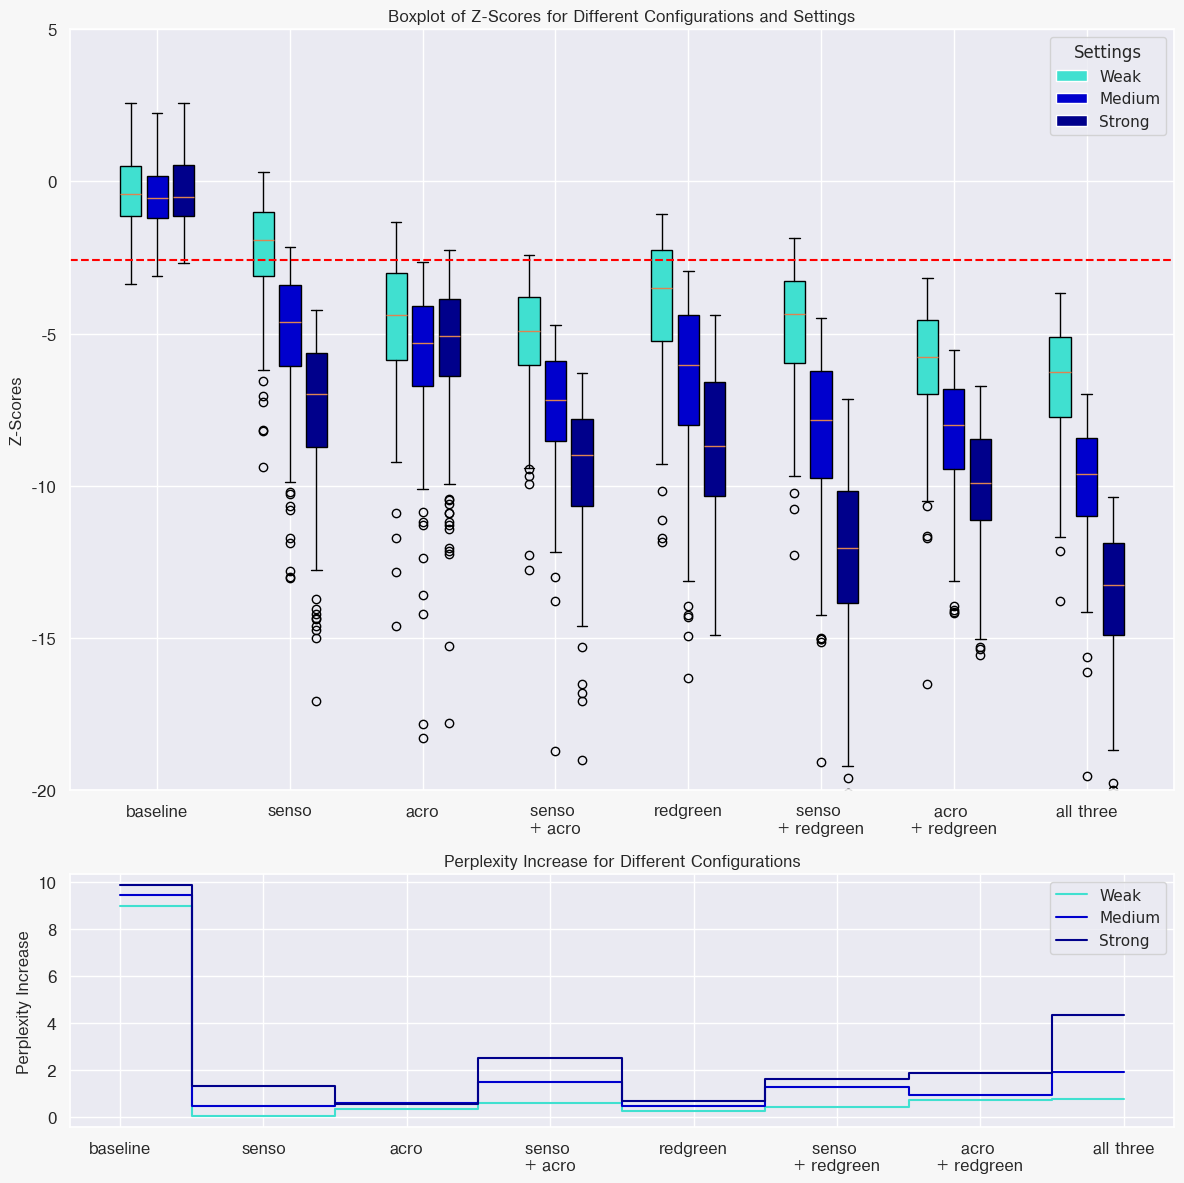

In [71]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm

# --------------------- Configuration --------------------- #

# Define the settings and their corresponding JSON files
settings = {
    "Weak": "detection_results_soft.json",
    "Medium": "detection_results_medium.json",
    "Strong": "detection_results_hard.json"
    # Add more settings and their JSON files here if needed
}

configuration_order = [
    "baseline", 
    "llm_senso_medium", 
    "llm_acro_medium", 
    "llm_both_medium", 
    "llm_redgreen_medium", 
    "llm_senso_redgreen_medium", 
    "llm_acro_redgreen_medium", 
    "llm_all_three_medium"
]
# Path to the Helvetica font file you added
font_path = '/home/feline/Helvetica.ttf'

# Mapping for renaming configurations
config_name_mapping = {
    "llm_senso_medium": "senso",
    "llm_acro_medium": "acro",
    "llm_both_medium": "senso \n+ acro",
    "llm_redgreen_medium": "redgreen",
    "llm_senso_redgreen_medium": "senso \n+ redgreen",
    "llm_acro_redgreen_medium": "acro \n+ redgreen",
    "llm_all_three_medium": "all three"
}
# Exclude baseline from perplexity plot
configurations_no_baseline = [config for config in config_name_mapping.keys() if config != 'llm_baseline']

# --------------------- Font Setup --------------------- #

# Create a font property object
helvetica_font = fm.FontProperties(fname=font_path)

# Add the font file to the list of fonts
fm.fontManager.addfont(font_path)
# Rebuild the font cache
fm._load_fontmanager(try_read_cache=False)

# --------------------- Visualization Functions --------------------- #

# Apply Seaborn theme and matplotlib settings
sns.set_theme()

# Apply the font properties to different elements in the plot
def apply_font_properties(ax, font_properties):
    # Set the font for the title, labels, and tick labels
    ax.set_title(ax.get_title(), fontproperties=font_properties)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_properties)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_properties)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_properties)

# Function to annotate plots
def annotate_plot(ax, config, setting, x_position, median_perp, percentage_below, ci_perp, ci_perc):
    """
    Adds annotations below each boxplot.
    """
    # Determine annotation position
    ylim = ax.get_ylim()
    y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1  # 10% below the minimum y
    
    # Format confidence intervals if available
    if not np.isnan(ci_perp[0]) and not np.isnan(ci_perp[1]):
        perp_ci_str = f"({ci_perp[0]:.3f}, {ci_perp[1]:.3f})"
    else:
        perp_ci_str = "(N/A)"
    
    if not np.isnan(ci_perc[0]) and not np.isnan(ci_perc[1]):
        perc_below_ci_str = f"({ci_perc[0]:.2f}%, {ci_perc[1]:.2f}%)"
    else:
        perc_below_ci_str = "(N/A)"
    
    # Add text annotation (including annotations for baseline, senso, acro, etc.)
    #ax.text(
    #    x_position, y_position,
    #    f'{setting}\nPerp Inc: {median_perp:.3f} {perp_ci_str}\nBelow: {percentage_below:.2f}% {perc_below_ci_str}',
    #    ha='center', va='top', fontsize=8
    #)

# Boxplots for z-scores with multiple settings
# Boxplots for z-scores with multiple settings
# Boxplots for z-scores with multiple settings
def plot_boxplots_z(z_scores, settings_dict, configurations, z_score_threshold, median_perplexity_increment, below_threshold_percentage, median_perplexity_increment_ci, below_threshold_percentage_ci):
    fig, (ax_boxplot, ax_line) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]})

    # Number of configurations and settings
    num_configs = len(configurations)
    num_settings = len(settings_dict)
    
    # Width of each box
    box_width = 0.2
    # Spacing between groups
    spacing = 1
    
    # Calculate positions for each box
    positions = []
    for i in range(num_configs):
        center = i * spacing
        for j in range(num_settings):
            pos = center - (box_width * (num_settings - 1) / 2) + j * box_width
            positions.append(pos)
    
    # Prepare data and labels
    data_to_plot = []
    labels = []
    for config in configurations:
        for setting in settings_dict.keys():
            data = z_scores[setting].get(config, [])
            data_to_plot.append(data)
            labels.append(config_name_mapping.get(config, config))
    
    # Plot boxplots
    box = ax_boxplot.boxplot(data_to_plot, positions=positions, widths=box_width*0.8, patch_artist=True, manage_ticks=False)
    
    # Define custom colors for different settings in the order Weak, Medium, Strong
    color_mapping = {
        "Weak": "turquoise",
        "Medium": "mediumblue",
        "Strong": "darkblue"
    }
    
    # Customize box colors based on settings
    for i, patch in enumerate(box['boxes']):
        setting = list(settings_dict.keys())[i % num_settings]
        patch.set_facecolor(color_mapping[setting])
    
    # Create custom legends
    from matplotlib.patches import Patch
    legend_patches = [Patch(facecolor=color_mapping[setting], label=setting) for setting in settings_dict]
    ax_boxplot.legend(handles=legend_patches, title='Settings')
    
    # Set x-ticks to be at the center of each group
    ax_boxplot.set_xticks([i * spacing for i in range(num_configs)])
    ax_boxplot.set_xticklabels([config_name_mapping.get(config, config) for config in configurations], rotation=0)
    
    ax_boxplot.set_ylabel('Z-Scores')
    ax_boxplot.set_title('Boxplot of Z-Scores for Different Configurations and Settings')
    
    # Set custom limits for the Z-scores y-axis
    ax_boxplot.set_ylim(-20, 5)

    # Draw a horizontal line at the z-score threshold
    ax_boxplot.axhline(y=z_score_threshold, color='red', linestyle='--', label=f'Z-Score Threshold = {z_score_threshold:.2f} (p = 0.005)')
    
    # Second plot: line plot of perplexity increase
    for setting in settings_dict.keys():
        perplexity_increments = [median_perplexity_increment[setting].get(config, 0 if config == 'baseline' else np.nan) for config in configurations]
        ax_line.step(np.arange(len(configurations)), perplexity_increments, where='mid', label=setting, color=color_mapping[setting])  # Removed marker='o'
    
    ax_line.set_xticks(np.arange(len(configurations)))
    ax_line.set_xticklabels([config_name_mapping.get(config, config) for config in configurations])
    ax_line.set_ylabel('Perplexity Increase')
    ax_line.set_title('Perplexity Increase for Different Configurations')
    ax_line.legend()
    
    # Apply font properties to both plots
    apply_font_properties(ax_boxplot, helvetica_font)
    apply_font_properties(ax_line, helvetica_font)

    fig.patch.set_facecolor('#f7f7f7')
    plt.tight_layout()
    plt.show()


# --------------------- Execute Plotting --------------------- #

# Plot Boxplots of Z-Scores with multiple settings and line plot for perplexity increase
plot_boxplots_z(
    z_scores, 
    settings, 
    configuration_order,  # Pass the custom configuration order
    z_score_threshold,
    median_perplexity_increment,
    below_threshold_percentage,
    median_perplexity_increment_ci,
    below_threshold_percentage_ci
)

In [117]:
import json
import numpy as np
from scipy.stats import norm
import pandas as pd
import os
import glob

# --------------------- Configuration --------------------- #

# List of JSON files to process
# You can specify the paths to your JSON files here. For example:
json_files = [
    'detection_results_soft.json',
    'detection_results_medium.json',
    'detection_results_hard.json',
    #'detection_results_mistral.json',
    #'detection_results_llama3b.json',
    # Add more JSON file paths as needed
]
json_files = [
    'attacked_results_soft.json',
    'attacked_results_medium.json',
    'attacked_results_hard.json',
    'attacked_results_mistral.json',
    'attacked_results_llama3b.json',
    # Add more JSON file paths as needed
]

# Z-score threshold
z_score_threshold = norm.ppf(0.005)  # Approximately -2.5758

# Mapping for renaming configurations
config_name_mapping = {
    "llm_senso_medium": "senso",
    "llm_acro_medium": "acro",
    "llm_both_medium": "senso + acro",
    "llm_redgreen_medium": "redgreen",
    "llm_senso_redgreen_medium": "senso + redgreen",
    "llm_acro_redgreen_medium": "acro + redgreen",
    "llm_all_three_medium": "all three"
    # Add more mappings here as needed
}

# --------------------- Helper Functions --------------------- #

def prob_to_z_score(prob):
    """
    Converts a probability to a z-score using the inverse CDF of the normal distribution.
    Handles edge cases where probability is 0 or 1.
    """
    if prob <= 0:
        prob = 1e-12  # A very small value close to 0
    elif prob >= 1:
        prob = 1 - 1e-12  # A very small value close to 1
    return norm.ppf(prob)

def remove_outliers(scores, perps):
    """
    Removes outliers based on the Interquartile Range (IQR) method.
    Applies the same mask to both scores and perplexities to maintain alignment.
    """
    if len(scores) < 4:
        return scores, perps
    q1, q3 = np.percentile(scores, [0, 100])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = [(x >= lower_bound) and (x <= upper_bound) for x in scores]
    filtered_scores = [x for x, m in zip(scores, mask) if m]
    filtered_perps = [x for x, m in zip(perps, mask) if m]
    return filtered_scores, filtered_perps

def process_json(file_path):
    """
    Processes a single JSON file and extracts the required metrics for each configuration.
    
    Returns:
        List of dictionaries containing metrics for each configuration.
    """
    results = []
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract all configurations
    all_configurations = list(data[0]['detection'].keys())
    
    # Check if 'llm_baseline' exists
    if 'llm_baseline' not in all_configurations:
        raise ValueError(f"Configuration 'llm_baseline' not found in the data of {file_path}.")
    
    # Separate 'llm_baseline' from other configurations
    configurations = [config for config in all_configurations if config != 'llm_baseline']
    
    # Initialize dictionaries to store data
    final_scores = {config: [] for config in configurations}
    perplexity_increments = {config: [] for config in configurations}
    
    # Collect all baseline perplexities to compute the median baseline
    baseline_perplexities = []
    
    for entry in data:
        detection = entry['detection']
        
        # Extract baseline perplexity
        try:
            baseline_perplexity = detection['llm_baseline']['perplexity']
            if not np.isnan(baseline_perplexity):
                baseline_perplexities.append(baseline_perplexity)
        except KeyError:
            print(f"Missing 'llm_baseline' perplexity in entry: {entry}")
            continue
        
        # Extract data for other configurations
        for config in configurations:
            try:
                final_score = detection[config]['final_score']
                perplexity = detection[config]['perplexity']
                
                # Only proceed if perplexity is not NaN
                if not np.isnan(perplexity):
                    # Compute perplexity increment
                    perplexity_increment = perplexity - baseline_perplexity
                    if (config == 'baseline'):
                        perplexity_increment = 0
                    perplexity_increments[config].append(perplexity_increment)
                    
                    # Append final_score
                    final_scores[config].append(final_score)
            except KeyError as e:
                print(f"Missing key {e} in configuration '{config}' for entry: {entry}")
                continue
    
    # Compute the median baseline perplexity
    if not baseline_perplexities:
        raise ValueError(f"No valid 'llm_baseline' perplexity values found in {file_path}.")
    
    median_baseline_perplexity = np.median(baseline_perplexities)
    
    # --------------------- Data Cleaning: Remove Outliers --------------------- #
    
    cleaned_final_scores = {}
    cleaned_perplexity_increments = {}
    for config in configurations:
        scores, perps = remove_outliers(final_scores[config], perplexity_increments[config])
        cleaned_final_scores[config] = scores
        cleaned_perplexity_increments[config] = perps
    
    # --------------------- Data Transformation: Convert to Z-Scores --------------------- #
    
    # Convert final_scores to z-scores
    z_scores = {config: [prob_to_z_score(score) for score in cleaned_final_scores[config]] for config in configurations}
    
    # --------------------- Statistical Calculations --------------------- #
    
    # Calculate median z-score for each configuration
    median_z_score = {config: np.median(z_scores[config]) for config in configurations}
    
    # Calculate median perplexity increment for each configuration
    median_perplexity_increment = {config: np.median(cleaned_perplexity_increments[config]) for config in configurations}
    
    # Calculate percentage of z-scores below the threshold for each configuration
    below_threshold_percentage = {
        config: (sum(z < z_score_threshold for z in z_scores[config]) / len(z_scores[config])) * 100
        for config in configurations
    }
    
    # --------------------- Compile Results --------------------- #
    
    for config in configurations:
        mapped_config = config_name_mapping.get(config, config)
        result = {
            'JSON File': os.path.basename(file_path),
            'Configuration': mapped_config,
            'Median Z-Score': median_z_score[config],
            'Median Perplexity Increase': median_perplexity_increment[config],
            'Below Threshold (%)': below_threshold_percentage[config]
        }
        results.append(result)
    
    return results

# --------------------- Main Execution --------------------- #

# Initialize a list to hold all results
all_results = []

# Process each JSON file
for json_file in json_files:
    if not os.path.isfile(json_file):
        print(f"File not found: {json_file}. Skipping.")
        continue
    try:
        file_results = process_json(json_file)
        all_results.extend(file_results)
    except Exception as e:
        print(f"Error processing {json_file}: {e}")

# Create a DataFrame from the results
df_results = pd.DataFrame(all_results)

# Optional: Sort the DataFrame for better readability
df_results = df_results.sort_values(by=['JSON File', 'Configuration']).reset_index(drop=True)

# Display the table
print(df_results)

# Optional: Save the table to a CSV file
output_csv = 'metrics_summary_attacked.csv'
df_results.to_csv(output_csv, index=False)
print(f"\nMetrics table saved to {output_csv}")


                        JSON File     Configuration  Median Z-Score  \
0      attacked_results_hard.json              acro       -1.323714   
1      attacked_results_hard.json   acro + redgreen       -3.108531   
2      attacked_results_hard.json         all three       -7.784409   
3      attacked_results_hard.json          baseline       -0.505418   
4      attacked_results_hard.json          redgreen       -2.496845   
5      attacked_results_hard.json             senso       -5.068725   
6      attacked_results_hard.json      senso + acro       -5.500230   
7      attacked_results_hard.json  senso + redgreen       -6.763244   
8   attacked_results_llama3b.json              acro       -1.110138   
9   attacked_results_llama3b.json   acro + redgreen       -3.703670   
10  attacked_results_llama3b.json         all three       -7.949510   
11  attacked_results_llama3b.json          baseline       -0.382447   
12  attacked_results_llama3b.json          redgreen       -2.945084   
13  at

Data Loaded Successfully:
                     JSON File    Configuration  Median Z-Score  \
0  detection_results_hard.json             acro       -4.276551   
1  detection_results_hard.json  acro + redgreen       -8.979504   
2  detection_results_hard.json        all three      -12.382357   
3  detection_results_hard.json         baseline       -0.500322   
4  detection_results_hard.json         redgreen       -7.307728   

   Median Perplexity Increase  Below Threshold (%)  
0                    0.277299            74.666667  
1                    1.681153            94.666667  
2                    3.586050            98.333333  
3                    0.000000             0.333333  
4                    1.072421            86.000000  


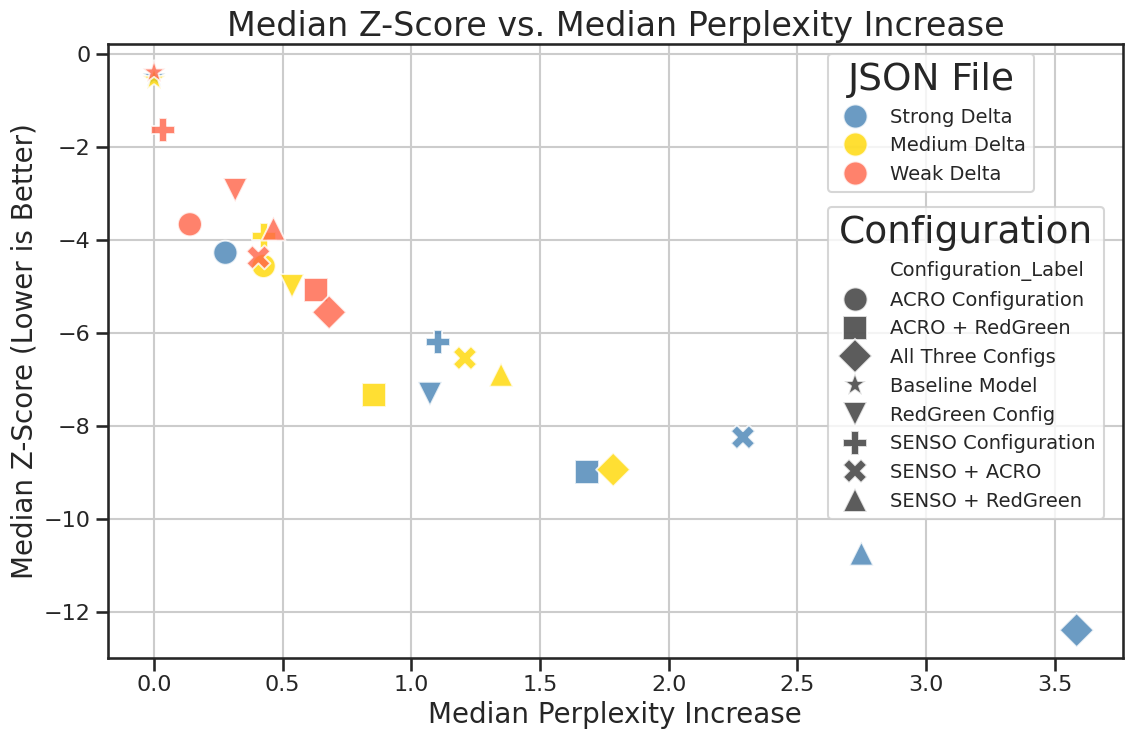

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# ----------------------------
# Step 1: Load the CSV Data
# ----------------------------

csv_file = 'metrics_summary.csv'
try:
    df = pd.read_csv(csv_file)
    print("Data Loaded Successfully:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
    sys.exit(1)
except pd.errors.EmptyDataError:
    print("Error: The CSV file is empty.")
    sys.exit(1)
except pd.errors.ParserError:
    print("Error: The CSV file is malformed.")
    sys.exit(1)

# ----------------------------
# Step 2: Define Customizations
# ----------------------------

# Updated: Define custom colors for JSON files
custom_colors = {
    'Strong Delta': '#4682B4',         # Dodger Blue
    'Medium Delta': '#FFD700',         # Orange Red
    'Weak Delta': '#FF6347',           # Lime Green
}

# Configuration labels remain the same
configuration_labels = {
    'acro': 'ACRO Configuration',
    'acro + redgreen': 'ACRO + RedGreen',
    'all three': 'All Three Configs',
    'baseline': 'Baseline Model',
    'redgreen': 'RedGreen Config',
    'senso': 'SENSO Configuration',
    'senso + acro': 'SENSO + ACRO',
    'senso + redgreen': 'SENSO + RedGreen',
}

# JSON file labels remain the same
jsonfile_labels = {
    'detection_results_hard.json': 'Strong Delta',
    'detection_results_medium.json': 'Medium Delta',
    'detection_results_soft.json': 'Weak Delta',
}

# Updated: Define custom markers for configurations
custom_markers = {
    'ACRO Configuration': 'o',          # Circle
    'ACRO + RedGreen': 's',             # Square
    'All Three Configs': 'D',           # Diamond
    'Baseline Model': '*',              # Star
    'RedGreen Config': 'v',             # Downward Triangle
    'SENSO Configuration': 'P',         # Plus
    'SENSO + ACRO': 'X',                # X
    'SENSO + RedGreen': '^',            # Upward Triangle
}

# ----------------------------
# Step 3: Prepare the Data for Plotting
# ----------------------------

df['Configuration_Label'] = df['Configuration'].map(configuration_labels).fillna(df['Configuration'])
df['JSON_File_Label'] = df['JSON File'].map(jsonfile_labels).fillna(df['JSON File'])

# ----------------------------
# Step 4: Validate Customizations
# ----------------------------

unique_configurations = df['Configuration_Label'].unique()
missing_markers = set(unique_configurations) - set(custom_markers.keys())
if missing_markers:
    print(f"Error: The custom_markers dictionary is missing markers for the following Configuration_Label(s): {missing_markers}")
    sys.exit(1)

unique_json_files = df['JSON_File_Label'].unique()
missing_colors = set(unique_json_files) - set(custom_colors.keys())
if missing_colors:
    print(f"Error: The custom_colors dictionary is missing colors for the following JSON_File_Label(s): {missing_colors}")
    sys.exit(1)

# ----------------------------
# Step 5: Define Plotting Function
# ----------------------------

def create_custom_scatter_plot(df, hue, style, title, xlabel, ylabel, palette=None, markers=None, 
                               hue_label='JSON File', style_label='Configuration'):
    plt.figure(figsize=(12, 8))
    
    # Make everything bigger
    plt.rcParams.update({'font.size': 18})   # Global font size for elements
    sns.set_context("talk", font_scale=1.5)  # Further increase the size for seaborn elements
    sns.set_style("ticks")
    scatter = sns.scatterplot(
        data=df,
        x='Median Perplexity Increase',
        #y='Below Threshold (%)',
        y='Median Z-Score',
        hue=hue,
        style=style,
        palette=palette,
        markers=markers,
        s=300,                               # Larger marker size
        edgecolor='w',
        alpha=0.8
    )
    
    plt.title(title, fontsize=24)            # Larger title font
    plt.xlabel(xlabel, fontsize=20)          # Larger axis label font
    plt.ylabel(ylabel, fontsize=20)
    
    # Increase size of tick labels
    scatter.tick_params(axis='both', which='major', labelsize=16)

    handles, labels = scatter.get_legend_handles_labels()
    
    # Number of unique hues and styles
    n_hue = len(palette) if palette else len(df[hue].unique())
    n_style = len(markers) if markers else len(df[style].unique())
    
    # Adjust legend handles
    hue_handles = handles[1:n_hue+1]
    hue_labels = labels[1:n_hue+1]
    style_handles = handles[n_hue+1:]
    style_labels = labels[n_hue+1:]
    
    # First legend for hue (JSON Files)
    first_legend = plt.legend(
        hue_handles, hue_labels, title=hue_label, bbox_to_anchor=(0.7, 1.0), loc='upper left', fontsize=14
    )
    plt.gca().add_artist(first_legend)
    plt.grid(True)
    
    # Second legend for style (Configurations)
    second_legend = plt.legend(
        style_handles, style_labels, title=style_label, bbox_to_anchor=(0.7, 0.75), loc='upper left', fontsize=14
    )
    
    plt.tight_layout()
    plt.show()

# ----------------------------
# Step 6: Create the Scatter Plot
# ----------------------------

create_custom_scatter_plot(
    df=df,
    hue='JSON_File_Label',                # Color represents JSON files
    style='Configuration_Label',          # Symbols represent configurations
    title='Median Z-Score vs. Median Perplexity Increase',
    xlabel='Median Perplexity Increase',
    ylabel='Median Z-Score (Lower is Better)',
    #ylabel='Detection Rate',
    palette=custom_colors,                # Colors for JSON files
    markers=custom_markers,               # Markers for configurations
    hue_label='JSON File',
    style_label='Configuration'
)


Data Loaded Successfully:
                     JSON File    Configuration  Median Z-Score  \
0  detection_results_hard.json             acro       -4.276551   
1  detection_results_hard.json  acro + redgreen       -8.979504   
2  detection_results_hard.json        all three      -12.382357   
3  detection_results_hard.json         baseline       -0.500322   
4  detection_results_hard.json         redgreen       -7.307728   

   Median Perplexity Increase  Below Threshold (%)  
0                    0.277299            74.666667  
1                    1.681153            94.666667  
2                    3.586050            98.333333  
3                    0.000000             0.333333  
4                    1.072421            86.000000  


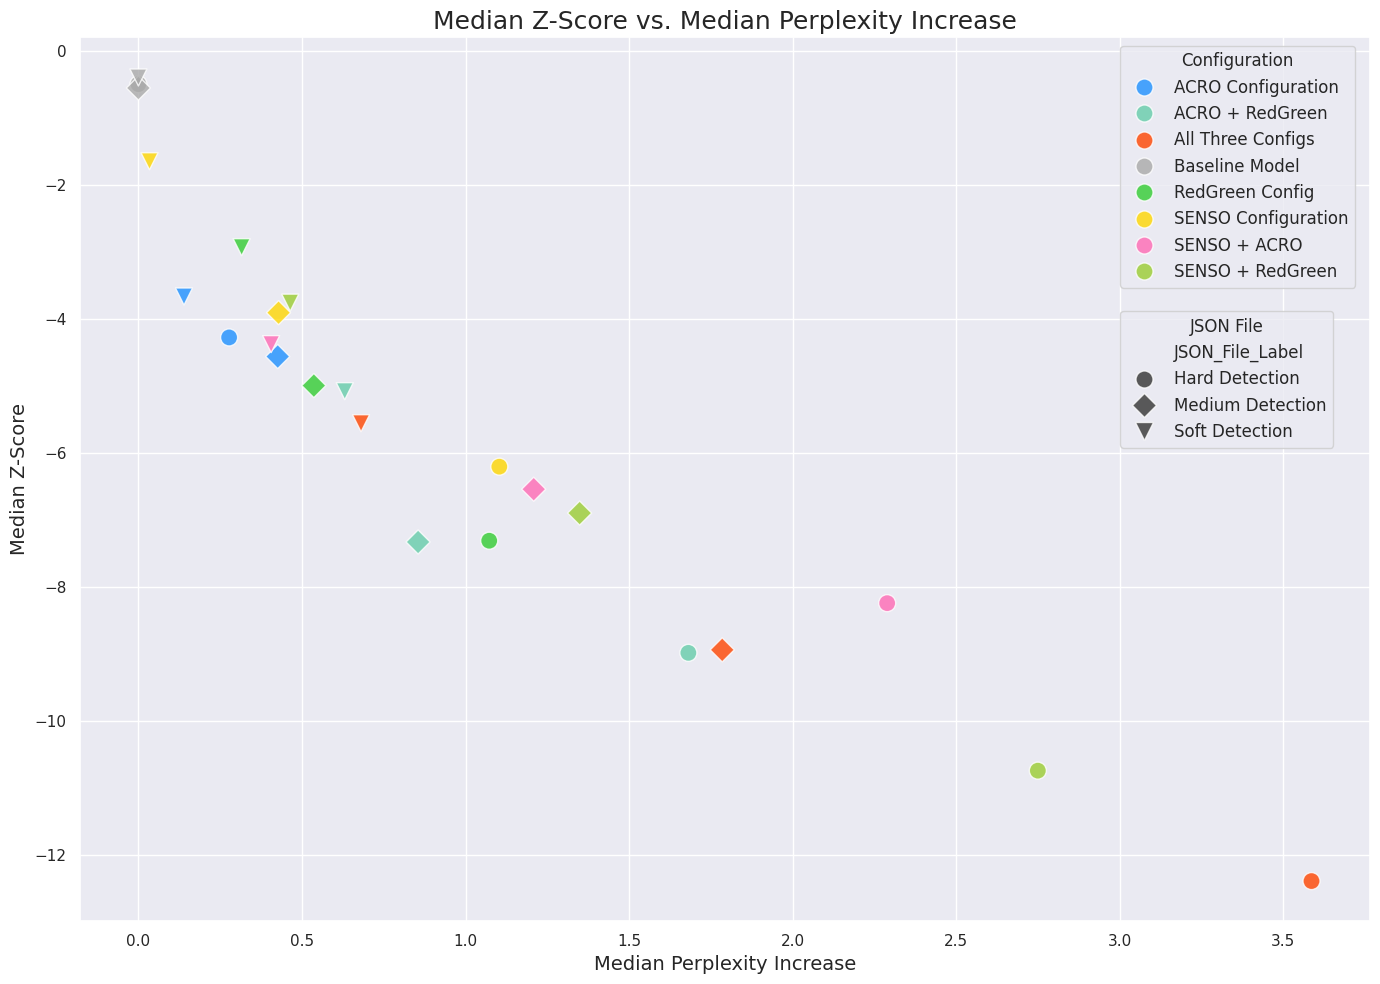

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# ----------------------------
# Step 1: Load the CSV Data
# ----------------------------

csv_file = 'metrics_summary.csv'
try:
    df = pd.read_csv(csv_file)
    print("Data Loaded Successfully:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
    sys.exit(1)
except pd.errors.EmptyDataError:
    print("Error: The CSV file is empty.")
    sys.exit(1)
except pd.errors.ParserError:
    print("Error: The CSV file is malformed.")
    sys.exit(1)

# ----------------------------
# Step 2: Define Customizations
# ----------------------------

custom_colors = {
    'ACRO Configuration': '#1E90FF',           # Orange Red
    'ACRO + RedGreen': '#66CDAA',              # Green
    'All Three Configs': '#FF4500',            # Blue
    'Baseline Model': '#A9A9A9',               # Gray
    'RedGreen Config': '#32CD32',              # Purple
    'SENSO Configuration': '#FFD700',          # Cyan
    'SENSO + ACRO': '#FF69B4',                 # Orange
    'SENSO + RedGreen': '#9ACD32',             # Lime
}

configuration_labels = {
    'acro': 'ACRO Configuration',
    'acro + redgreen': 'ACRO + RedGreen',
    'all three': 'All Three Configs',
    'baseline': 'Baseline Model',
    'redgreen': 'RedGreen Config',
    'senso': 'SENSO Configuration',
    'senso + acro': 'SENSO + ACRO',
    'senso + redgreen': 'SENSO + RedGreen',
}

jsonfile_labels = {
    'detection_results_hard.json': 'Hard Detection',
    'detection_results_llama3b.json': 'LLaMA 3B',
    'detection_results_medium.json': 'Medium Detection',
    'detection_results_mistral.json': 'Mistral Detection',
    'detection_results_soft.json': 'Soft Detection',
}

custom_markers = {
    'Hard Detection': 'o',      # Circle
    'LLaMA 3B': 's',            # Square
    'Medium Detection': 'D',    # Diamond
    'Mistral Detection': '^',   # Upward Triangle
    'Soft Detection': 'v',      # Downward Triangle
}

# ----------------------------
# Step 3: Prepare the Data for Plotting
# ----------------------------

df['Configuration_Label'] = df['Configuration'].map(configuration_labels).fillna(df['Configuration'])
df['JSON_File_Label'] = df['JSON File'].map(jsonfile_labels).fillna(df['JSON File'])

# ----------------------------
# Step 4: Validate Customizations
# ----------------------------

unique_configurations = df['Configuration_Label'].unique()
missing_colors = set(unique_configurations) - set(custom_colors.keys())
if missing_colors:
    print(f"Error: The custom_colors dictionary is missing colors for the following Configuration_Label(s): {missing_colors}")
    sys.exit(1)

unique_json_files = df['JSON_File_Label'].unique()
missing_markers = set(unique_json_files) - set(custom_markers.keys())
if missing_markers:
    print(f"Error: The custom_markers dictionary is missing markers for the following JSON_File_Label(s): {missing_markers}")
    sys.exit(1)

# ----------------------------
# Step 5: Define Plotting Function
# ----------------------------

def create_custom_scatter_plot(df, hue, style, title, xlabel, ylabel, palette=None, markers=None, 
                               hue_label='Configuration', style_label='JSON File'):
    plt.figure(figsize=(14, 10))
    scatter = sns.scatterplot(
        data=df,
        x='Median Perplexity Increase',
        y='Median Z-Score',
        hue=hue,
        style=style,
        palette=palette,
        markers=markers,
        s=150,
        edgecolor='w',
        alpha=0.8
    )
    
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    handles, labels = scatter.get_legend_handles_labels()
    
    n_hue = len(palette) if palette else len(df[hue].unique())
    n_style = len(markers) if markers else len(df[style].unique())
    
    hue_handles = handles[1:n_hue+1]
    hue_labels = labels[1:n_hue+1]
    style_handles = handles[n_hue+1:]
    style_labels = labels[n_hue+1:]
    
    first_legend = plt.legend(
        hue_handles, hue_labels, title=hue_label, bbox_to_anchor=(0.8, 1), loc='upper left', fontsize=12
    )
    plt.gca().add_artist(first_legend)
    
    second_legend = plt.legend(
        style_handles, style_labels, title=style_label, bbox_to_anchor=(0.8, 0.7), loc='upper left', fontsize=12
    )
    
    plt.tight_layout()
    plt.show()

# ----------------------------
# Step 6: Create the Scatter Plot
# ----------------------------

create_custom_scatter_plot(
    df=df,
    hue='Configuration_Label',
    style='JSON_File_Label',
    title='Median Z-Score vs. Median Perplexity Increase',
    xlabel='Median Perplexity Increase',
    ylabel='Median Z-Score',
    palette=custom_colors,
    markers=custom_markers,
    hue_label='Configuration',
    style_label='JSON File'
)

/tmp/ipykernel_2142153/3453546205.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = df.groupby(['LLM', 'Configuration', 'Num_Sentences']).apply(count_detections).reset_index()


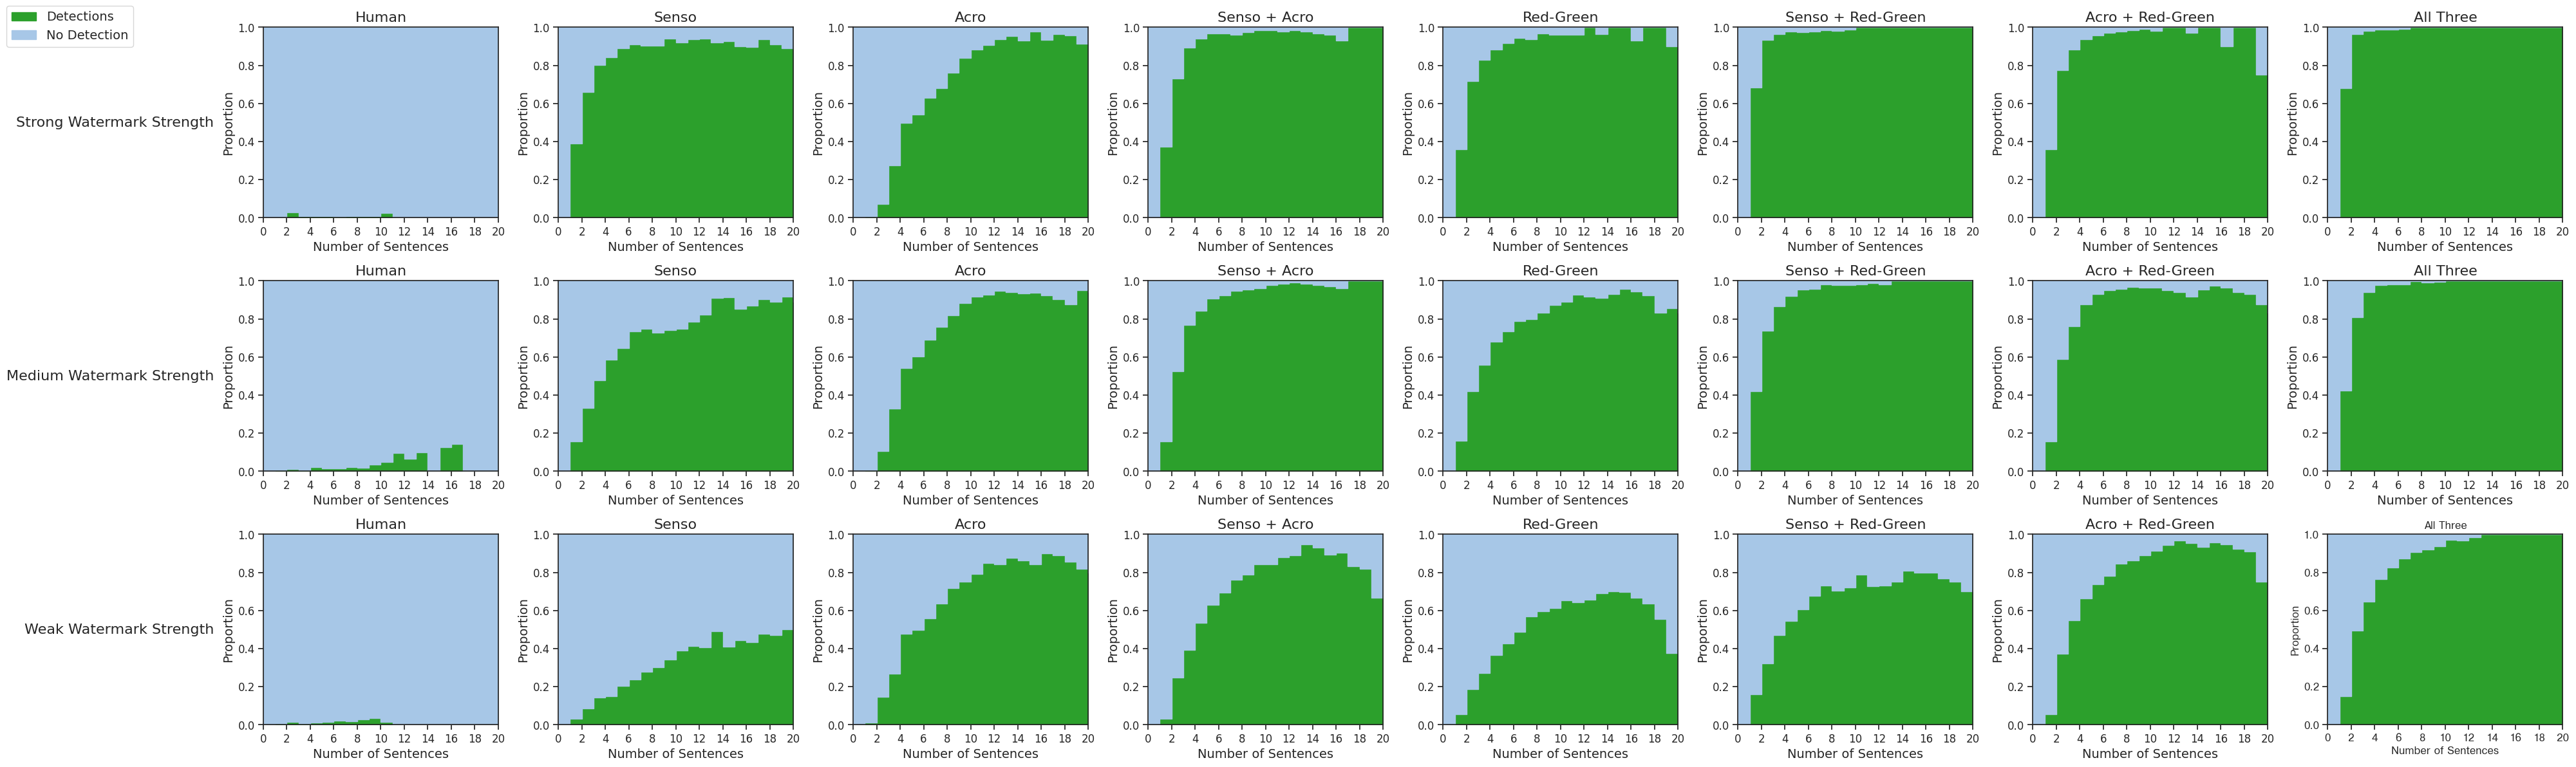

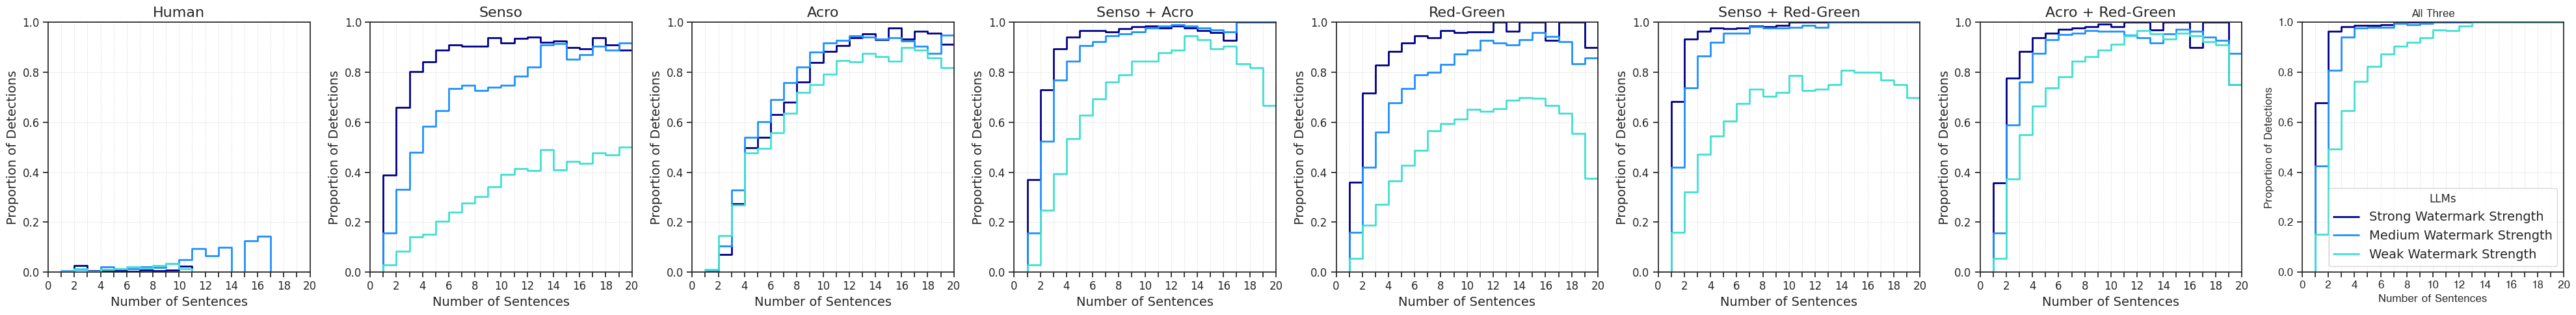

Number of samples per LLM:
LLM: Medium Watermark Strength, Samples: 909
LLM: Strong Watermark Strength, Samples: 909
LLM: Weak Watermark Strength, Samples: 909


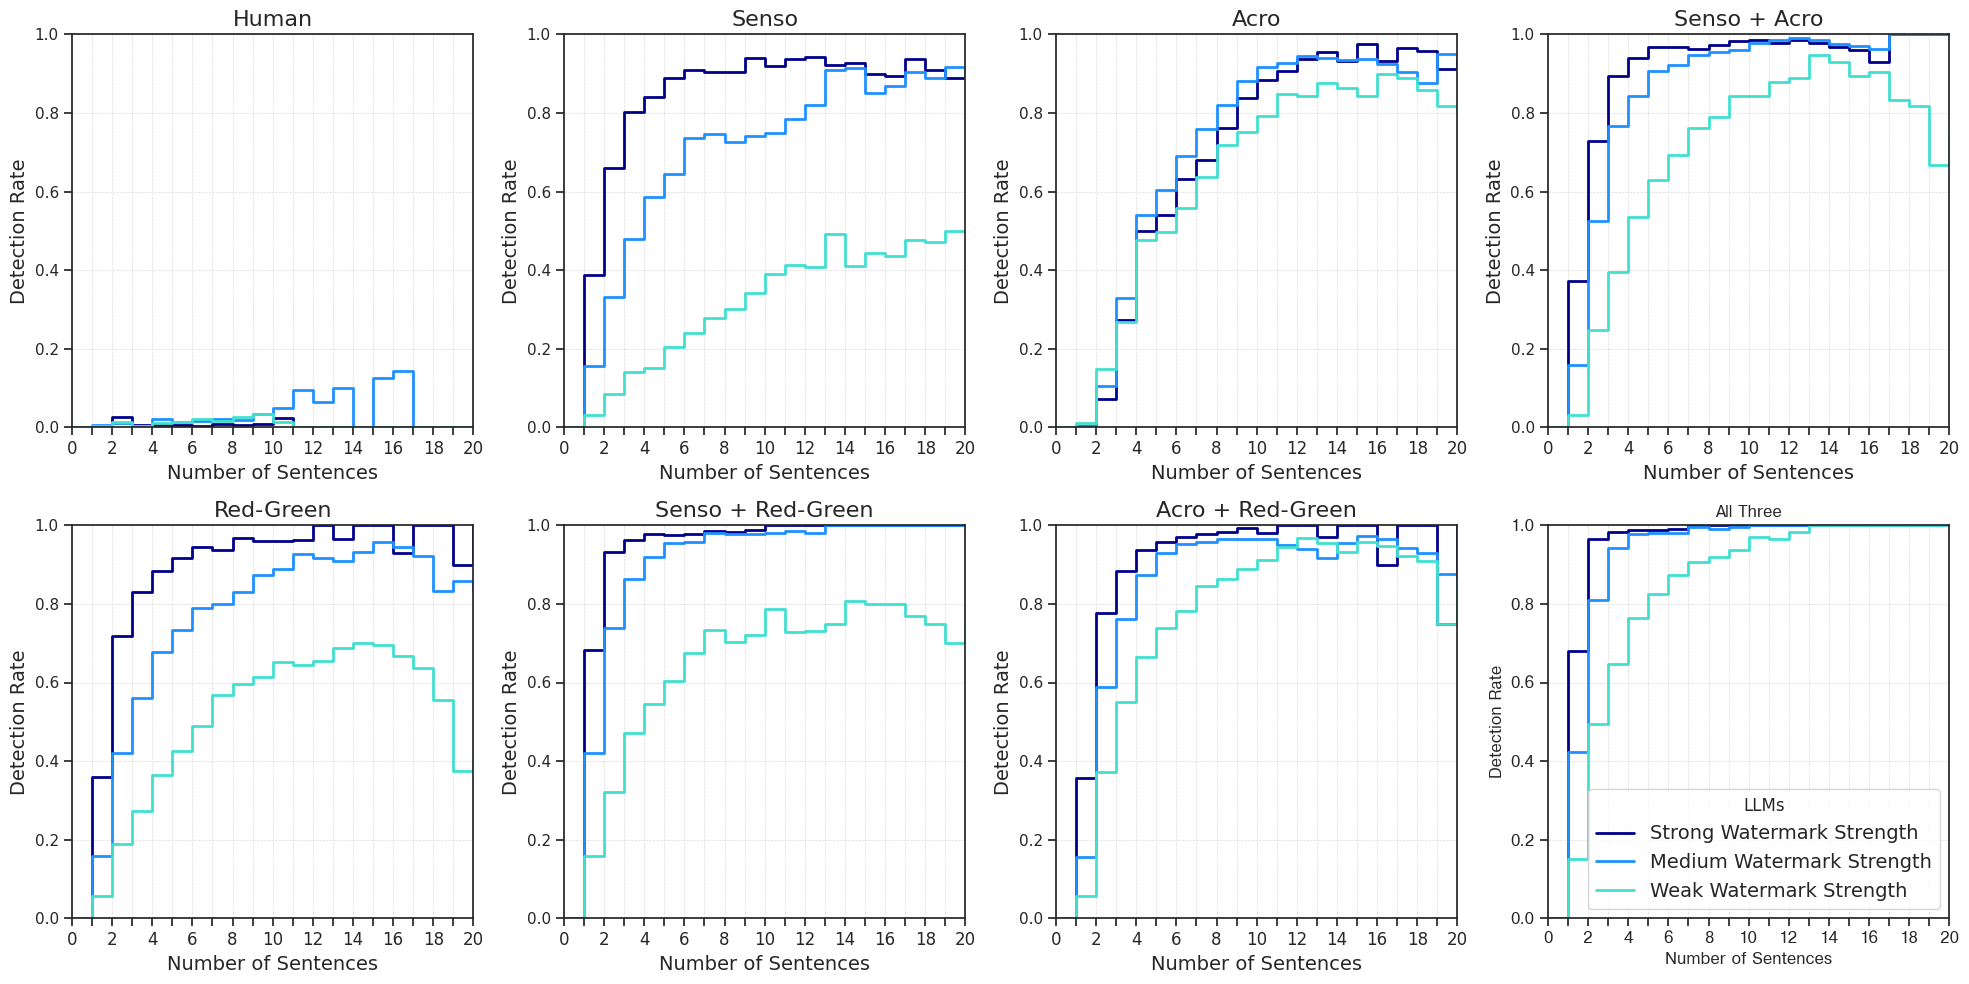

In [70]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import matplotlib.font_manager as fm

import os
os.chdir("/home/feline/master-generation")
sns.set_theme()
sns.set_style("ticks")

# Apply the font properties to different elements in the plot
def apply_font_properties(ax, font_properties):
    # Set the font for the title, labels, and tick labels
    ax.set_title(ax.get_title(), fontproperties=font_properties)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_properties)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_properties)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_properties)


def load_data(json_files):
    """
    Load data from a list of JSON files.

    Parameters:
        json_files (list): List of paths to JSON files.

    Returns:
        pd.DataFrame: DataFrame containing all the extracted data.
    """
    data_records = []
    
    for file in json_files:
        # Extract LLM name from filename (assuming filename is the LLM name)
        llm_name = os.path.splitext(os.path.basename(file))[0]
        
        with open(file, 'r') as f:
            try:
                json_data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {file}: {e}")
                continue
            
            for entry in json_data:
                prompt = entry.get("prompt", "")
                outputs = entry.get("outputs", {})
                detection = entry.get("detection", {})
                
                # Loop through each variant (or output) in detection
                for config, det in detection.items():
                    final_score = det.get("final_score", None)
                    num_sentences = det.get("num_sentences", None)
                    
                    if final_score is None or num_sentences is None:
                        continue  # Skip entries with missing data

                    # Strip variation suffix (e.g., "_variation_1") to group under the same configuration
                    base_config = config.split("_variation")[0]
                    
                    data_records.append({
                        "LLM": llm_name,
                        "Configuration": base_config,  # Use base configuration name
                        "Final_Score": final_score,
                        "Num_Sentences": num_sentences
                    })
                    
    df = pd.DataFrame(data_records)
    return df

def compute_detections(df, p=0.005):
    """
    Compute z-scores and determine detections based on threshold.
    For 'baseline', detection is successful if z_score > z_threshold.
    For others, detection is successful if z_score < z_threshold.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Final_Score' and 'Configuration'.
        p (float): Probability threshold for detection.

    Returns:
        pd.DataFrame: DataFrame with an additional 'Detection' column.
    """
    # Calculate z_threshold using the probability p (one-tailed)
    z_threshold = norm.ppf(p)
    
    # Compute z-scores using norm.ppf(final_score)
    # Handle final_score values that are exactly 0 or 1 to avoid -inf or inf
    df = df.copy()
    df['Final_Score_Clipped'] = df['Final_Score'].clip(lower=1e-10, upper=1 - 1e-10)
    df['Z_Score'] = norm.ppf(df['Final_Score_Clipped'])
    
    # Determine detections
    # For 'baseline', Detection is True if Z_Score > z_threshold
    # For others, Detection is True if Z_Score < z_threshold
    df['Detection'] = (
        ((df['Configuration'] == 'baseline') & (df['Z_Score'] < z_threshold)) |
        ((df['Configuration'] != 'baseline') & (df['Z_Score'] < z_threshold))
    )
    
    return df

def aggregate_data(df):
    """
    Aggregate data to count detections and failures.

    Parameters:
        df (pd.DataFrame): DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Detection'.

    Returns:
        pd.DataFrame: Aggregated DataFrame with counts.
    """
    # Define a function to count detections and failures
    def count_detections(group):
        detections = group['Detection'].sum()
        failures = (~group['Detection']).sum()
        return pd.Series({
            'Detections': detections,
            'Failures': failures
        })
    
    agg_df = df.groupby(['LLM', 'Configuration', 'Num_Sentences']).apply(count_detections).reset_index()
    return agg_df

def prepare_plot_data(agg_df):
    """
    Prepare data for plotting by ensuring all Num_Sentences are present for each LLM and Configuration.

    Parameters:
        agg_df (pd.DataFrame): Aggregated DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Detections', 'Failures'.

    Returns:
        pd.DataFrame: Prepared DataFrame with proportions.
        np.array: Sorted array of all number of sentences.
    """
    # Get all unique number of sentences
    all_num_sentences = agg_df['Num_Sentences'].unique()
    all_num_sentences = np.sort(all_num_sentences)
    
    # Get all unique LLMs and Configurations
    llms = agg_df['LLM'].unique()
    configurations = agg_df['Configuration'].unique()
    
    # Create a MultiIndex of all possible combinations
    index = pd.MultiIndex.from_product(
        [llms, configurations, all_num_sentences],
        names=['LLM', 'Configuration', 'Num_Sentences']
    )
    
    # Reindex the aggregated DataFrame to include all combinations
    agg_df_full = agg_df.set_index(['LLM', 'Configuration', 'Num_Sentences']).reindex(index, fill_value=0).reset_index()
    
    # Wherever there was no data (Detections=0 and Failures=0), set Detections=1 and Failures=0 (full success)
    mask_no_data = (agg_df_full['Detections'] == 0) & (agg_df_full['Failures'] == 0)
    agg_df_full.loc[mask_no_data, 'Detections'] = 0
    agg_df_full.loc[mask_no_data, 'Failures'] = 1
    
    # Calculate total and proportions
    agg_df_full['Total'] = agg_df_full['Detections'] + agg_df_full['Failures']
    agg_df_full['Proportion_Detections'] = agg_df_full['Detections'] / agg_df_full['Total']
    agg_df_full['Proportion_Failures'] = agg_df_full['Failures'] / agg_df_full['Total']
    
    return agg_df_full, all_num_sentences

def plot_data(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as a grid of stacked bar-like area charts with rectangular areas, ordered by custom configuration names.

    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections', 'Proportion_Failures'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Mapping for renaming configurations
   # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "Human",
        "llm_senso_medium": "Senso",
        "llm_acro_medium": "Acro",
        "llm_both_medium": "Senso + Acro",
        "llm_redgreen_medium": "Red-Green",
        "llm_senso_redgreen_medium" : "Senso + Red-Green",
        "llm_acro_redgreen_medium": "Acro + Red-Green",
        "llm_all_three_medium": "All Three"
    }
    
    # Desired order for configurations
    desired_order = [
        "Human", 
        "Senso", 
        "Acro", 
        "Senso + Acro", 
        "Red-Green", 
        "Senso + Red-Green", 
        "Acro + Red-Green", 
        "All Three"
    ]
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs using the provided llm_name_mapping dictionary
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique LLMs and configurations after renaming and reordering
    llms = agg_df_full['LLM'].unique()
    configurations = desired_order  # Now use the desired custom order for plotting
    
    num_llms = len(llms)
    num_configs = len(configurations)
    
    # Define figure size dynamically
    fig_width = 5 * num_configs
    fig_height = 4 * num_llms
    fig, axes = plt.subplots(nrows=num_llms, ncols=num_configs, figsize=(fig_width, fig_height))

    
    # Define a color palette
    colors = ['#2ca02c', '#A7C7E7']  # Green and Orange for Detections and Failures
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12

    
    for i, llm in enumerate(llms):
        for j, config in enumerate(configurations):
            ax = axes[i, j]
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                ax.set_visible(False)
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            failures = subset['Proportion_Failures']
            
            # Create bar-like stacked areas using fill_between for rectangular shapes
            ax.fill_between(x, 0, detections, step='post', color=colors[0], label='Detections')
            ax.fill_between(x, detections, 1, step='post', color=colors[1], label='No Detection')
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Proportion', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set larger tick sizes
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)
            
            # Adjust x-axis ticks to avoid crowding
            if len(x) > 10:  # Show every other label if there are more than 10 x-ticks
                ax.set_xticks(x[::2])
            else:
                ax.set_xticks(x)
            ax.set_xticklabels(ax.get_xticks(), fontsize=tick_fontsize)  # No rotation

            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title (no LLM name)
            ax.set_title(config, fontsize=title_fontsize)
    
        # Add LLM name to the left of each row
        
        axes[i, 0].annotate(llm, xy=(0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad - 5, 0),
                            xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                            size=title_fontsize, ha='right', va='center')

    # Add common legend to the top-left of the figure
    handles, labels = ax.get_legend_handles_labels()

    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'

    # Create a font property object
    helvetica_font = fm.FontProperties(fname=font_path)

    # Add the font file to the list of fonts
    fm.fontManager.addfont(font_path)
    # Rebuild the font cache
    fm._load_fontmanager(try_read_cache=False)

    
    # Apply Seaborn theme and matplotlib settings
    #sns.set_theme()
    apply_font_properties(ax, helvetica_font)
    plt.grid(True)
    #fig.patch.set_facecolor('#f7f7f7')
    fig.legend(handles, labels, loc='upper left', fontsize=label_fontsize)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Adjust left margin to fit LLM labels
    plt.show()

def plot_blocky_lines(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as blocky line charts in a single row with multiple columns for each configuration.
    Colors indicate the strength of the LLMs, ranging from dark blue (strong) to turquoise (weak).
    The x-axis for 'Num_Sentences' is restricted to whole numbers only.
    
    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Mapping for renaming configurations
    # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "Human",
        "llm_senso_medium": "Senso",
        "llm_acro_medium": "Acro",
        "llm_both_medium": "Senso + Acro",
        "llm_redgreen_medium": "Red-Green",
        "llm_senso_redgreen_medium" : "Senso + Red-Green",
        "llm_acro_redgreen_medium": "Acro + Red-Green",
        "llm_all_three_medium": "All Three"
    }
    
    # Desired order for configurations
    desired_order = [
        "Human", 
        "Senso", 
        "Acro", 
        "Senso + Acro", 
        "Red-Green", 
        "Senso + Red-Green", 
        "Acro + Red-Green", 
        "All Three"
    ]
    
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique configurations after renaming and reordering
    configurations = desired_order
    llms = agg_df_full['LLM'].unique()
    
    num_configs = len(configurations)
    
    # Define figure size for 8 columns (one row)
    fig_width = 5 * num_configs  # Adjust width for the number of configurations
    fig_height = 5  # One row for all configurations
    fig, axes = plt.subplots(1, num_configs, figsize=(fig_width, fig_height), squeeze=False)
    
    # Define a color palette based on strength: weak (turquoise), medium (medium blue), strong (dark blue)
    strength_colors = {
        "Weak Watermark Strength": "#40E0D0",    # Turquoise
        "Medium Watermark Strength": "#1E90FF",  # DodgerBlue
        "Strong Watermark Strength": "#00008B"   # DarkBlue
    }
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12
    
    for j, config in enumerate(configurations):
        ax = axes[0, j]  # Access columns (1 row, jth column)
        
        for i, llm in enumerate(llms):
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            # Ensure Num_Sentences are whole numbers by rounding to nearest integer
            subset['Num_Sentences'] = subset['Num_Sentences'].round().astype(int)
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            
            # Choose the color based on the strength of the LLM
            color = strength_colors.get(llm, "#808080")  # Default to gray if no matching color
            
            # Create blocky line plots using step function
            ax.step(x, detections, where='post', color=color, label=llm, linewidth=2)
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Proportion of Detections', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set larger tick sizes and force whole number x-ticks
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)
            # Set x-ticks to only display 0, 5, 10, and 20, with markers in between
            ax.set_xticks(np.arange(0, 21, 1))  # Ticks for all integers from 0 to 20
            ax.set_xticklabels([0, "", 2, "", 4, "", 6, "", 8, "", 10, "", 12, "", 14, "",16,"",18, "", 20], fontsize=tick_fontsize)  # Labels only for 0, 5, 10, 20
            
            
            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title
            ax.set_title(config, fontsize=title_fontsize)
    
    # Add common legend for the LLMs
    ax.legend(title="LLMs", fontsize=label_fontsize)
    
    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'
    helvetica_font = fm.FontProperties(fname=font_path)
    fm.fontManager.addfont(font_path)
    fm._load_fontmanager(try_read_cache=False)

    #sns.set_theme()
    apply_font_properties(ax, helvetica_font)
    plt.grid(True)
    #fig.patch.set_facecolor('#f7f7f7')
    
    plt.tight_layout()
    plt.show()


def plot_blocky_lines2(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as blocky line charts with 4 plots in the first row and 4 plots in the second row.
    Colors indicate the strength of the LLMs, ranging from dark blue (strong) to turquoise (weak).
    The x-axis for 'Num_Sentences' shows labels only for 0, 5, 10, and 20 with markers in between.
    Prints the number of samples for each LLM before plotting.
    
    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Print the number of samples for each LLM
    llm_sample_counts = agg_df_full.groupby('LLM').size()
    print("Number of samples per LLM:")
    for llm, count in llm_sample_counts.items():
        print(f"LLM: {llm}, Samples: {count}")
    
    # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "Human",
        "llm_senso_medium": "Senso",
        "llm_acro_medium": "Acro",
        "llm_both_medium": "Senso + Acro",
        "llm_redgreen_medium": "Red-Green",
        "llm_senso_redgreen_medium" : "Senso + Red-Green",
        "llm_acro_redgreen_medium": "Acro + Red-Green",
        "llm_all_three_medium": "All Three"
    }
    
    # Desired order for configurations
    desired_order = [
        "Human", 
        "Senso", 
        "Acro", 
        "Senso + Acro", 
        "Red-Green", 
        "Senso + Red-Green", 
        "Acro + Red-Green", 
        "All Three"
    ]
    
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique configurations after renaming and reordering
    configurations = desired_order
    llms = agg_df_full['LLM'].unique()
    
    num_configs = len(configurations)
    
    # Define figure size for 4 plots per row, and 2 rows
    fig_width = 20  # 5 units width per plot, for 4 plots
    fig_height = 10  # 5 units height per row, for 2 rows
    fig, axes = plt.subplots(2, 4, figsize=(fig_width, fig_height), squeeze=False)  # 2 rows, 4 columns
    
    # Define a color palette based on strength: weak (turquoise), medium (medium blue), strong (dark blue)
    strength_colors = {
        "Weak Watermark Strength": "#40E0D0",    # Turquoise
        "Medium Watermark Strength": "#1E90FF",  # DodgerBlue
        "Strong Watermark Strength": "#00008B"   # DarkBlue
    }
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12
    
    for index, config in enumerate(configurations):
        row = index // 4  # Determine row based on index (0-3 for first row, 4-7 for second row)
        col = index % 4   # Determine column within the row
        
        ax = axes[row, col]  # Access the appropriate subplot in the 2x4 grid
        
        for i, llm in enumerate(llms):
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            # Ensure Num_Sentences are whole numbers by rounding to nearest integer
            subset['Num_Sentences'] = subset['Num_Sentences'].round().astype(int)
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            
            # Choose the color based on the strength of the LLM
            color = strength_colors.get(llm, "#808080")  # Default to gray if no matching color
            
            # Create blocky line plots using step function
            ax.step(x, detections, where='post', color=color, label=llm, linewidth=2)
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Detection Rate', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set x-ticks to only display 0, 5, 10, and 20, with markers in between
            ax.set_xticks(np.arange(0, 21, 1))  # Ticks for all integers from 0 to 20
            ax.set_xticklabels([0, "", 2, "", 4, "", 6, "", 8, "", 10, "", 12, "", 14, "",16,"",18, "", 20], fontsize=tick_fontsize)  # Labels only for 0, 5, 10, 20
            
            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title
            ax.set_title(config, fontsize=title_fontsize)
    
    # Add common legend for the LLMs
    ax.legend(title="LLMs", fontsize=label_fontsize)
    
    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'
    helvetica_font = fm.FontProperties(fname=font_path)
    fm.fontManager.addfont(font_path)
    fm._load_fontmanager(try_read_cache=False)

    
    apply_font_properties(ax, helvetica_font)
    plt.grid(True)
    #fig.patch.set_facecolor('#f7f7f7')
    
    plt.tight_layout()
    plt.show()


def main():
    # Define the list of JSON files
    # You can modify this list or use glob to dynamically find JSON files
    json_files = [
        'reduce_sentences_detection_results_medium.json',
        'reduce_sentences_detection_results_hard.json',
        'reduce_sentences_detection_results_soft.json',
        # Add more JSON file paths as needed
    ]
    
    # Optionally, use glob to find all JSON files in a directory
    # json_files = glob.glob('path/to/json/files/*.json')
    
    # Load data
    df = load_data(json_files)
    
    if df.empty:
        print("No data loaded. Please check your JSON files.")
        return
    
    # Compute detections
    df = compute_detections(df, p=0.005)
    
    # Aggregate data
    agg_df = aggregate_data(df)
    
    # Prepare data for plotting
    agg_df_full, all_num_sentences = prepare_plot_data(agg_df)
    
    # Plot data
    plot_data(agg_df_full, all_num_sentences)
    plot_blocky_lines(agg_df_full, all_num_sentences)
    plot_blocky_lines2(agg_df_full, all_num_sentences)

if __name__ == "__main__":
    main()


In [19]:
import os
import json
import spacy
import hashlib
from scipy.stats import norm, binom
import math
import pandas as pd
import modules.shared as shared  # Ensure this path is correct
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the working directory
os.chdir("/home/feline/master-generation")

# -----------------------------------
# 1. Load SpaCy English model
# -----------------------------------
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    raise OSError("SpaCy model 'en_core_web_sm' not found. Please install it using:\n"
                  "python -m spacy download en_core_web_sm")

# -----------------------------------
# 2. Load Sensorimotor Norms Data
# -----------------------------------
# Ensure the CSV file 'updated_word_frequencies_with_percent.csv' is in the working directory
try:
    df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
except FileNotFoundError:
    raise FileNotFoundError("The file 'updated_word_frequencies_with_percent.csv' was not found. "
                            "Please ensure it is present in the working directory.")

# Populate shared.sensorimotor as a dictionary with uppercase words as keys
shared.sensorimotor = df.set_index('Word').T.to_dict('dict')

# -----------------------------------
# 3. Define Sensorimotor Classes and Statistics
# -----------------------------------
classes_mean = [
    'Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean',
    'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean',
    'Head.mean', 'Mouth.mean', 'Torso.mean'
]
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']

# Define mean and standard deviation for each sensorimotor class
mean_value = [1.51, 0.32, 1.07, 1.03, 0.39, 2.90, 0.81, 1.45, 2.28, 1.26, 0.82]
std_deviation = [0.99, 0.70, 0.93, 0.88, 0.62, 0.90, 0.75, 0.91, 0.72, 0.90, 0.67]

# Initialize secret key
shared.secret_key = [0, 0]  # [sensorimotor_class, acrostic_letter]

# -----------------------------------
# 4. Compute Baseline Probabilities
# -----------------------------------
def compute_p_class(df, classes):
    """
    Computes the baseline probability for each sensorimotor class based on Word_Percent.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing sensorimotor norms with 'Dominant.sensorimotor' and 'Word_Percent' columns.
    - classes (List[str]): List of sensorimotor classes.
    
    Returns:
    - dict: A dictionary mapping each class to its baseline probability.
    """
    p_class_dict = {}
    total_word_percent = df['Word_Percent'].sum()
    print(f"Total Word_Percent: {total_word_percent}")
    
    llm_baseline = {
        "Auditory": 0.1794,
        "Gustatory": 0.0025,
        "Haptic": 0.0056,
        "Interoceptive": 0.0186,
        "Olfactory": 0.0014,
        "Visual": 0.4659,
        "Foot_leg": 0.0175,
        "Hand_arm": 0.0231,
        "Head":  0.2735,
        "Mouth": 0.0090,
        "Torso": 0.0034
    }
    for cls in classes:
        # Sum Word_Percent for words where Dominant.sensorimotor == cls
        class_word_percent = df[df['Dominant.sensorimotor'] == cls]['Word_Percent'].sum()
        p = class_word_percent / total_word_percent if total_word_percent > 0 else 0.0

        #change from goole ngrams to my own stats:
        #p = llm_baseline.get(cls, 0.0)
        #p_class_dict[cls] = p
        
        print(f"Class: {cls}, Word_Percent Sum: {class_word_percent}, p_class: {p:.6f}")
    
    return p_class_dict

p_class_dict = compute_p_class(df, shared.classes)

# -----------------------------------
# 5. Utility Functions
# -----------------------------------
def split_into_sentences(text):
    """
    Splits the input text into sentences using SpaCy's sentence segmentation.
    
    Parameters:
    - text (str): The text to split.
    
    Returns:
    - List[str]: A list of sentences.
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    """
    Extracts words from a sentence, excluding punctuation and spaces.
    
    Parameters:
    - sentence (str): The sentence to process.
    
    Returns:
    - List[str]: A list of words.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

def secure_hash_for_word(word, range_min, range_max):
    """
    Generates a secure hash for a word and maps it to a number within a specified range.
    
    Parameters:
    - word (str): The word to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    hashed_word_bytes = hashlib.sha256(word.encode()).digest()
    hashed_word_int = int.from_bytes(hashed_word_bytes[:4], byteorder='big')
    mapped_number = (hashed_word_int % (range_max - range_min + 1)) + range_min
    return mapped_number

def secure_hash_for_sentence(sentence, range_min, range_max):
    """
    Generates a secure hash for a sentence (lemmatized, excluding stopwords and punctuation)
    and maps it to a number within a specified range.
    
    Parameters:
    - sentence (str): The sentence to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    doc = nlp(sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_int = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    mapped_number = (hashed_sentence_int % (range_max - range_min + 1)) + range_min
    return mapped_number

# -----------------------------------
# 6. Load the OPT-2.7B Model for Perplexity Calculation
# -----------------------------------
print("\nLoading OPT-2.7B model for perplexity calculation...")
try:
    tokenizer_opt = shared.model#AutoTokenizer.from_pretrained("facebook/opt-2.7b")
    model_opt = shared.tokenizer#AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
    #model_opt.eval()
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model_opt.to(device)
    #print(f"Model loaded successfully on {device}.")
except Exception as e:
    raise RuntimeError(f"Failed to load OPT-2.7B model: {e}")

# -----------------------------------
# 7. Probability Calculation Function (Updated)
# -----------------------------------
def calculate_probs(reply):
    """
    Calculates the watermark probabilities for a given text reply.

    This function evaluates the sensorimotor, acrostic, and redgreen watermark features
    to determine the likelihood that the text contains a watermark.

    Parameters:
    - reply (str): The text to analyze.

    Returns:
    - Tuple containing:
        - final_score (float): Combined probability indicating watermark presence.
        - acrostic_prob (float): Probability from acrostic feature using binomial PMF.
        - sensorimotor_prob (float): Probability from sensorimotor feature.
        - redgreen_z_score (float): Z-score from redgreen watermark detection.
        - len(sentences) (int): Total number of sentences in the text.
        - correct_acrosticons (int): Number of sentences with correct acrostic.
        - total_words (int): Total number of words processed.
        - correct_words (int): Number of words matching sensorimotor class.
        - sensorimotor_matches (int): Number of sensorimotor matches across all classes.
        - sensorimotor_matches_per_class (dict): Number of matches per sensorimotor class.
    """
    # Reset the secret key to initial value for each analysis
    shared.secret_key = [0, 0]

    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    sensorimotor_matches = 0
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    total_words = 0
    correct_words = 0

    # Tokenize the reply using the same tokenizer used in generation
    tokenizer = shared.tokenizer  # Ensure shared.tokenizer is defined and is the same as used in generation
    tokens = tokenizer.encode(reply, add_special_tokens=False)
    vocab_size = len(tokenizer)

    # Variables for redgreen watermark detection
    gamma = 0.5  # Proportion of green list used during generation
    in_green_list = 0  # Number of tokens in the green list
    T = len(tokens) - 1  # Number of transitions (from token i to token i+1)

    # Split the text into sentences
    sentences = split_into_sentences(reply)
    sensorimotor_class = shared.secret_key[0]
    token_idx = 0  # Index to keep track of token positions

    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue  # Skip empty sentences

        for word_idx, word in enumerate(words):
            total_words += 1

            if word_idx == 0 and idx > 1:
                # For the first word of each sentence (excluding the first sentence), check acrostic
                expected_start = chr(ord('A') + (shared.secret_key[1] % 26))
                actual_start = word[0].strip().upper()
                if actual_start == expected_start:
                    correct_acrosticons += 1

            else:# Retrieve current sensorimotor class from the key
                if 0 <= sensorimotor_class < len(shared.classes):
                    selected_class_mean = classes_mean[sensorimotor_class]
                    selected_class = shared.classes[sensorimotor_class]
                    word_upper = word.strip().upper()

                    if word_upper in shared.sensorimotor:
                        # Check if the word's dominant sensorimotor class matches the selected class
                        if shared.sensorimotor[word_upper]["Dominant.sensorimotor"] == selected_class:
                            sensorimotor_matches_per_class[selected_class] += 1
                            sensorimotor_matches += 1
                        word_mean = shared.sensorimotor[word_upper][selected_class_mean]
                        word_z = (word_mean - mean_value[sensorimotor_class]) / std_deviation[sensorimotor_class]
                        word_prob = 1 - norm.cdf(word_z)

                        # Accumulate z-scores and probabilities
                        z_scores.append(word_z)
                        probabilities.append(word_prob)
                        correct_words += 1
                        sensorimotor_total_per_class[selected_class] += 1
                    else:
                        # Word not found in sensorimotor dictionary; optionally handle or skip
                        pass
                else:
                    # Invalid sensorimotor class; optionally handle or assign default probability
                    pass

            # Update sensorimotor key based on the current word for the next word's class
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            sensorimotor_class = shared.secret_key[0]
            shared.secret_key[0] = sensorimotor_hash

            # Redgreen Watermark Detection
            if token_idx < T:
                last_token = tokens[token_idx]
                current_token = tokens[token_idx + 1]

                # Hash function as used during generation
                def default_hash_fn(token_id):
                    return int(hashlib.sha256(str(token_id).encode('utf-8')).hexdigest(), 16) % (10 ** 8)

                # Seed the random generator based on the last token
                seed = default_hash_fn(last_token)
                generator = torch.Generator(device='cuda:0').manual_seed(seed)

                # Generate a random permutation of the vocabulary
                gli = torch.randperm(vocab_size, generator=generator, device='cuda:0')

                # Define the green list size
                gls = int(gamma * vocab_size)  # Green list size

                # Check if the current token is in the green list
                # We use torch.where to find the position of the current token in the permutation
                token_position = (gli == current_token).nonzero(as_tuple=True)[0].item()
                if token_position < gls:
                    in_green_list += 1

            token_idx += 1  # Move to the next token

        # After processing all words in the sentence, update acrostic key based on sentence hash
        sentence_hash = secure_hash_for_sentence(sentence, 0, 25)
        shared.secret_key[1] = sentence_hash

    # Calculate acrostic probability using Binomial PMF
    num_acrostic_checks = len(sentences) - 1 if len(sentences) > 1 else 0
    if num_acrostic_checks > 0:
        acrostic_prob = binom.sf(correct_acrosticons - 1, num_acrostic_checks, 1/26)
    else:
        acrostic_prob = 1.0  # No acrostic checks performed

    # Calculate sensorimotor probability using Binomial Survival Function (P(X >= k - 1)) for each class
    sensorimotor_prob = 1.0  # Initialize as 1 (since we'll multiply probabilities)

    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0.0)

        if n > 0 and p > 0:
            # Adjust k to allow one "lucky" hit that does not influence the probability
            adjusted_k = max(k - 1, 0)
            prob = binom.sf(adjusted_k - 1, n, p)  # P(X >= adjusted_k)
            sensorimotor_prob *= prob  # Assuming independence across classes
        elif n == 0:
            # If no trials for this class, probability is 1.0 (no influence)
            prob = 1.0
            sensorimotor_prob *= prob
        else:
            # If p is 0, and k > 0, prob should be 0; else 1
            prob = 0.0 if k > 0 else 1.0
            sensorimotor_prob *= prob

    # Optionally, handle the case where there are no classes processed
    # (if shared.classes can be empty)
    sensorimotor_prob = binom.sf(sensorimotor_matches - 1, correct_words, 1/10)
    if not shared.classes:
        sensorimotor_prob = 1.0
    # Redgreen Watermark Detection using Z-score
    if T > 0:
        expected_in_green = gamma * T- len(sentences) + 1
        variance = T * gamma * (1 - gamma)
        redgreen_z_score = (in_green_list - expected_in_green) / math.sqrt(variance)

        # Convert z-score to probability (one-tailed test)
        redgreen_prob = norm.sf(redgreen_z_score)
    else:
        redgreen_z_score = 0.0  # No tokens to compare
        redgreen_prob = 1.0     # Default probability when no tokens

    # Final combined probability indicating watermark presence
    # You can combine probabilities as needed, here I'm just using them separately
    final_score = acrostic_prob * sensorimotor_prob * redgreen_prob # Adjust if you want to include redgreen watermark

    return (
        final_score,
        sensorimotor_prob,
        acrostic_prob,
        redgreen_prob,
        len(sentences),
        correct_acrosticons,
        total_words,
        correct_words,
        sensorimotor_matches,
        sensorimotor_matches_per_class
    )

# -----------------------------------
# 8. Function to Calculate Perplexity
# -----------------------------------
def calculate_perplexity(text, model, tokenizer):
    return 0
    # Tokenize the text and move tensors to GPU
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get the logits from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids for the cross-entropy loss calculation
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                           shift_labels.view(-1),
                           reduction='mean')

    # Calculate perplexity
    perplexity = torch.exp(loss).item()

    return perplexity
# Add a flag for sentence reduction testing
reduce_sentences = True  # Set to True if you want to enable this behavior

# -----------------------------------
# 9. Load Generated Results and Run Detection with Perplexity
# -----------------------------------

# Path to the generated JSON file
generated_json_path = 'generation_results_soft.json'  # Update if different

# Path to save the detection results
detection_json_path = 'reduce_sentences_detection_results_soft.json'

# Load the generated JSON
try:
    with open(generated_json_path, 'r', encoding='utf-8') as f:
        generated_data = json.load(f)
    print(f"Successfully loaded '{generated_json_path}'.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file '{generated_json_path}' was not found. Please ensure it is present in the working directory.")
except json.JSONDecodeError as e:
    raise ValueError(f"Error decoding JSON from '{generated_json_path}': {e}")

detection_results = []

print("\nStarting detection and perplexity calculations...")

for idx, sample in enumerate(generated_data, start=1): 
    prompt = sample.get('prompt', '') 
    print(f"\nProcessing Sample {idx}:")
    # Initialize a dict to store detection scores for this sample
    sample_detection = {
        'prompt': prompt,
        'outputs': {},
        'detection': {}
    }

    # Extract and store outputs
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        sample_detection['outputs'][key] = text

    # Iterate through each key in the sample for detection
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        
        print(f"  Running detection for '{key}'...")
        
        try:
            # Split the text into sentences
            sentences = split_into_sentences(text)
            original_num_sentences = len(sentences)
            
            # Create variations of the text by reducing the number of sentences
            sentence_variations = [sentences[:i] for i in range(original_num_sentences, 0, -1)] if reduce_sentences else [sentences]

            # Run detection on each variation
            for var_idx, sentence_subset in enumerate(sentence_variations, start=1):
                subset_text = " ".join(sentence_subset)
                
                print(f"    Running detection for sentence variation {var_idx}/{len(sentence_variations)}...")

                # Run the detection algorithm
                (
                    final_score,
                    sensorimotor_prob,
                    acrostic_prob,
                    redgreen_prob,
                    num_sentences,
                    correct_acrosticons,
                    total_words,
                    correct_words,
                    sensorimotor_matches,
                    sensorimotor_matches_per_class
                ) = calculate_probs(subset_text)

                # Calculate perplexity
                perplexity = calculate_perplexity(subset_text, tokenizer_opt, model_opt)

                # Store the detection and perplexity results
                sample_detection['detection'][f'{key}_variation_{var_idx}'] = {
                    'final_score': final_score,
                    'sensorimotor_prob': sensorimotor_prob,
                    'acrostic_prob': acrostic_prob,
                    "redgreen_prob": redgreen_prob,
                    'num_sentences': num_sentences,
                    'correct_acrosticons': correct_acrosticons,
                    'total_words': total_words,
                    'correct_words': correct_words,
                    'sensorimotor_matches': sensorimotor_matches,
                    'sensorimotor_matches_per_class': sensorimotor_matches_per_class,
                    'perplexity': perplexity
                }
            
            print(f"    Detection and perplexity completed for '{key}'.")

        except Exception as e:
            print(f"    Error during detection or perplexity for '{key}': {e}")
            sample_detection['detection'][key] = {
                'error': str(e)
            }

    # Append the detection results for this sample
    detection_results.append(sample_detection)

    print(f"Completed Detection and Perplexity for Sample {idx}.")

# -----------------------------------
# 10. Save Detection Results to JSON
# -----------------------------------
try:
    with open(detection_json_path, 'w', encoding='utf-8') as f:
        json.dump(detection_results, f, ensure_ascii=False, indent=4)
    print(f"\nAll detection and perplexity results have been saved to '{detection_json_path}'.")
except Exception as e:
    print(f"\nFailed to save detection results to '{detection_json_path}': {e}")


Total Word_Percent: 0.9015388
Class: Auditory, Word_Percent Sum: 0.19483314999999998, p_class: 0.216112
Class: Gustatory, Word_Percent Sum: 0.00255865, p_class: 0.002838
Class: Haptic, Word_Percent Sum: 0.00411777, p_class: 0.004567
Class: Interoceptive, Word_Percent Sum: 0.02108621, p_class: 0.023389
Class: Olfactory, Word_Percent Sum: 0.0009595600000000001, p_class: 0.001064
Class: Visual, Word_Percent Sum: 0.41427054, p_class: 0.459515
Class: Foot_leg, Word_Percent Sum: 0.005569009999999999, p_class: 0.006177
Class: Hand_arm, Word_Percent Sum: 0.01640614, p_class: 0.018198
Class: Head, Word_Percent Sum: 0.23065347, p_class: 0.255844
Class: Mouth, Word_Percent Sum: 0.0094299, p_class: 0.010460
Class: Torso, Word_Percent Sum: 0.0016543999999999999, p_class: 0.001835

Loading OPT-2.7B model for perplexity calculation...
Successfully loaded 'generation_results_soft.json'.

Starting detection and perplexity calculations...

Processing Sample 1:
  Running detection for 'baseline'...
    R

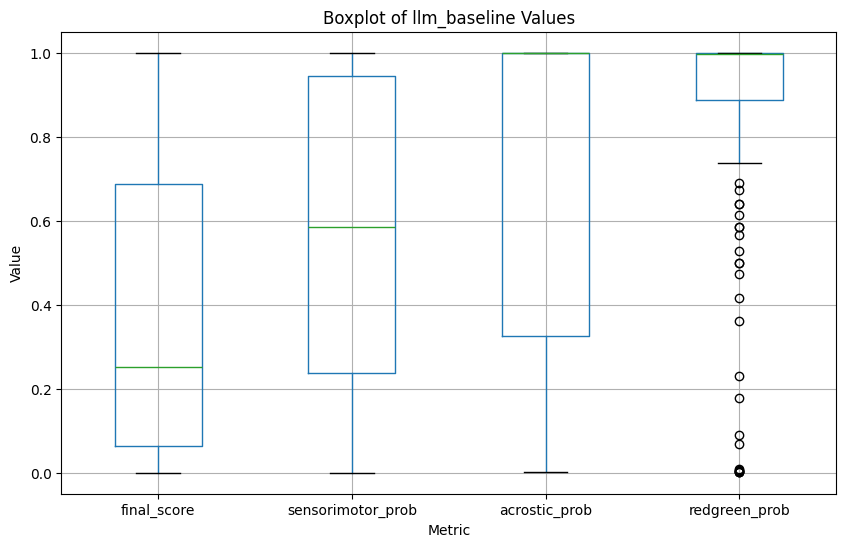

In [26]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('detection_results.json', 'r') as file:
    data = json.load(file)

# Extract the required values
values = {
    "final_score": [],
    "sensorimotor_prob": [],
    "acrostic_prob": [],
    "redgreen_prob": []
}

for entry in data:
    llm_baseline = entry['detection']['llm_baseline']
    values["final_score"].append(llm_baseline['final_score'])
    values["sensorimotor_prob"].append(llm_baseline['sensorimotor_prob'])
    values["acrostic_prob"].append(llm_baseline['acrostic_prob'])
    values["redgreen_prob"].append(llm_baseline['redgreen_prob'])

# Create a DataFrame
df = pd.DataFrame(values)

# Plot the boxplot
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Boxplot of llm_baseline Values')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.show()

In [62]:
import json
import time
from google_trans_new import google_translator  

# Function to translate text with retry logic
def translate_text(text, target_language='en', retries=3, delay=1):
    if not text:
        return ""  # Return empty string if text is None or empty
    
    translator = google_translator() 
    
    for attempt in range(retries):
        try:
            # Attempt the translation
            translation = translator.translate(text, lang_tgt=target_language)
            return translation.text
        except Exception as e:
            print(f"Error during translation: {e}. Attempt {attempt + 1} of {retries}")
            time.sleep(delay)  # Wait before retrying
    
    # If all attempts fail, return the original text
    print("Translation failed. Returning the original text.")
    return text

# Specify the JSON file name
json_file_name = "generation_results.json"

# Load the JSON data
with open(json_file_name, 'r') as json_file:
    data = json.load(json_file)

# Translate the outputs
translations = []
for entry in data:
    prompt = entry.get("prompt", "")
    
    # Translate each output to Spanish and back to English
    baseline = translate_text(translate_text(entry.get("baseline", ""), 'es'), 'en')
    llm_baseline = translate_text(translate_text(entry.get("llm_baseline", ""), 'es'), 'en')
    llm_senso_medium = translate_text(translate_text(entry.get("llm_senso_medium", ""), 'es'), 'en')
    llm_acro_medium = translate_text(translate_text(entry.get("llm_acro_medium", ""), 'es'), 'en')
    llm_redgreen_medium = translate_text(translate_text(entry.get("llm_redgreen_medium", ""), 'es'), 'en')
    llm_both_medium = translate_text(translate_text(entry.get("llm_both_medium", ""), 'es'), 'en')
    llm_senso_redgreen_medium = translate_text(translate_text(entry.get("llm_senso_redgreen_medium", ""), 'es'), 'en')
    llm_acro_redgreen_medium = translate_text(translate_text(entry.get("llm_acro_redgreen_medium", ""), 'es'), 'en')
    llm_all_three_medium = translate_text(translate_text(entry.get("llm_all_three_medium", ""), 'es'), 'en')

    # Append the translations to the list
    translations.append({
        "prompt": prompt,
        "baseline": baseline,
        "llm_baseline": llm_baseline,
        "llm_senso_medium": llm_senso_medium,
        "llm_acro_medium": llm_acro_medium,
        "llm_redgreen_medium": llm_redgreen_medium,
        "llm_both_medium": llm_both_medium,
        "llm_senso_redgreen_medium": llm_senso_redgreen_medium,
        "llm_acro_redgreen_medium": llm_acro_redgreen_medium,
        "llm_all_three_medium": llm_all_three_medium
    })

# Optionally, save the translations to a new JSON file
output_file_name = "translated_data.json"
with open(output_file_name, 'w') as output_file:
    json.dump(translations, output_file, indent=4, ensure_ascii=False)

print("Translations completed and saved to", output_file_name)


Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 1 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 2 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 3 of 3
Translation failed. Returning the original text.
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 1 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 2 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 3 of 3


KeyboardInterrupt: 

In [61]:
!pip install google_trans_new 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
import json
import re
import random
import math
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm

import os
os.chdir("/home/feline/master-generation")
# Parameters
replace_percentage = 0.10  # Default 10%
num_samples = None         # Set to None to process all samples
max_iterations_multiplier = 5  # To prevent infinite loops
batch_size = 8  # Batch size for processing masked sentences

# Debug flag
debug = False  # Set to True to enable debug outputs

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if debug:
    print(f"Using device: {device}")

# Load the JSON data
with open('generation_results_5.json', 'r') as f:
    data = json.load(f)

# Initialize T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device)  # Move model to GPU if available

# Function to reconstruct text from words
def reconstruct_text(words):
    text = ''
    for i in range(len(words)):
        if i > 0:
            if re.match(r'\w', words[i]) and re.match(r'\w', words[i - 1]):
                text += ' '
            elif re.match(r'\w', words[i]) and words[i - 1] in (')', ']', '}', '"', "'"):
                text += ' '
            elif words[i] in ('(', '[', '{', '"', "'") and not words[i - 1].isspace():
                text += ' '
        text += words[i]
    return text

# Fields to process
fields_to_process = [
    "llm_baseline", "llm_senso_medium", "llm_acro_medium", "llm_redgreen_medium",
    "llm_both_medium", "llm_senso_redgreen_medium", "llm_acro_redgreen_medium",
    "llm_all_three_medium"
]

# Process samples
processed_data = []
samples_to_process = data if num_samples is None else data[:num_samples]

for sample_idx, sample in enumerate(tqdm(samples_to_process, desc="Processing samples")):
    if debug:
        print(f"\nProcessing sample {sample_idx + 1}/{len(samples_to_process)}")
    new_sample = sample.copy()
    for field in fields_to_process:
        if field in sample:
            if debug:
                print(f"\nProcessing field: {field}")
            text = sample[field]
            # Split text into words and punctuation
            words = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
            T = len(words)
            epsilon_T = max(1, math.ceil(replace_percentage * T))
            successful_replacements = 0
            iterations = 0
            max_iterations = max_iterations_multiplier * epsilon_T
            processed_indices = set()

            if debug:
                print(f"Total words: {T}")
                print(f"Replacement budget (epsilon_T): {epsilon_T}")
                print(f"Max iterations: {max_iterations}")

            # Create a list of available indices and shuffle them for randomness
            available_indices = list(range(T))
            random.shuffle(available_indices)

            while successful_replacements < epsilon_T and iterations < max_iterations and available_indices:
                # Prepare batch of masked sentences
                batch_input_texts = []
                batch_word_indices = []
                batch_original_words = []
                batch_size_current = min(batch_size, len(available_indices))
                indices_to_remove = []
                for idx in range(batch_size_current):
                    word_idx = available_indices[idx]
                    original_word = words[word_idx]
                    # Skip if the word is a special token
                    if original_word in tokenizer.all_special_tokens:
                        continue
                    words_masked = words.copy()
                    words_masked[word_idx] = '<extra_id_0>'
                    masked_text = reconstruct_text(words_masked)
                    batch_input_texts.append(masked_text)
                    batch_word_indices.append(word_idx)
                    batch_original_words.append(original_word)
                    indices_to_remove.append(word_idx)
                    iterations += 1

                # Remove processed indices
                for idx in indices_to_remove:
                    available_indices.remove(idx)
                    processed_indices.add(idx)

                if not batch_input_texts:
                    continue

                # Tokenize batch input texts
                input_ids = tokenizer(batch_input_texts, return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
                # Generate outputs
                outputs = model.generate(
                    input_ids=input_ids,
                    max_length=50,
                    num_beams=10,          # Reduced from 50 to 10 for speed
                    num_return_sequences=3,  # Reduced from 20 to 3
                    early_stopping=True
                )

                # Process outputs
                num_return_sequences = 3
                outputs = outputs.view(len(batch_input_texts), num_return_sequences, -1)
                for i in range(len(batch_input_texts)):
                    word_idx = batch_word_indices[i]
                    original_word = batch_original_words[i]
                    output_sequences = outputs[i]
                    replacement_found = False
                    for output in output_sequences:
                        output_text = tokenizer.decode(output, skip_special_tokens=False)
                        # Extract the generated text after '<extra_id_0>'
                        split_text = output_text.split('<extra_id_0>')
                        if len(split_text) < 2:
                            continue
                        gen_text = split_text[1]
                        # Remove any additional '<extra_id_X>' tokens
                        gen_text = gen_text.split('<extra_id_')[0]
                        gen_text = gen_text.strip()
                        if gen_text and gen_text != original_word:
                            # Replace the word
                            words[word_idx] = gen_text
                            successful_replacements += 1
                            replacement_found = True
                            break  # Move to next word
                    if successful_replacements >= epsilon_T:
                        break

            # Reconstruct the final text
            final_text = reconstruct_text(words)
            new_sample[field] = final_text
            if debug:
                print(f"\nFinal text for field '{field}':\n{final_text}")

    processed_data.append(new_sample)

# Save the results to a new JSON file
with open('attack_data5.json', 'w') as f:
    json.dump(processed_data, f, indent=4)

if debug:
    print("\nProcessing completed. Results saved to 'output.json'.")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing samples: 100%|██████████| 9/9 [08:47<00:00, 58.57s/it]


In [6]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

generated_numbers = [0,0]
shared.secret_key = generated_numbers

def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(last_sentence=sentence, last_token=None,range_list=range_list)
        shared.secret_key = generated_numbers

        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])



  the and ran in until roughly the latter half I use GoChat back go apple to apple tar apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple
  the B

In [8]:


# Specify the file name
file_name = "output_score9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores)

[([0.8244924197398473, 0.8244924197398473, 1.0, 1, 0], [0.20866363989568165, 0.25387122310442956, 0.8219271067593517, 6, 0])]


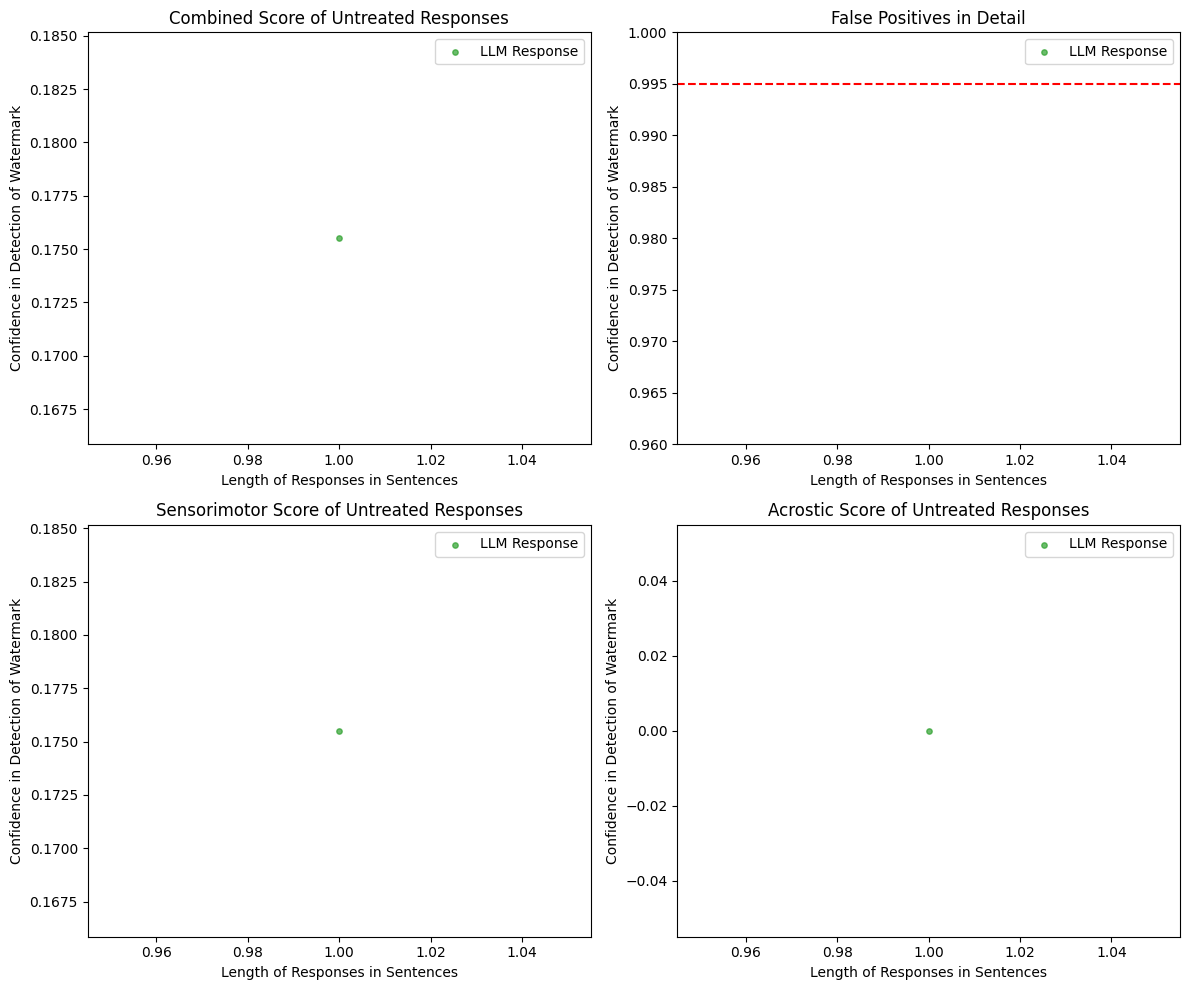

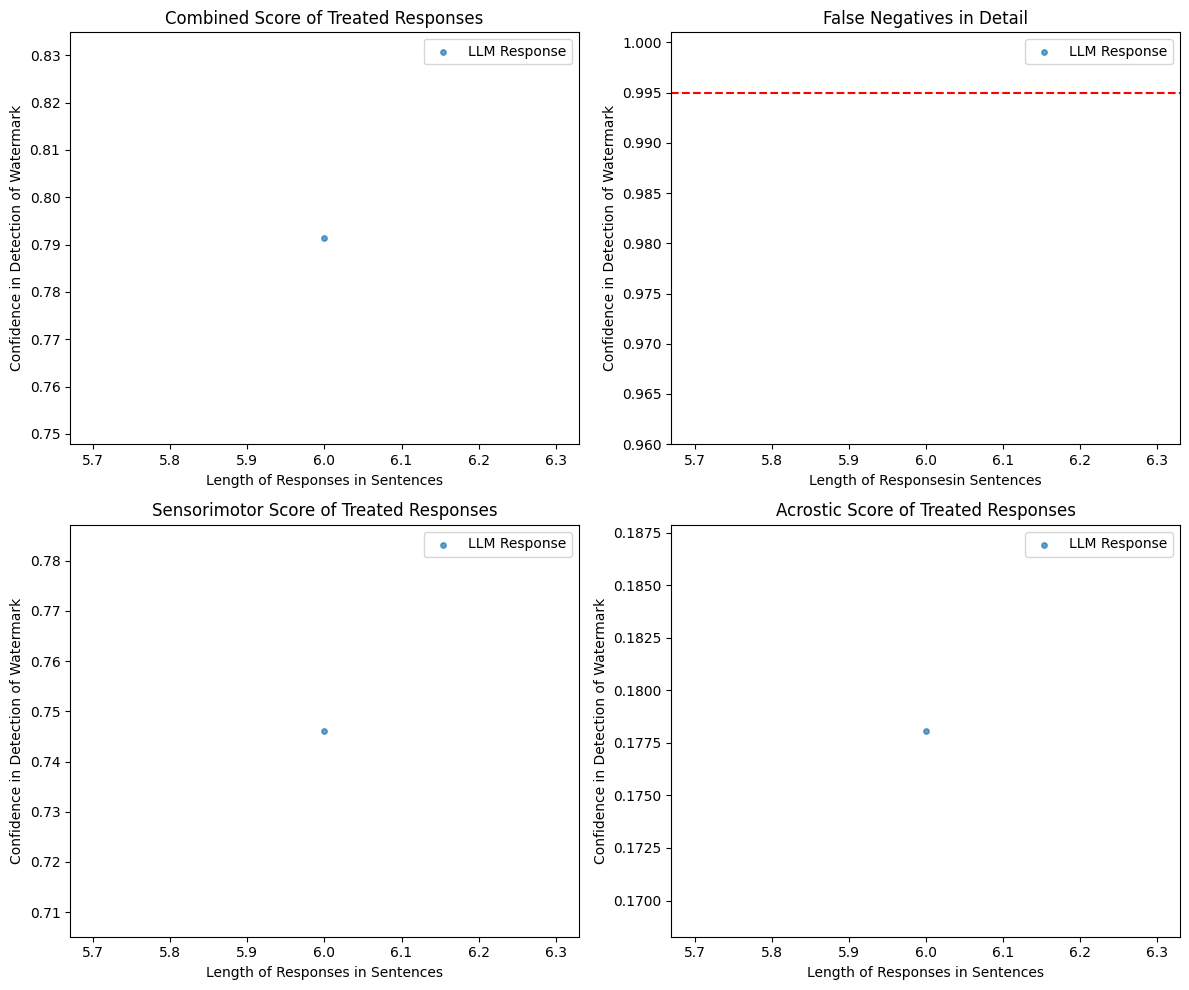

In [9]:
import csv
import ast
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score9.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0][0] for item in scores]
x_values1 = [item[0][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Untreated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Positives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[0][1] for item in scores]
x_values3 = [item[0][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Untreated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[0][2] for item in scores]
x_values4 = [item[0][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Untreated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()




# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[1][0] for item in scores]
x_values2 = [item[1][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responsesin Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1][1] for item in scores]
x_values3 = [item[1][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[1][2] for item in scores]
x_values4 = [item[1][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

b_both_TN 25
b_both_FP 1
w_both_TP 35
w_both_FN 2


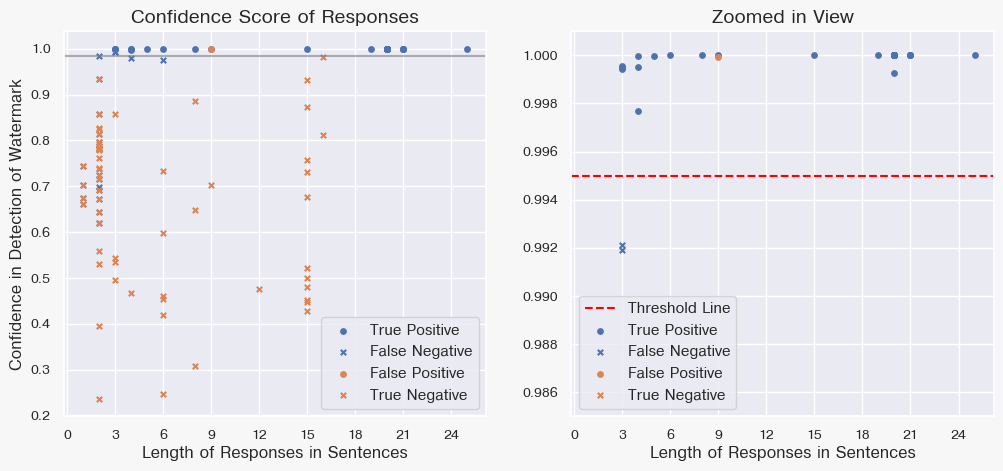

In [8]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot.png', dpi=300, bbox_inches='tight')

[([0.173401239922371, 0.18033728951926586, 0.9615384615384615, 2, 0], [0.008095692064743856, 0.10945375671533686, 0.07396449704142016, 3, 1]), ([0.5528075667495754, 0.9572838433968545, 0.5774750828218062, 15, 0], [8.088322321246105e-29, 0.06199434289624539, 1.3046871606951035e-27, 20, 19]), ([0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0], [0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0]), ([0.26599358934253925, 0.32362187249339414, 0.8219271067593517, 6, 0], [2.3256557008037786e-29, 0.017825389647927015, 1.3046871606951035e-27, 20, 19]), ([0.26963812351506783, 0.46692598786685857, 0.5774750828218062, 15, 0], [7.049453852192648e-28, 0.540317561524625, 1.3046871606951035e-27, 20, 19]), ([0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0], [0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0]), ([0.21951100790989175, 0.22829144822628744, 0.9615384615384615, 2, 0], [0.21951100790989175, 0.22829144822628744, 0.96153846153

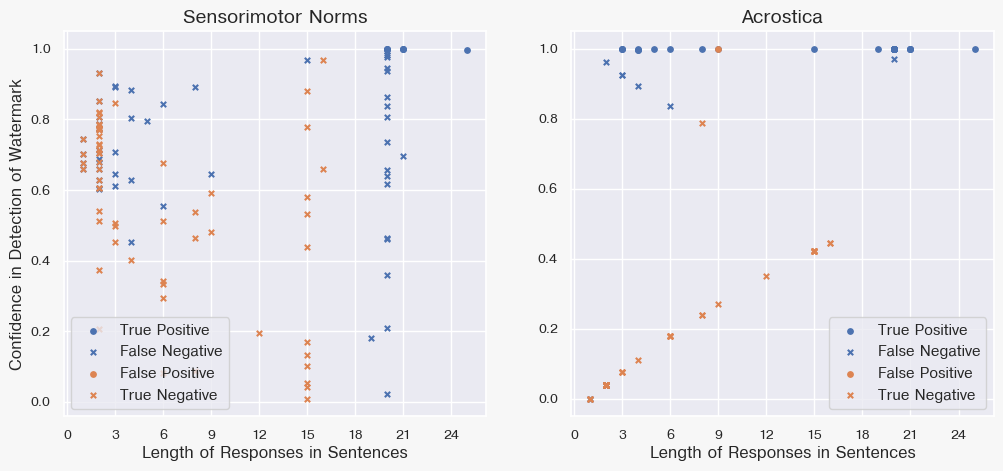

In [11]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')





axs[0].set_title('Sensorimotor Norms', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Acrostica', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

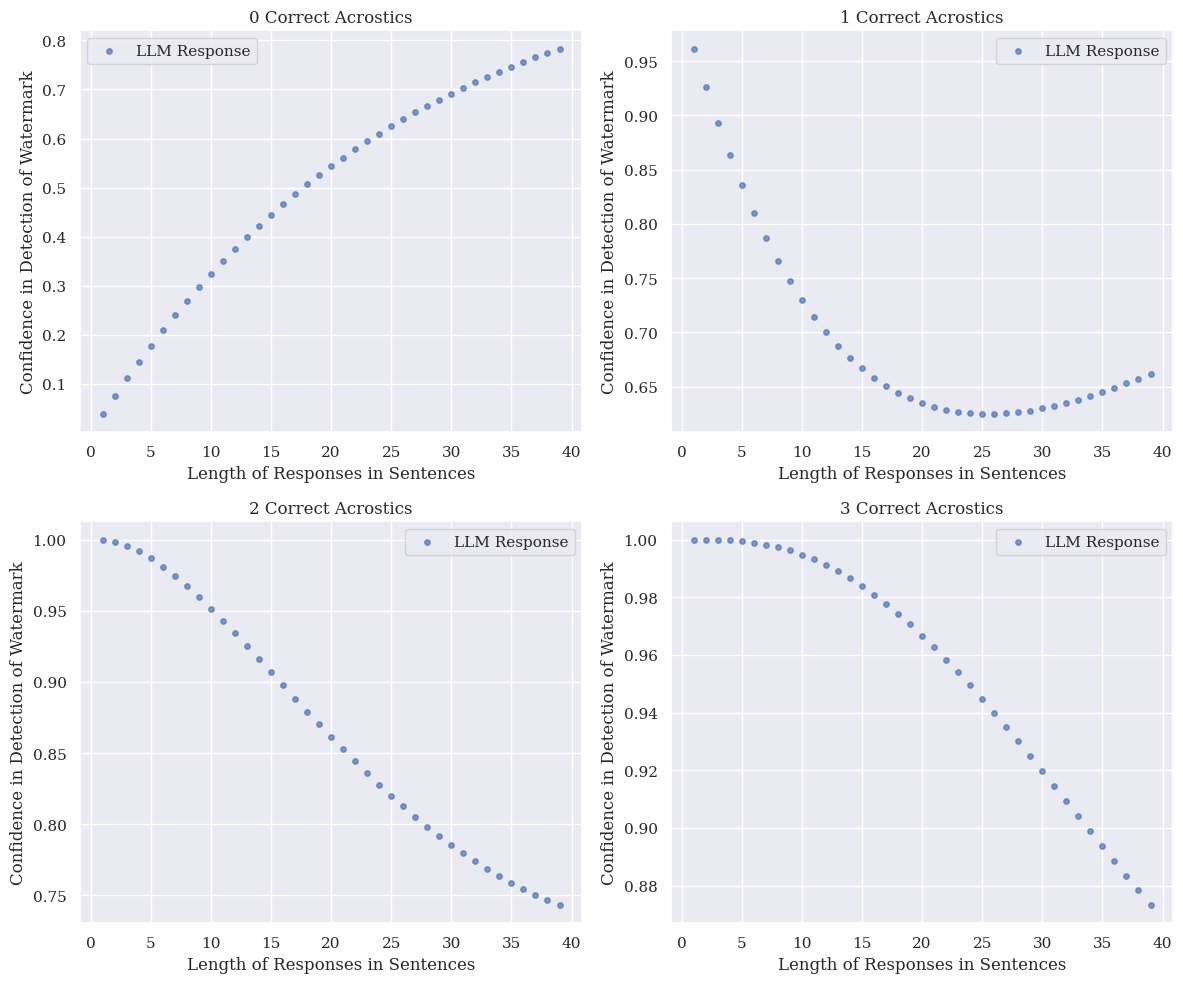

In [81]:
def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
x_values1 = range(1,40)
y_values1 = []
for x in x_values1:
        y_values1.append(1-probability_of_acrosticon(0,x))
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('0 Correct Acrostics')
axs[0, 0].legend()

# Subplot 2
x_values2 = range(1,40)
y_values2 = []
for x in x_values2:
        y_values2.append(1-probability_of_acrosticon(1,x))
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('1 Correct Acrostics')
axs[0, 1].legend()

# Subplot 3
x_values3 = range(1,40)
y_values3 = []
for x in x_values3:
        y_values3.append(1-probability_of_acrosticon(2,x))
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('2 Correct Acrostics')
axs[1, 0].legend()

# Subplot 4
x_values4 = range(1,40)
y_values4 = []
for x in x_values4:
        y_values4.append(1-probability_of_acrosticon(3,x))
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('3 Correct Acrostics')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [12]:
import csv
from googletrans import Translator

# Function to translate text
def translate_text(text, target_language='en'):
    if not text:
        return ""  # Return empty string if text is None or empty
    try:
        translator = Translator()
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return the original text if translation fails

# Specify the file name
file_name = "output_gen6.csv"

# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object and convert it to a list
    output_gen = list(csv.reader(csv_file))

# Example usage
translations = []
for text in output_gen:
    # Assuming text[2] is the column with the text to be translated
    # Check if text[2] exists and is not empty
    if len(text) > 2 and text[2]:
        translated_text_watermark = translate_text(text[2], 'es')  # Translate to Spanish
        #translated_text_watermark = translate_text(translated_text_watermark, 'en')  # Translate back to English

    else:
        translated_text_watermark = ""

    if len(text) > 2 and text[1]:
        translated_text_base = translate_text(text[1], 'es')  # Translate to Spanish
        #translated_text_base = translate_text(translated_text_base, 'en')  # Translate back to English
    else:
        translated_text_base = ""

    if len(text) > 2 and text[0]:
        prompt = text[0]
    else:
        prompt = ""

    
    translations.append([prompt,translated_text_base,translated_text_watermark])

Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType


In [13]:
import csv

# Specify the file name
file_name = "output_translation_genX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(translations)

In [14]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

# def secure_hash_to_numbers(input_string, range_list):

    
#     nlp = spacy.load("en_core_web_sm")

#     doc = nlp(input_string)

    
#     core = [token.lemma_ for token in doc if not token.is_stop]

#     core_str = " ".join(core)
    
#     hashed_bytes = hashlib.sha256(core_str.encode()).digest()
    
    

#     num_numbers = len(range_list)
#     hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

#     #cast hash to integer, then use modulo to map to required range
   
#     result_numbers = []
#     for i in range(num_numbers):
#         range_min, range_max = range_list[i]
#         integer = hashed_integers[i]
#         mapped_number = (integer % (range_max - range_min + 1)) + range_min
#         result_numbers.append(mapped_number)
    
#     return result_numbers


# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores_translation = []


for tuple in translations:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores_translation.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])




    

In [15]:
# Specify the file name
file_name = "output_translation_scoreX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores_translation)

In [8]:
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation2.csv"
file_name = "output_translation2.csv"  # replace with your file name
scores_translation = []

# Open the file and read the contents
with open(file_name, 'r') as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        # Convert each element in the row to float or int as appropriate
        data_row = [float(item) if '.' in item else int(item) for item in row]
        scores_translation.append(data_row)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0] for item in scores_translation]
x_values1 = [item[3] for item in scores_translation]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Attacked Responses')
axs[0, 0].axhline(y=0.995, color='red', linestyle='--', label='Red Line')
axs[0, 0].legend()

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_both_TP = 0
tw_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_both_TP += 1
    else:
        if x_values[i] > 3:
            tw_both_FN += 1



# Subplot 2
y_values2 = [1-item[0] for item in scores_translation]
x_values2 = [item[3] for item in scores_translation]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')




# Subplot 3
y_values3 = [1-item[1] for item in scores_translation]
x_values3 = [item[3] for item in scores_translation]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Attacked Responses')
axs[1, 0].legend()

x_values = np.array(x_values3)
y_values = np.array(y_values3)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_senso_TP = 0
tw_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_senso_TP += 1
    else:
        if x_values[i] > 3:
            tw_senso_FN += 1

# Subplot 4
y_values4 = [1-item[2] for item in scores_translation]
x_values4 = [item[3] for item in scores_translation]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Attacked Responses')
axs[1, 1].legend()


x_values = np.array(x_values4)
y_values = np.array(y_values4)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_acro_TP = 0
tw_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_acro_TP += 1
    else:
        if x_values[i] > 3:
            tw_acro_FN += 1

print(f'''tw_both_TP {tw_both_TP}''')
print(f'''tw_both_FN {tw_both_FN}''')
print(f'''tw_senso_TP {tw_senso_TP}''')
print(f'''tw_senso_FN {tw_senso_FN}''')
print(f'''tw_acro_TP {tw_acro_TP}''')
print(f'''tw_acro_FN {tw_acro_FN}''')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'output_translation2.csv'

[[0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.5, 0.5, 1.0, 1, 0], [0.16313687894503626, 0.644985130122344, 0.2529312248083791, 10, 1], [0.0074157060185854155, 0.152459117397856, 0.0486406201554575, 11, 2], [0.4815686641915553, 0.5008314107592176, 0.9615384615384615, 2, 0], [0.3454519329611654, 0.37364081069079647, 0.9245562130177515, 3, 0], [0.11989614467796823, 0.14587199240902038, 0.8219271067593517, 6, 0], [0.48660592278700776, 0.640340197759805, 0.7599178132020633, 8, 0], [0.7973759062443191, 0.7973759062443191, 1.0, 1, 0], [0.7086198848130916, 0.8289850380348087, 0.8548041910297263, 5, 0], [0.12287687812504762, 0.5774913887787122, 0.2127769876965777, 8, 1], [0.5401003058225788, 0.5401003058225788, 1.0, 1, 0], [0.4936081321406111, 0.5133524574262356, 0.9615384615384615, 2, 0], [0.6035806721143874, 0.6035806721143874, 1.0, 1, 0], [0.5828720919037046, 0.7670199089657581, 0.7599178132020633, 8, 0], [0.7462422571933712, 0.7462422571933712, 1.0, 1, 0], [0.5576512335318943, 0.

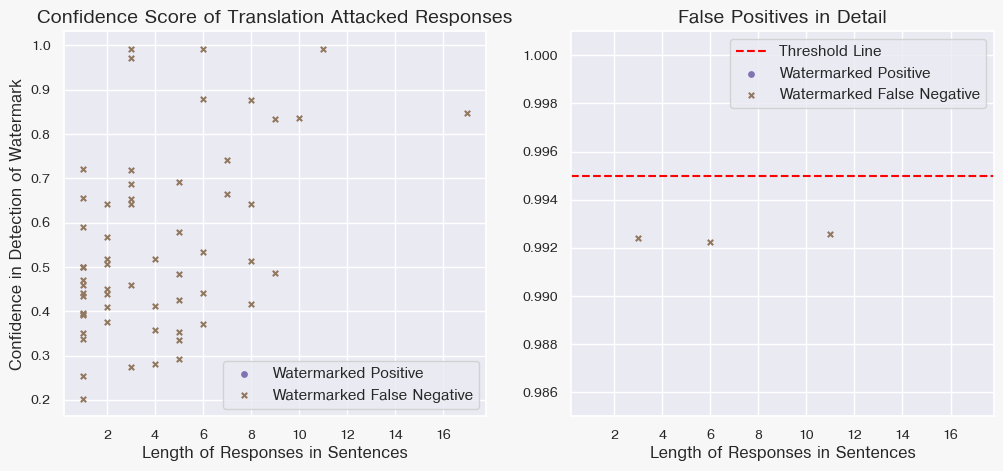

In [10]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


import ast  # Import the ast module

scores = []

# Assuming 'file' is your file object
with open('output_score2.csv', 'r') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
        # Check if the row looks like a string representation of a list
        if row[0].startswith('[') and row[0].endswith(']'):
            # Use ast.literal_eval to safely evaluate the string as a list
            data_row = ast.literal_eval(row[0])
        else:
            # For rows that do not contain a string representation of a list
            # Convert each element in the row to float or int as appropriate
            data_row = [float(item) if '.' in item else int(item) for item in row]
        
        scores.append(data_row)

print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[:][0] for item in scores]
x_values1 = [item[:][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)


axs[1].legend()

plt.savefig('oldhash.png', dpi=300, bbox_inches='tight')

b_both_TN 70
b_both_FP 6
w_both_TP 16
w_both_FN 56


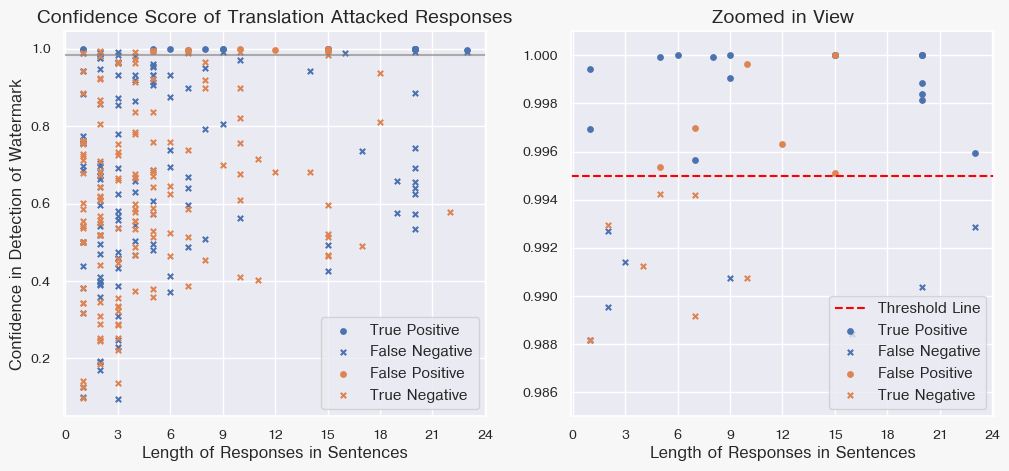

In [16]:
import csv
import ast
#%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_scoreX.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot_translation.png', dpi=300, bbox_inches='tight')

[([0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.3281204982094562, 0.3281204982094562, 1.0, 1, 0]), ([0.6166518151174941, 0.6669706032310816, 0.9245562130177515, 3, 0], [8.553158817654539e-11, 0.18603365304089636, 4.5976406299855176e-10, 20, 10]), ([0.519091104498668, 0.5839068961707898, 0.8889963586709148, 4, 0], [0.2906362734298562, 0.30226172436705045, 0.9615384615384615, 2, 0]), ([0.594967782715279, 0.6187664940238902, 0.9615384615384615, 2, 0], [4.595478481516161e-13, 0.03054118608804135, 1.504682387995258e-11, 20, 11]), ([0.4929113609549464, 0.53313292800887, 0.9245562130177515, 3, 0], [0.22653737190337375, 0.22653737190337375, 1.0, 1, 0]), ([0.6216508991115235, 0.6216508991115235, 1.0, 1, 0], [0.0003560309241830312, 0.35194742151679437, 0.0010116025929345867, 7, 3]), ([0.5350870127442552, 0.5350870127442552, 1.0, 1, 0], [0.0043513289140891835, 0.3308785595389778, 0.013150833708149628, 6, 2]), ([0.6626609602814836, 0.6626609602814836, 1.0, 1, 0], [0.6191067768285119, 0.6

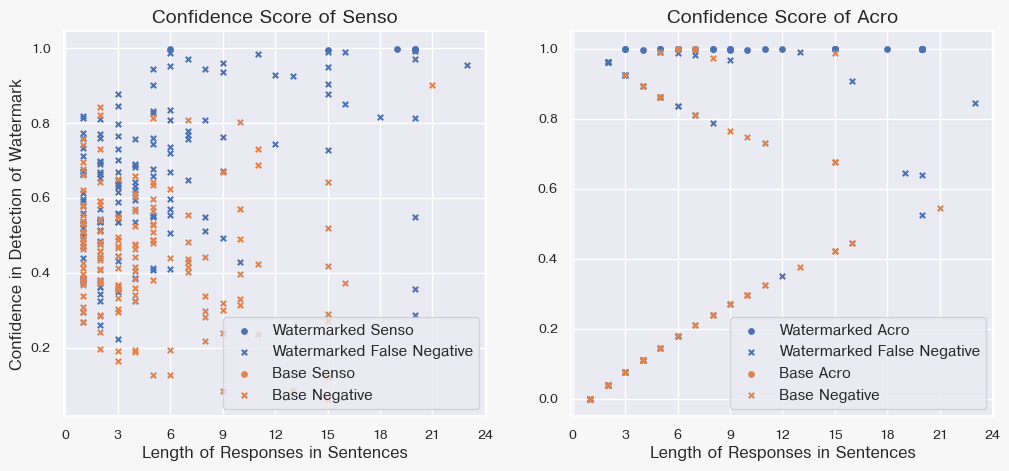

In [1]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')





axs[0].set_title('Confidence Score of Senso', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Confidence Score of Acro', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

#plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

In [8]:

prompts = [\
    "How do I write a good paper?"
    #"What is a watermark?"
    #"What is motorsports, is it a real sport?",
]



results = []


for prompt in prompts:
#prompt = "What is the capital of France?"
    question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant
'''

    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.10,
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }

    #no watermark
    shared.delta_char = 0.0
    shared.delta_acro = 0.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_base += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_base, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #only senso
    shared.delta_char = 2.5#2.5
    shared.delta_acro = 0.0#50
    shared.secret_key = [0,0]
    done = False
    reply_senso = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_senso += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1

    reply_senso, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')
    
    #only acro
    shared.delta_char = 0.0#2.5
    shared.delta_acro = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_acro = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_acro += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_acro, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #both
    shared.delta_char = 2.5#2.5
    shared.delta_acro = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_watermark += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_watermark, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')


    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_senso,reply_acro,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_senso}]''')
    print(f'''[{reply_acro}]''')
    print(f'''[{reply_watermark}]''')

Output generated in 1.04 seconds (11.58 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.40 seconds (13.56 tokens/s, 19 tokens, context 96, seed 0)
Output generated in 1.45 seconds (14.52 tokens/s, 21 tokens, context 115, seed 0)
Output generated in 1.46 seconds (13.70 tokens/s, 20 tokens, context 135, seed 0)
Output generated in 0.99 seconds (12.15 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.81 seconds (14.91 tokens/s, 27 tokens, context 96, seed 0)
Output generated in 1.69 seconds (14.81 tokens/s, 25 tokens, context 123, seed 0)
Output generated in 1.20 seconds (11.64 tokens/s, 14 tokens, context 147, seed 0)
Output generated in 1.00 seconds (11.98 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.83 seconds (16.40 tokens/s, 30 tokens, context 96, seed 0)
Output generated in 1.65 seconds (13.98 tokens/s, 23 tokens, context 126, seed 0)
Output generated in 1.06 seconds (11.35 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.8

In [2]:
results2 = [["What is motorsports, is it a real sport?",
             "Motorsports is a sport that uses vehicles for competition. Many people consider motorsports to be a form of racing, but they can also be classified as an extreme sport due to the level of danger and physical exertion involved.The term motorsport is used to refer to many different types of competitions involving motorized vehicles.The most common type of motorsport is car racing, which includes events such as Formula One, NASCAR, and rallying.",
            "Motorsports is a sport that uses vehicles for competition. Many people disagree because they say that it is dangerous and cruel to animals, but what do you think? You can share your opinion on social network like facebook or you can comment this forum.",
            " Motorsports is a sport that uses vehicles for competition. Races can be held on land, water, ice, or snow, and may be based on speed, distance, or performance criteria such as endurance or durability. Races may also involve other forms of human-propelled vehicle or animal. Racers usually compete against each other, but races may also be against time.",
            " Motorsports is a sport that uses vehicles for competition. Rallying and rallycross are popular forms of motorsport. Car racing can take many different forms, such as drag racing, dirt track racing, rally racing, stock car racing, touring car racing, sports car racing, open wheel racing and kart racing. Understanding the differences between these forms of racing, as well as the racing world in general, is difficult if you do not follow racing closely"]]

In [4]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)

        print("////////////////////////////////////////////////////////////////////////////////")
        print(generated_numbers)


        sum_of_word_mean = 0
        valid_words = 0

        color_text = ""

        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]
                #print(f'''{word} : P={shared.sensorimotor[word.upper()][shared.classes[old_class]]}''')
                
                #color_text += f'''\colorword{{{val}}}{{{word}}} '''
                if shared.sensorimotor[word.upper()][shared.classes[old_class]] > mean_value[old_class]:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{val}}}{{{word}}}'''
                else:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''
            else:
                color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''

        #print(color_text)
        
        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words
            print(f'''valid words {valid_words}, word mean {sum_of_word_mean}, sentence_value {sentence_value}''')

            
            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results2:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])

    score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso = calculate_probs(tuple[2])
    score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro = calculate_probs(tuple[3])

    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[4])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso],[score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])

print(scores)

Motorsports is a sport that uses vehicles for competition .
////////////////////////////////////////////////////////////////////////////////
[9, 17]
valid words 6, word mean 12.638434320999998, sentence_value 2.1064057201666664
Many people consider motorsports to be a form of racing , but they can also be classified as an extreme sport due to the level of danger and physical exertion involved .
////////////////////////////////////////////////////////////////////////////////
[7, 17]
valid words 29, word mean 37.563870013, sentence_value 1.2953058625172413
The term motorsport is used to refer to many different types of competitions involving motorized vehicles .
////////////////////////////////////////////////////////////////////////////////
[6, 1]
valid words 12, word mean 14.914565827, sentence_value 1.2428804855833333
The most common type of motorsport is car racing , which includes events such as Formula One , NASCAR , and rallying .
//////////////////////////////////////////////////

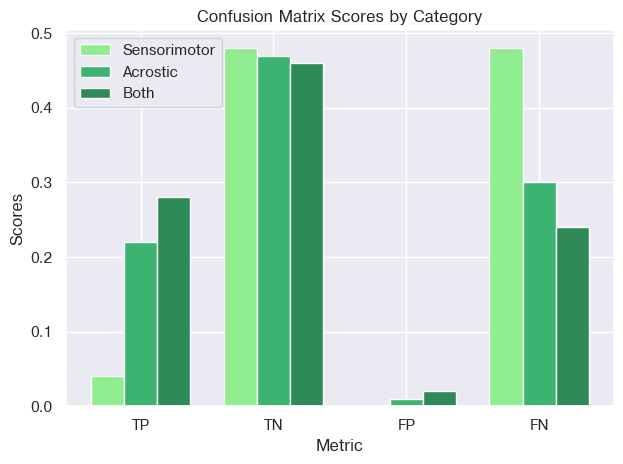

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# Data from the table
labels = ['TP', 'TN', 'FP', 'FN']
sensorimotor = [0.04, 0.48, 0.0, 0.48]
acrostic = [0.22, 0.47, 0.01, 0.30]
both = [0.28, 0.46, 0.02, 0.24]

# Indices and bar width
index = np.arange(len(labels))
bar_width = 0.25

# Plotting
fig, ax = plt.subplots()
bar1 = ax.bar(index - bar_width, sensorimotor, bar_width, label='Sensorimotor', color='lightgreen')
bar2 = ax.bar(index, acrostic, bar_width, label='Acrostic', color='mediumseagreen')
bar3 = ax.bar(index + bar_width, both, bar_width, label='Both', color='seagreen')

# Labels, title and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Confusion Matrix Scores by Category')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()


# Display plot
plt.tight_layout()
plt.show()


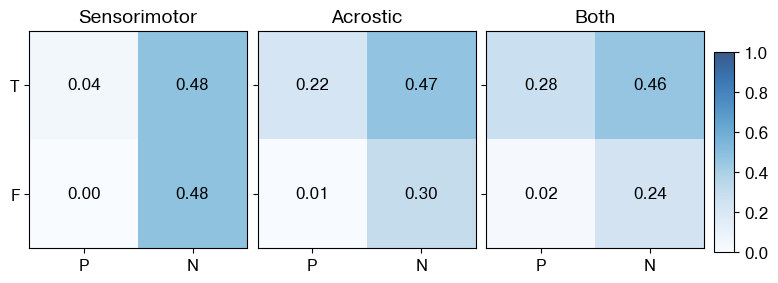

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'

# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.04, 0.48, 0.0, 0.48],  # Sensorimotor
    [0.22, 0.47, 0.01, 0.30],  # Acrostic
    [0.28, 0.46, 0.02, 0.24]   # Both
])

# Create a lighter colormap from the 'Blues' colormap
original_cmap = plt.cm.Blues
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)  # Reduced figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['P', 'N'])#, rotation=0, ha='right')
    ax.set_yticklabels(['T', 'F'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.81, 0.27, 0.02, 0.40])  # Adjusted the right and width parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix_translation.png', dpi=300, bbox_inches='tight')
plt.show()

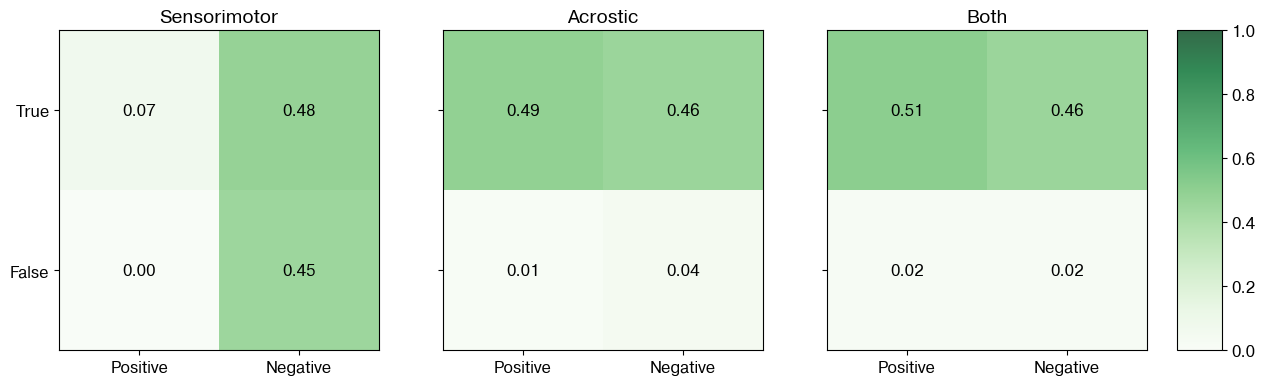

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.07, 0.48, 0.0, 0.45],  # Sensorimotor
    [0.49, 0.46, 0.01, 0.04],  # Acrostic
    [0.51, 0.46, 0.02, 0.02]   # Both
])
# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Greens
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.85)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix.png', dpi=300, bbox_inches='tight')
plt.show()

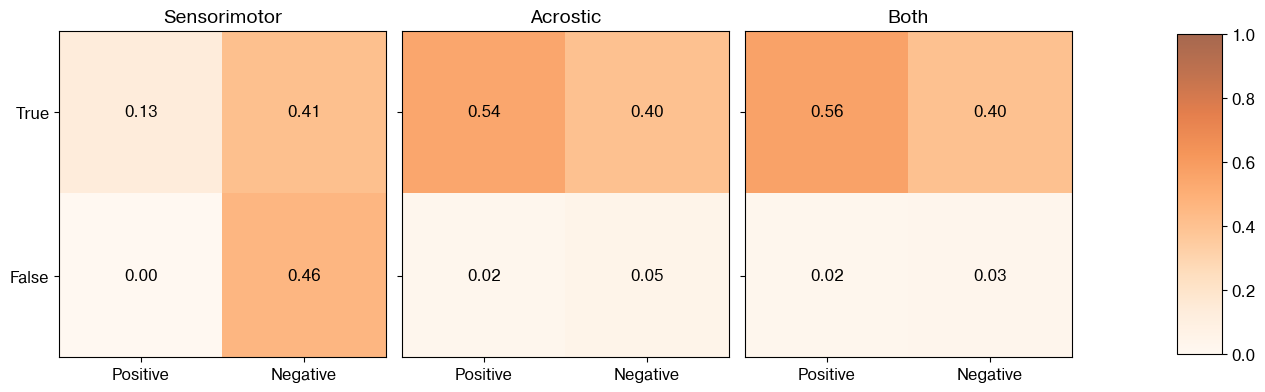

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.13, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.54, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Red/Green', 'Stylometry',]
data = np.array([
    [0.08, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.1, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()
